# Aphid-Ladybeetle study

In [1]:
import copy
import numpy as np  # linear algebra
from numba import jit

import arviz as az
from arviz.utils import Numba
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp  # to solve ODE system
import pandas as pd
import pymc3 as pm  # for uncertainty quantification and model calibration
import theano  # to control better pymc3 backend and write a wrapper
import theano.tensor as t  # for the wrapper to a custom model to pymc3
import time
from tqdm.autonotebook import tqdm
import warnings
import sys

np.seterr('warn')
#warnings.filterwarnings("ignore")
az.style.use("arviz-darkgrid")

Numba.enable_numba()

seed=1234
np.random.seed(seed)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
<ipython-input-1-725386291a9c>:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Obtaining Initial Conditions

We need to define Initial Conditions as functions in order to define them for each discretization point. Here we will fit ICs as polynomial functions.

Loading data:

### 2018_Lin_and_Pennings

In [2]:
data_dir = "../data/2018 Lin and Pennings/appendix/"
aphid_data = pd.read_csv(data_dir + 'aphid.CSV')
ladybeetle_data = pd.read_csv(data_dir + 'ladybeetle.CSV')

Retrieving IC data:

In [3]:
aphid_ic = aphid_data[aphid_data.Time == 1].Density.values[0]
ladybeetle_ic = ladybeetle_data[ladybeetle_data.Time == 1].Density.values[0]

aphid_density = aphid_data["Density"].values.flatten()
ladybeetle_density = ladybeetle_data["Density"].values.flatten()
time_list = aphid_data["Time"].values.flatten()

y0 = aphid_ic, ladybeetle_ic

y0

# Regularization

In [4]:
#%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel, ExpSineSquared

In [5]:
def read_data_file(path, filename):
    raw_data = pd.read_csv(f"{path}/{filename}", usecols=["Time", "Density"])
    return raw_data

In [6]:
def plot_data(time_list, density, mean_density, min_density, max_density):
    fig, ax = plt.subplots(figsize=(7, 4))
    
    ax.plot(time_list, density,marker='o')
    ax.plot(t_list, mean_density)
    
    plt.xlabel('Time')

    ax.fill_between(t_list,
                    min_density,
                    max_density,
                    alpha=0.2)

In [7]:
t_list = time_list
t_list = np.linspace(t_list[0], t_list[-1], 200)
#t_list = np.linspace(-10, 50, 200)

def regularize_data(time_list, density):
    kernel = RBF(length_scale_bounds=(10,100)) + WhiteKernel(noise_level_bounds=(1e-10, 5e-10))
#    kernel = ConstantKernel(constant_value_bounds = (1.0e-7,1.0e-6)) * RBF(length_scale_bounds = (20,40)) + WhiteKernel(noise_level_bounds = (1.0e-10, 1.0e-9))

#    model = GaussianProcessRegressor(kernel=kernel, alpha=1.0e-8, n_restarts_optimizer=10, normalize_y=True)
    model = GaussianProcessRegressor(kernel=kernel, alpha=1.0e-10, n_restarts_optimizer=100, normalize_y=np.max(density))
    model.fit(time_list.reshape(-1, 1), density)
    target_pred = model.predict(t_list.reshape(-1, 1), return_std=True)
    
    print(str(model.kernel_.get_params()))
    print("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
          % (kernel, model.kernel_,
             model.log_marginal_likelihood(model.kernel_.theta)))
    
    mean_density = target_pred[0]
    err = 1.96 * np.max(density) * target_pred[1]
    min_density = target_pred[0] - err
    max_density = target_pred[0] + err
    
    return (mean_density, min_density, max_density)

{'k1': RBF(length_scale=10), 'k2': WhiteKernel(noise_level=5e-10), 'k1__length_scale': 10.000000000000002, 'k1__length_scale_bounds': (10, 100), 'k2__noise_level': 4.999999999999994e-10, 'k2__noise_level_bounds': (1e-10, 5e-10)}
Initial: RBF(length_scale=1) + WhiteKernel(noise_level=1)
Optimum: RBF(length_scale=10) + WhiteKernel(noise_level=5e-10)
Log-Marginal-Likelihood: -525176668.4513282


/home/tungdil/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/tungdil/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 5e-10. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Text(0, 0.5, 'Aphid population')

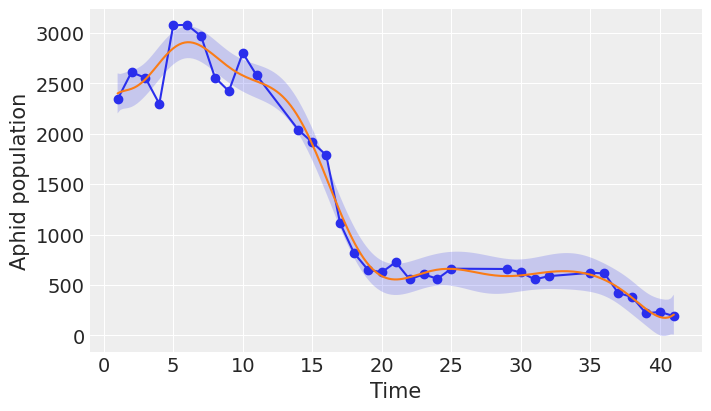

In [8]:
(mean_density, min_density, max_density) = regularize_data(time_list, aphid_density)
plot_data(time_list, aphid_density, mean_density, min_density, max_density)
plt.ylabel('Aphid population')

In [9]:
#aphid_density = aphid_data.Density.values
aphid_density = mean_density

In [10]:
t_list = time_list
t_list = np.linspace(t_list[0], t_list[-1], 200)

def regularize_data(time_list, density):
#    kernel = RBF(length_scale_bounds=(20,40)) + WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-3, 1e-2))
#    kernel = ConstantKernel(constant_value_bounds = (60.0, 70.0))*RBF(length_scale_bounds = (25,45)) + WhiteKernel(noise_level_bounds = (1.0e-3, 1.0e-2))
#    kernel = ConstantKernel(constant_value_bounds = (1.0e-1, 1.0))*RBF(length_scale_bounds = (20,45)) + WhiteKernel(noise_level_bounds = (1.0e-3, 1.0e-2))
    kernel = ConstantKernel(constant_value_bounds = (1.0e-1, 1.0)) + WhiteKernel(noise_level_bounds = (1.0e-3, 1.0e-2))

    model = GaussianProcessRegressor(kernel=kernel, alpha=1.0e-10, n_restarts_optimizer=50, normalize_y=np.max(density))
#    model = GaussianProcessRegressor(kernel=kernel, alpha=1.0e-2, n_restarts_optimizer=50, normalize_y=True)
    model.fit(time_list.reshape(-1, 1), density)
    target_pred = model.predict(t_list.reshape(-1, 1), return_std=True)
    
    print(str(model.kernel_.get_params()))
    print("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
          % (kernel, model.kernel_,
             model.log_marginal_likelihood(model.kernel_.theta)))
    
    mean_density = target_pred[0]
    err = 1.96 * np.max(density) * target_pred[1]
    min_density = target_pred[0] - err
    max_density = target_pred[0] + err
    
    return (mean_density, min_density, max_density)

{'k1': 0.316**2, 'k2': WhiteKernel(noise_level=0.01), 'k1__constant_value': 0.10000000000000002, 'k1__constant_value_bounds': (0.1, 1.0), 'k2__noise_level': 0.010000000000000004, 'k2__noise_level_bounds': (0.001, 0.01)}
Initial: 1**2 + WhiteKernel(noise_level=1)
Optimum: 0.316**2 + WhiteKernel(noise_level=0.01)
Log-Marginal-Likelihood: -1655.871941370817


/home/tungdil/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/tungdil/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Text(0, 0.5, 'Ladybeetle population')

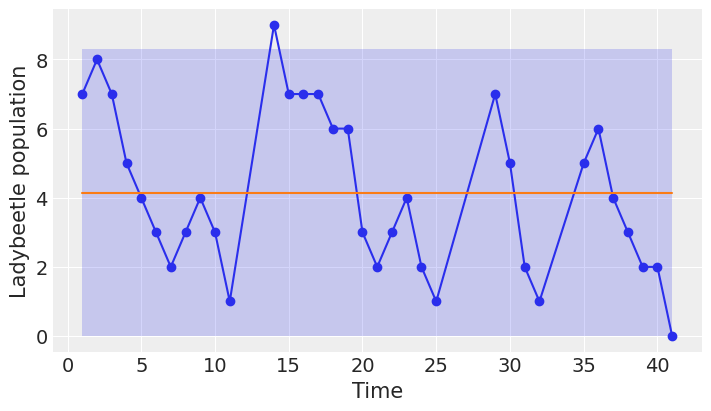

In [11]:
(mean_density, min_density, max_density) = regularize_data(time_list, ladybeetle_density)
plot_data(time_list, ladybeetle_density, mean_density, min_density, max_density)
plt.ylabel('Ladybeetle population')

In [12]:
#ladybeetle_density = ladybeetle_data.Density.values
ladybeetle_density = mean_density

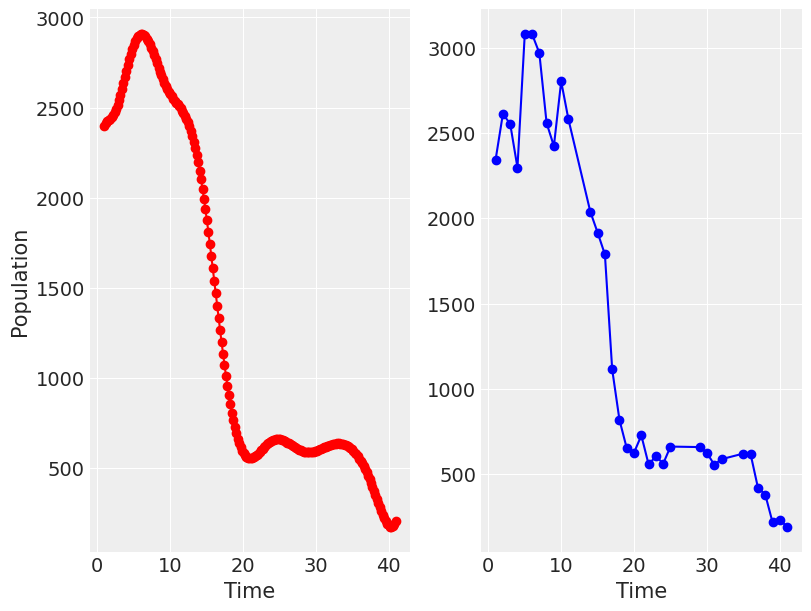

In [13]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

ax1.plot(t_list, aphid_density, '-o', c='r')
ax1.set(xlabel='Time', ylabel='Population')
ax2.plot(time_list, aphid_data.Density.values, '-o', c='b')
ax2.set(xlabel='Time')
plt.show()

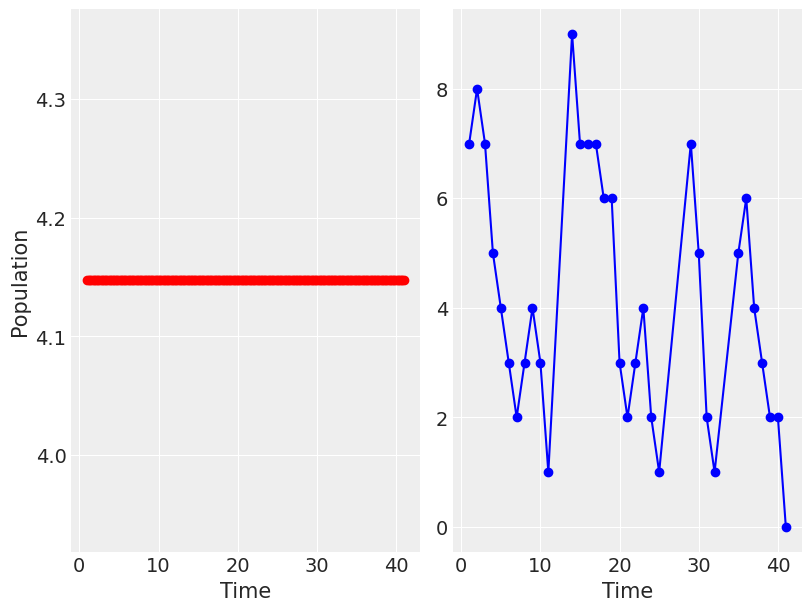

In [14]:
import matplotlib.pyplot as plt

fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(8, 6))

ax3.plot(t_list, ladybeetle_density, '-o', c='r')
ax3.set(xlabel='Time', ylabel='Population')
ax4.plot(time_list, ladybeetle_data.Density.values, '-o', c='b')
ax4.set(xlabel='Time')
plt.show()

In [15]:
aphid_ic = aphid_density[0]
ladybeetle_ic = ladybeetle_density[0]

In [16]:
y0 = aphid_ic, ladybeetle_ic

y0

(2400.5117688174696, 4.1470588235293935)

In [17]:
time_list = t_list

sys.exit(0)

# Model 14

In [18]:
import matplotlib.pyplot as plt
from numba import jit
import numpy as np  # linear algebra
from scipy.integrate import solve_ivp  # to solve ODE system
import pandas as pd

y0 = 2719.3794153268414, 4.147056509871602

@jit(nopython=True)
def M14_model(
    t,
    X,
    r2 = 7.712e-06,
    r3 = 5.226e-08,
    a21 = 3.212e-05,
    a12 = 2.902e-04,
):
    """
    Prey-Predator M14 Model python implementation.
    """
    u, v = X
    u_prime = - r2*u**2 + r3*u**3 - a21*u**2*v - a12*u*v**2
    v_prime = 0.0
    return u_prime, v_prime

def M14_ode_solver(
    y0,
    t_span,
    t_eval,
    r2 = 7.712e-06,
    r3 = 5.226e-08,
    a21 = 3.212e-05,
    a12 = 2.902e-04,
):
    solution_ODE = solve_ivp(
        fun=M14_model,
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        args=(r2, r3, a21, a12),
        method="LSODA",
    )
    return solution_ODE

t0 = time_list.min()
tf = time_list.max()
days_to_forecast = 0
time_list_range = np.linspace(t0, tf + days_to_forecast, len(time_list))

u_data = aphid_density
v_data = ladybeetle_density

* We now need to calibrate the parameters of the function. Firstly, we have to define a least-squares residual error function:

In [19]:
def M14_least_squares_error_ode(
    par, time_list_exp, f_exp, fitting_model, initial_conditions
):
    args = par
    f_exp1, f_exp2 = f_exp
    time_list_span = (time_list_exp.min(), time_list_exp.max())

    weighting_for_exp1_constraints = 1
    weighting_for_exp2_constraints = 1
    num_of_qoi = len(f_exp)

    try:
        y_model = fitting_model(initial_conditions, time_list_span, time_list_exp, *args)
    #         y_model = fitting_model(time_list_span, time_list_exp, *args)
        simulated_time_list = y_model.t
        simulated_ode_solution = y_model.y
        simulated_qoi1, simulated_qoi2 = simulated_ode_solution

        residual1 = f_exp1 - simulated_qoi1
        residual2 = f_exp2 - simulated_qoi2

        first_term = weighting_for_exp1_constraints * np.sum(residual1 ** 2.0)
        second_term = weighting_for_exp2_constraints * np.sum(residual2 ** 2.0)

        objective_function = 1 / num_of_qoi * (first_term + second_term)
    except ValueError:
        objective_function = 1e15

    return objective_function

def callback_de(xk, convergence):
    """
    This function is to show the optimization procedure progress.
    """
    print(f'parameters = {xk}\n')

* Now we calibrate minimizing the residual applying the Differential Evolution method, a global optimization method, provided by `scipy`:

In [20]:
from scipy import optimize

seed=seed

r2 = 7.712e-06
r3 = 5.226e-08
a21 = 3.212e-05
a12 = 2.902e-04
denom_min = 0.999
denom_max = 1.001
bounds_M14 = [
    ( ( r2 * denom_min ), ( r2 * denom_max ) ),
    ( ( r3 * denom_min ), ( r3 * denom_max ) ),
    ( ( a21 * denom_min ), ( a21 * denom_max ) ),
    ( ( a12 * denom_min ), ( a12 * denom_max ) ),
]

result_M14 = optimize.differential_evolution(
    M14_least_squares_error_ode,
    bounds=bounds_M14,
    args=(
        time_list,
        [aphid_density, ladybeetle_density],
        M14_ode_solver,
        y0,
    ),
    popsize=30,
    strategy="best1bin",
    tol=1e-5,
    recombination=0.95,
    mutation=0.6,
    maxiter=10000,
    polish=True,
    disp=True,
    seed=seed,
    callback=callback_de,
    workers=-1,
)

print(result_M14)

/home/tungdil/.local/lib/python3.8/site-packages/scipy/optimize/_differentialevolution.py:492: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  warnings.warn("differential_evolution: the 'workers' keyword has"


differential_evolution step 1: f(x)= 4.86536e+06
parameters = [7.71718740e-06 5.23113777e-08 3.21042987e-05 2.90223806e-04]

differential_evolution step 2: f(x)= 4.86531e+06
parameters = [7.71798122e-06 5.23023885e-08 3.20999336e-05 2.90224620e-04]

differential_evolution step 3: f(x)= 4.86519e+06
parameters = [7.70540418e-06 5.23051095e-08 3.21040728e-05 2.90244489e-04]

differential_evolution step 4: f(x)= 4.86422e+06
parameters = [7.70663562e-06 5.23115405e-08 3.21088123e-05 2.90357250e-04]

differential_evolution step 5: f(x)= 4.86422e+06
parameters = [7.71178828e-06 5.23115203e-08 3.21072746e-05 2.90306143e-04]

differential_evolution step 6: f(x)= 4.86418e+06
parameters = [7.70495664e-06 5.23119067e-08 3.21089374e-05 2.90355200e-04]

differential_evolution step 7: f(x)= 4.86418e+06
parameters = [7.70495664e-06 5.23119067e-08 3.21089374e-05 2.90355200e-04]

differential_evolution step 8: f(x)= 4.86418e+06
parameters = [7.70763459e-06 5.23118738e-08 3.21087085e-05 2.90314226e-04]



* Retrieving the calibrated parameter values:

In [21]:
t0 = time_list.min()
tf = time_list.max()
days_to_forecast = 0
time_list_range = np.linspace(t0, tf + days_to_forecast, 100)
(
    r2_deterministic,
    r3_deterministic,
    a21_deterministic,
    a12_deterministic,
) = result_M14.x

solution_ODE_M14 = M14_ode_solver(
    y0,
    (t0, tf + days_to_forecast), 
    time_list_range, 
    *result_M14.x
)
t_computed_M14, y_computed_M14 = solution_ODE_M14.t, solution_ODE_M14.y
u_M14, v_M14 = y_computed_M14

parameters_dict = {
    "Model": "M14",
    u"$r2$": r2_deterministic,
    u"$r3$": r3_deterministic,
    u"$a21$": a21_deterministic,
    u"$a12$": a12_deterministic,
}

print("r2=" + str(r2_deterministic) + "\n" + "r3=" + str(r3_deterministic) + "\n" + "a21=" + str(a21_deterministic)  + "\n" + "a12=" + str(a12_deterministic) )

df_parameters_calibrated = pd.DataFrame.from_records([parameters_dict])
#print(df_parameters_calibrated.to_latex(index=False))

r2=7.713189428726371e-06
r3=5.231224062806134e-08
a21=3.210730561581212e-05
a12=0.0002904897329707499


#### Simulation

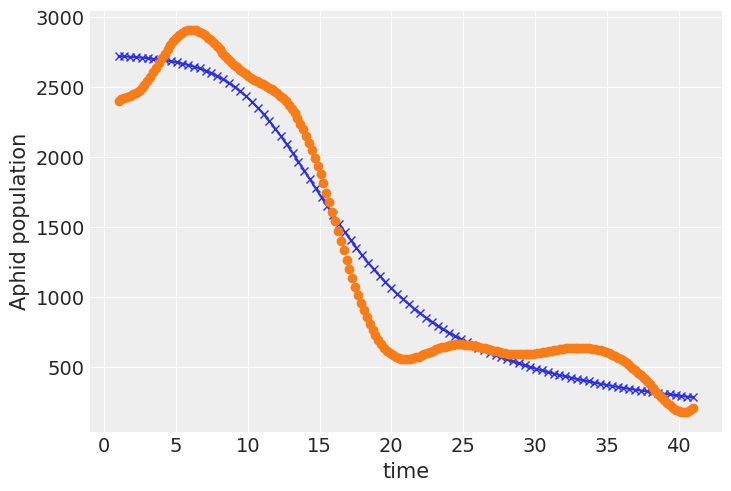

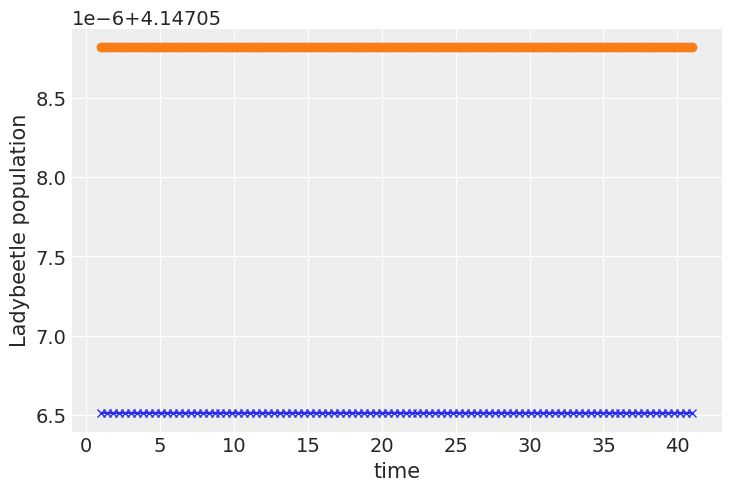

In [22]:
import matplotlib.pyplot as plt

aphid_observed = aphid_data[:].copy()
ladybeetle_observed = ladybeetle_data[:].copy()

plt.plot(t_computed_M14, u_M14, '-x')
plt.plot(time_list, aphid_density, 'o', label='Observed')

plt.xlabel('time')
plt.ylabel('Aphid population')
plt.show()

plt.plot(t_computed_M14, v_M14, '-x')
plt.plot(time_list, ladybeetle_density, 'o', label='Observed')
plt.xlabel('time')
plt.ylabel('Ladybeetle population')
plt.show()

## Sensitivity Analyses

### Least-Squares objective function

In [23]:
from SALib.sample.morris import sample as ee_sample

mean_values_params = [
    r2,
    r3,
    a21,
    a12,
]
factors_names = [
    r"$r2$",
    r"$r3$",
    r"$a21$",
    r"$a12$",
]
params_perturbations = 0.001
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [24]:
from tqdm import tqdm

num_of_realizations = parameter_values.shape[0]
qoi_sensitivity_outputs = np.zeros(num_of_realizations)

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    residual_least_squares_result = M14_least_squares_error_ode(
        parameters_realization,
        time_list,
        [u_data, v_data],
        M14_ode_solver,
        y0
    )
    
    qoi_sensitivity_outputs[realization_index] = residual_least_squares_result

100%|██████████| 20/20 [00:00<00:00, 1006.72it/s]


In [25]:
from SALib.analyze.morris import analyze as ee_analyze

data_time_list = time_list
num_of_experimental_points = data_time_list.shape[0]

df_Si = pd.DataFrame(columns=[*problem_info['names']])

Si = ee_analyze(problem_info, parameter_values, qoi_sensitivity_outputs, num_levels=grid_level, seed=seed)
Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
for idx, param_name in enumerate(problem_info['names']):
    df_Si.loc[0, param_name] = Si['mu_star_normalized'][idx]

df_Si = df_Si.T
df_Si.rename(columns={0: r'$\mu^*$'}, inplace=True)
df_Si.sort_values(by=r'$\mu^*$', ascending=False, inplace=True)
df_Si

$\mu^*$
$a21$    0.491474
$r3$     0.452709
$r2$    0.0487647
$a12$  0.00705158

<ipython-input-26-36a76a5f6096>:9: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


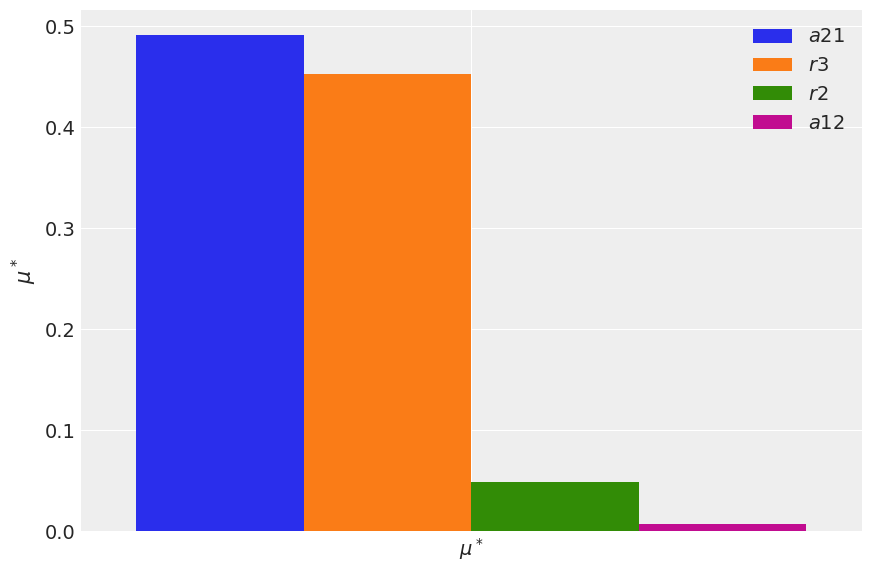

In [26]:
df_Si.T.plot.bar(rot=0, width=3, figsize=(9, 6))

plt.rcParams.update({'font.size': 16})

plt.ylabel(r"$\mu^*$")

plt.legend(fancybox=True, shadow=True)

plt.tight_layout()
#plt.savefig("img/sensitivity_least_squares_M14.png", dpi=300)
plt.show()

### Prey (pest) population

In [27]:
from SALib.sample.morris import sample as ee_sample

mean_values_params = [
    r2,
    r3,
    a21,
    a12,
]
factors_names = [
    r"$r2$",
    r"$r3$",
    r"$a21$",
    r"$a12$",
]
params_perturbations = 0.001
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [28]:
from tqdm import tqdm

t0 = time_list.min()
tf = time_list.max()
days_to_forecast = 0
time_list_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_list_points = time_list_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_list_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_M14 = M14_ode_solver(
        y0, 
        (t0, tf + days_to_forecast), 
        time_list_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_M14.y
    
    qoi_sensitivity_outputs[realization_index, :] = u_realization

100%|██████████| 20/20 [00:00<00:00, 1091.53it/s]


In [29]:
from SALib.analyze.morris import analyze as ee_analyze

df_Si = pd.DataFrame(columns=['time_list', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['time_list', *problem_info['names']])
df_Si['time_list'] = time_list_range
df_sigmai['time_list'] = time_list_range
for time_list_point in tqdm(range(num_of_time_list_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_list_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_list_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_list_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='time_list', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='time_list', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_time_lists = df_Si.time_list.values
df_Si

  0%|          | 0/100 [00:00<?, ?it/s]/home/tungdil/.local/lib/python3.8/site-packages/numpy/ma/core.py:864: RuntimeWarning: underflow encountered in multiply
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
100%|██████████| 100/100 [00:00<00:00, 441.48it/s]


time_list       $r2$      $r3$     $a21$       $a12$
0    1.404040   0.174406  0.484581  0.331234  0.00977887
1    1.808081   0.174406  0.484581  0.331234  0.00977887
2    2.212121  0.0599577  0.457641  0.477527  0.00487415
3    2.616162  0.0405194  0.480599  0.472552     0.00633
4    3.020202  0.0798067  0.504857  0.408078  0.00725849
..        ...        ...       ...       ...         ...
94  39.383838   0.056548  0.481761  0.451567    0.010124
95  39.787879  0.0558456  0.481571   0.45239   0.0101939
96  40.191919  0.0552999  0.481342  0.453094   0.0102645
97  40.595960  0.0549669   0.48107  0.453633   0.0103304
98  41.000000   0.054924  0.480794  0.453896   0.0103855

[99 rows x 5 columns]

In [30]:
df_sigmai

time_list      $r2$      $r3$     $a21$       $a12$
0    1.404040  0.288687  0.456156   0.25291  0.00224787
1    1.808081  0.288687  0.456156   0.25291  0.00224787
2    2.212121  0.246793  0.342444  0.408049  0.00271366
3    2.616162  0.253888  0.340888  0.399718  0.00550643
4    3.020202  0.369834  0.236453  0.389187  0.00452655
..        ...       ...       ...       ...         ...
94  39.383838  0.183568  0.411592  0.398161  0.00667934
95  39.787879  0.182841  0.413925   0.39657  0.00666363
96  40.191919   0.18242  0.416462  0.394455  0.00666348
97  40.595960  0.182552   0.41804  0.392739   0.0066694
98  41.000000  0.182975    0.4177  0.392662  0.00666367

[99 rows x 5 columns]

<ipython-input-31-fd21bd549561>:12: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


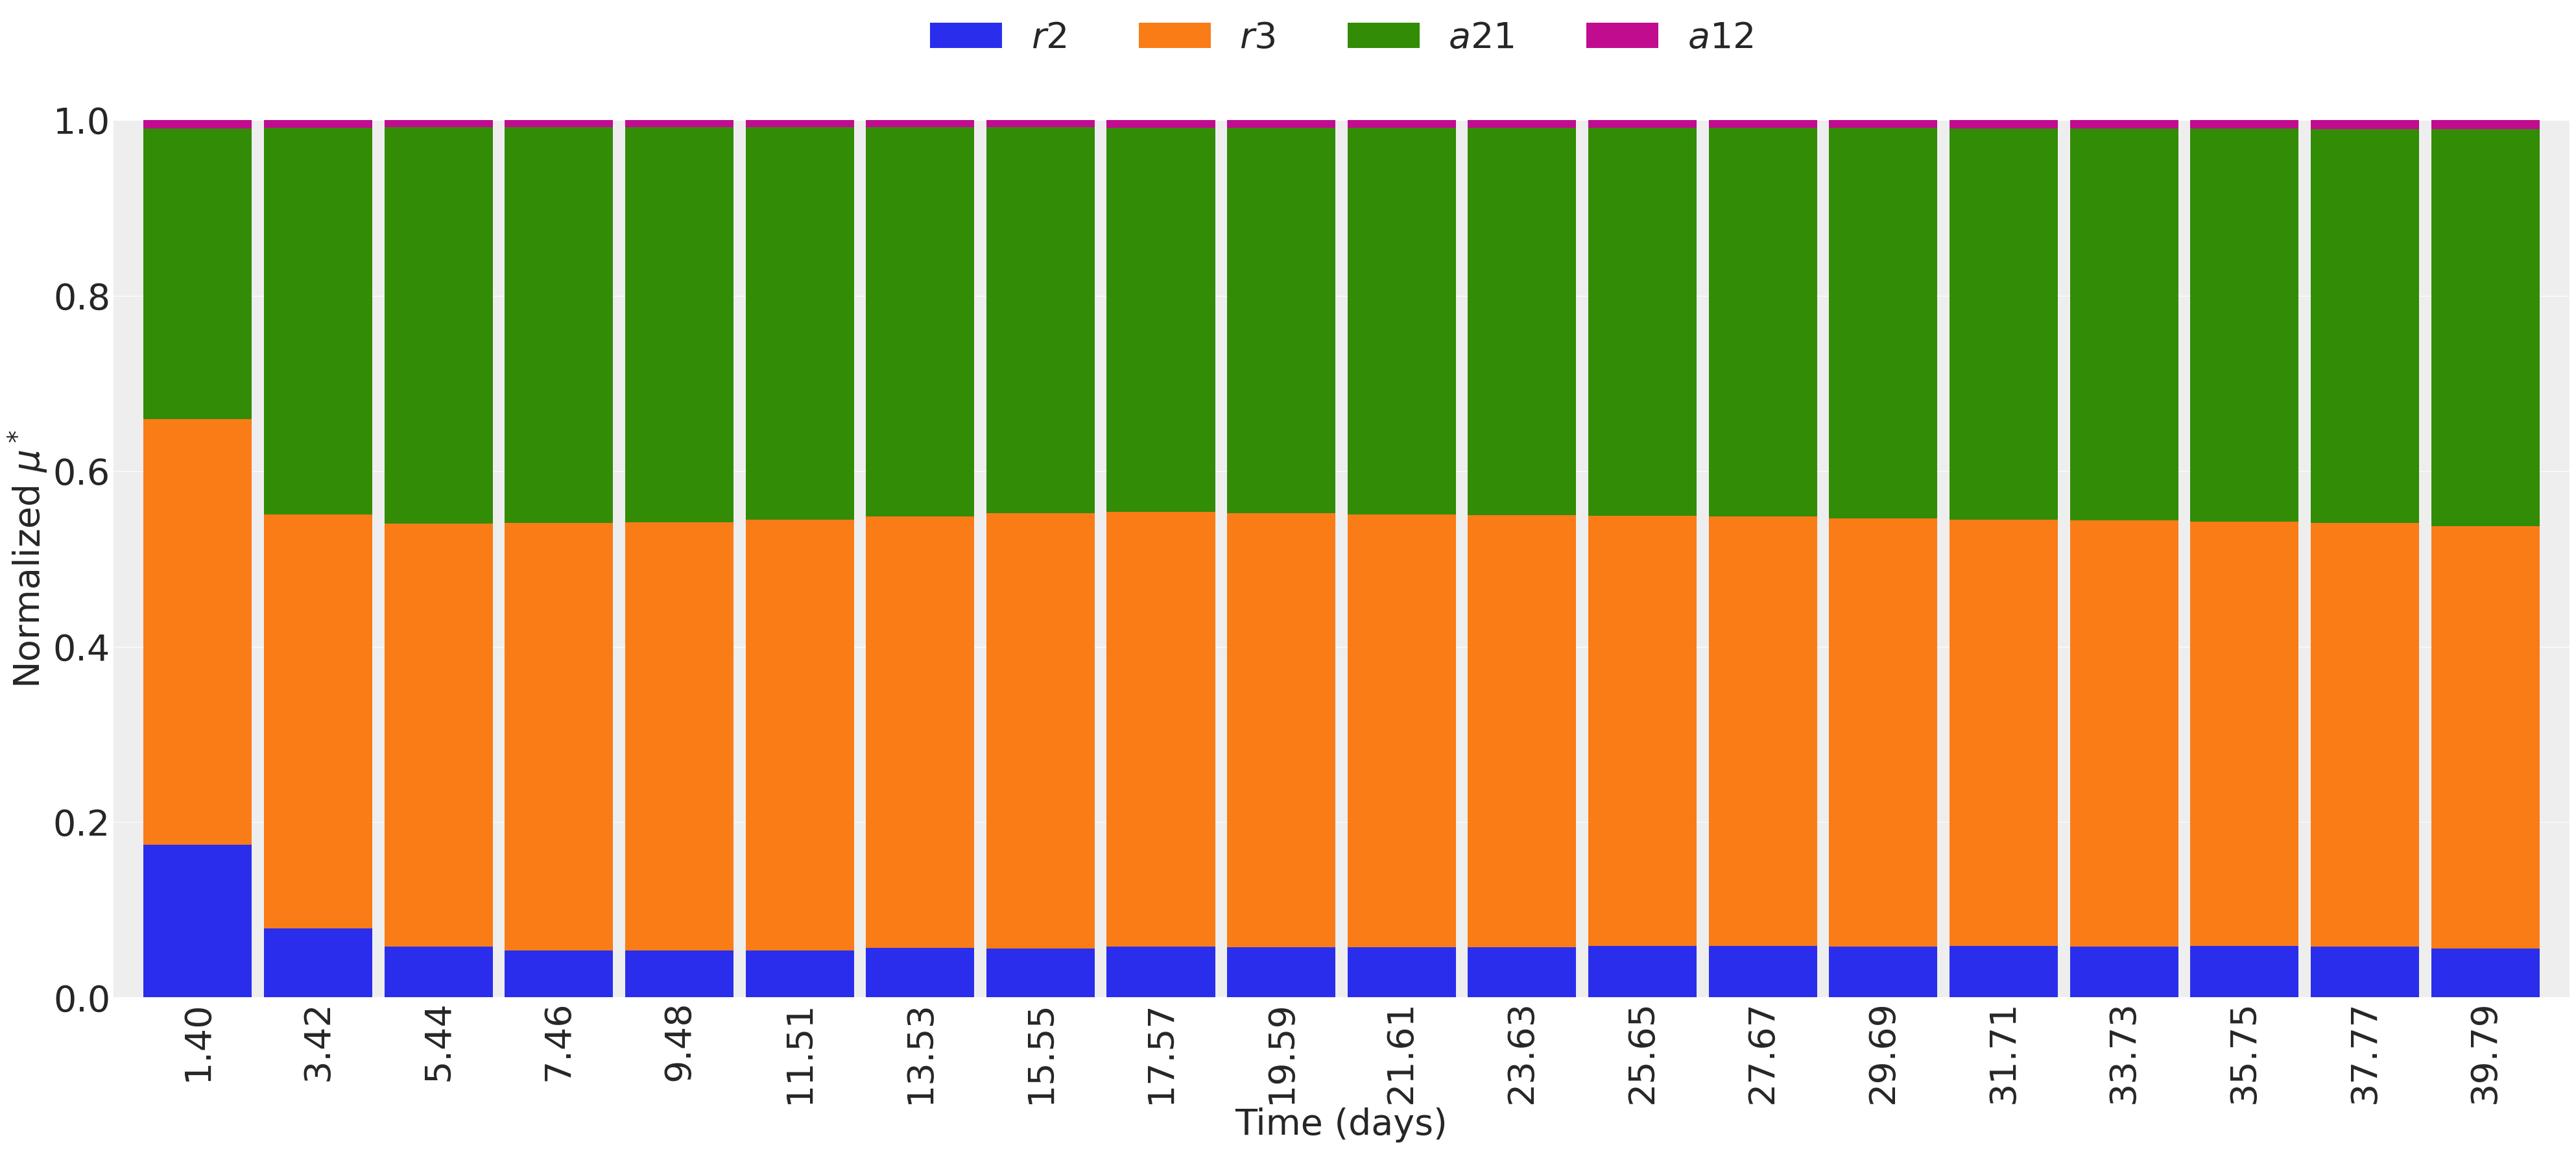

In [31]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 5
valid_time_lists_to_plot_mu = valid_time_lists[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='time_list', rot=90, width=0.9, figsize=(40, 18), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_time_lists_to_plot_mu[x]:.2f}")
plt.xlabel("Time (days)", fontsize = 40), plt.ylabel(r"Normalized $\mu^*$", fontsize = 40), plt.xticks(fontsize=40), plt.yticks(fontsize=40)

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True, fontsize=40)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_M14.png", dpi=300)
plt.show()

<ipython-input-32-efdb5593c7e4>:12: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


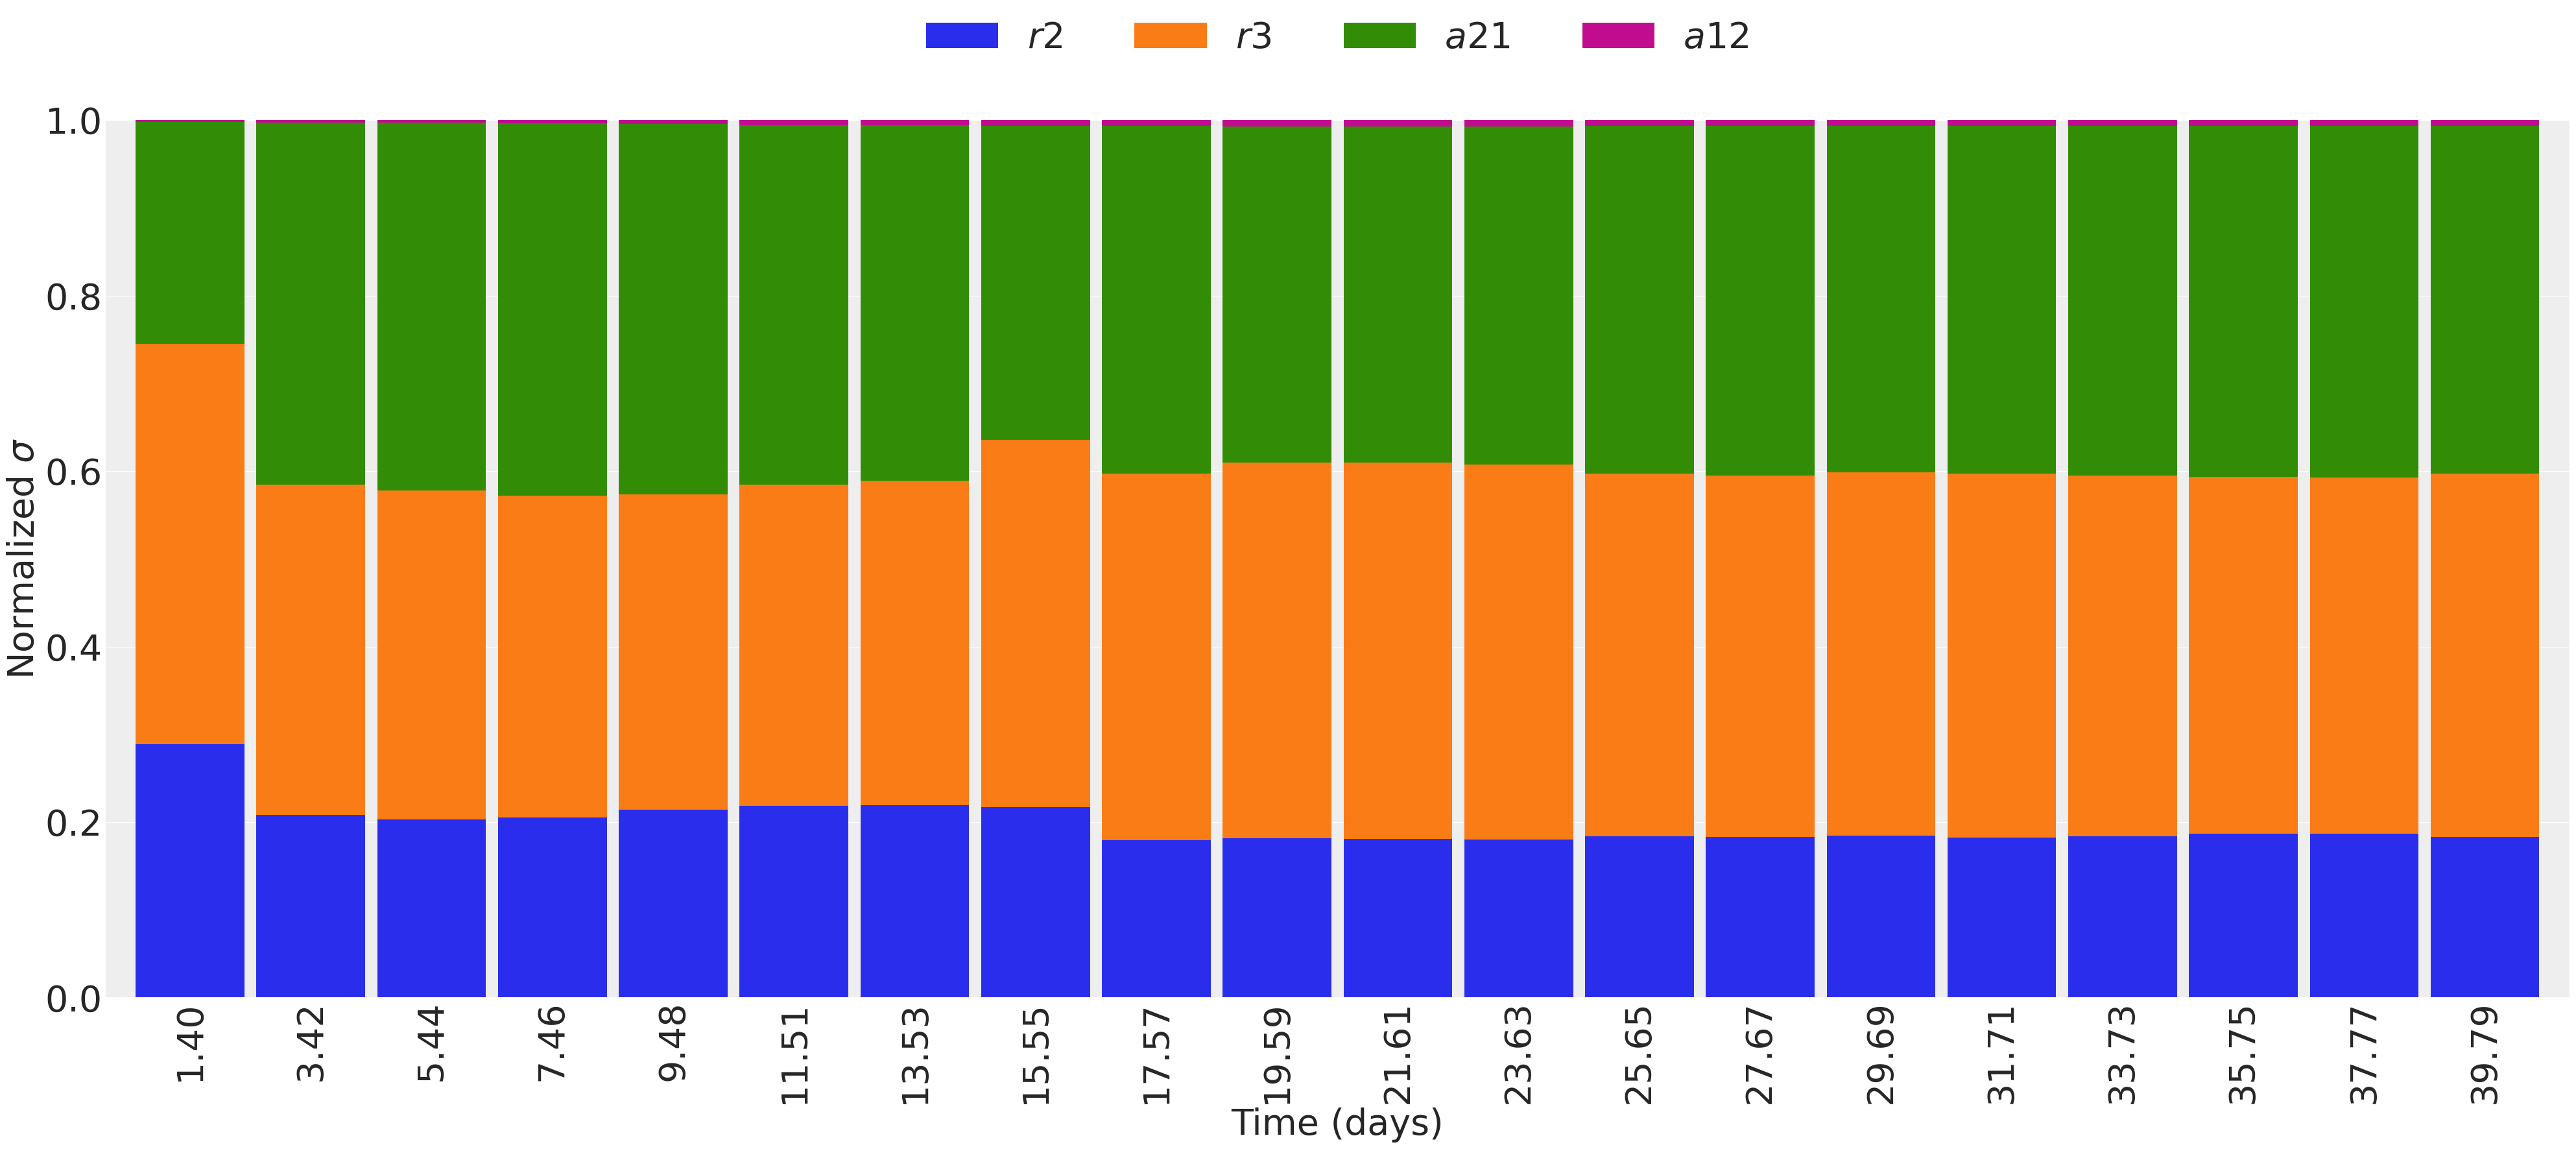

In [32]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 5
valid_time_lists_to_plot_sigma = valid_time_lists[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='time_list', rot=90, width=0.9, figsize=(40, 18), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_time_lists_to_plot_sigma[x]:.2f}")
plt.xlabel("Time (days)", fontsize = 40), plt.ylabel(r"Normalized $\sigma$", fontsize = 40), plt.xticks(fontsize=40), plt.yticks(fontsize=40)

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True, fontsize=40)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma_M14.png", dpi=300)
plt.show()

### time-derivative of pest (prey) population

In [33]:
def calculate_pest_time_list_derivative_series(
    time_list_array, 
    u_array, 
    v_array, 
    ode_model,
    model_pars
):
    pest_time_list_derivative_values = list()
    for t_idx, time_list in enumerate(time_list_array):
        u = u_array[t_idx]
        v = v_array[t_idx]
        stacked_population = [u, v]
        pest_time_list_derivative_value, _ = ode_model(time_list, stacked_population, *model_pars)
        pest_time_list_derivative_values.append(pest_time_list_derivative_value)
        
    pest_time_list_derivative_array = np.array(pest_time_list_derivative_values)
    return pest_time_list_derivative_array

In [34]:
pest_time_list_derivative_array = calculate_pest_time_list_derivative_series(
    t_computed_M14,
    u_M14,
    v_M14,
    M14_model,
    mean_values_params
)

pest_time_list_derivative_array

/home/tungdil/.local/lib/python3.8/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'X' of function 'M14_model'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-18-6b72f42c493d>", line 10:
@jit(nopython=True)
def M14_model(
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


array([  -4.70315218,   -5.60517924,   -6.50411426,   -7.39996119,
         -8.70246555,  -10.10341957,  -12.36074156,  -14.05190087,
        -16.0423182 ,  -18.40767152,  -21.17604932,  -24.3327249 ,
        -27.88728462,  -31.99380717,  -36.65063253,  -41.81758477,
        -47.52783399,  -53.91419486,  -60.9014412 ,  -68.39529134,
        -76.39742762,  -84.87318968,  -93.66570955, -102.60782211,
       -111.52043954, -120.22038777, -128.5249299 , -136.25023777,
       -143.13649757, -149.00371396, -153.7679451 , -157.35400613,
       -159.67211815, -160.72344287, -160.56232061, -159.26745773,
       -156.96304128, -153.77022486, -149.80354566, -145.31022803,
       -140.33796178, -135.01574333, -129.46695327, -123.81271227,
       -118.16648077, -112.58440535, -107.10685473, -101.78095596,
        -96.64345714,  -91.70874006,  -86.98901546,  -82.4932424 ,
        -78.22506707,  -74.18223478,  -70.36064569,  -66.75391137,
        -63.35550565,  -60.15870589,  -57.15360732,  -54.32948

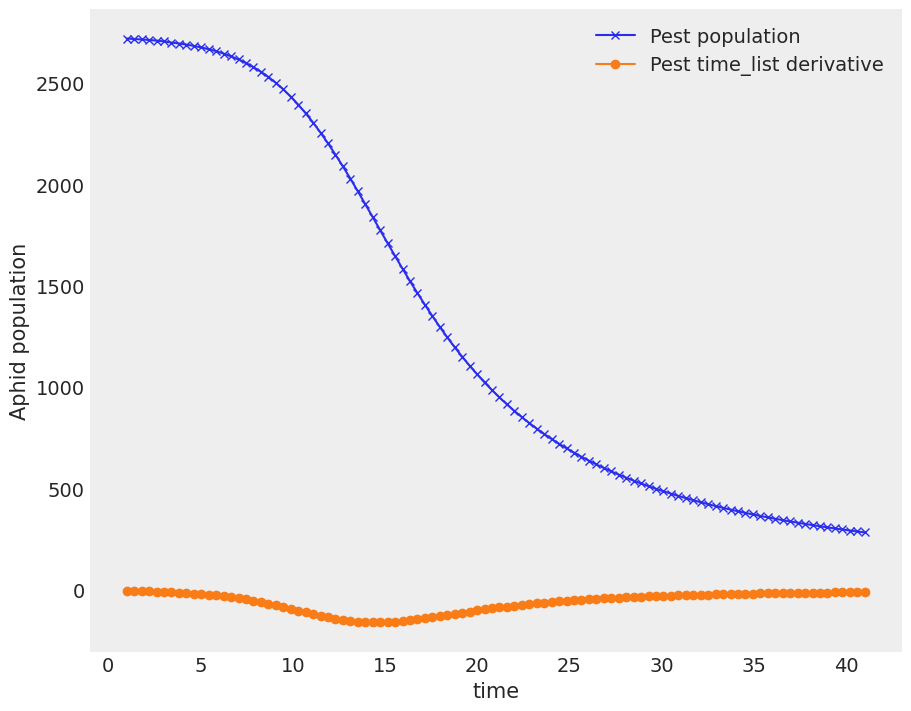

In [35]:
plt.figure(figsize=(9, 7))

plt.plot(t_computed_M14, u_M14, '-x', label='Pest population')
plt.plot(t_computed_M14, pest_time_list_derivative_array, '-o', label='Pest time_list derivative')

plt.xlabel('time')
plt.ylabel('Aphid population')

plt.grid()
plt.legend(shadow=True)

#plt.savefig("img/pest_derivative_M14.png", dpi=300)
plt.show()

In [36]:
mean_values_params = [
    r2,
    r3,
    a21,
    a12,
]
factors_names = [
    r"$r2$",
    r"$r3$",
    r"$a21$",
    r"$a12$",
]
params_perturbations = 0.001
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [37]:
t0 = time_list.min()
tf = time_list.max()
days_to_forecast = 0
time_list_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_list_points = time_list_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_list_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_M14 = M14_ode_solver(
        y0, 
        (t0, tf + days_to_forecast), 
        time_list_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_M14.y
    
    pest_time_list_derivative_array = calculate_pest_time_list_derivative_series(
        time_list_range,
        u_realization,
        v_realization,
        M14_model,
        parameters_realization
    )
    
    qoi_sensitivity_outputs[realization_index, :] = pest_time_list_derivative_array

100%|██████████| 20/20 [00:00<00:00, 685.75it/s]


In [38]:
df_Si = pd.DataFrame(columns=['time_list', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['time_list', *problem_info['names']])
df_Si['time_list'] = time_list_range
df_sigmai['time_list'] = time_list_range
for time_list_point in tqdm(range(num_of_time_list_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_list_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_list_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_list_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='time_list', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='time_list', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_time_lists = df_Si.time_list.values
df_Si

  0%|          | 0/100 [00:00<?, ?it/s]/home/tungdil/.local/lib/python3.8/site-packages/numpy/ma/core.py:864: RuntimeWarning: underflow encountered in multiply
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
100%|██████████| 100/100 [00:00<00:00, 492.02it/s]


time_list       $r2$      $r3$     $a21$       $a12$
0    1.404040  0.0359058  0.502445  0.454656  0.00699228
1    1.808081  0.0526675  0.499985  0.440006  0.00734105
2    2.212121  0.0369009  0.481441  0.475927  0.00573045
3    2.616162  0.0276549  0.492373  0.473509  0.00646313
4    3.020202  0.0560743  0.501724   0.43527  0.00693089
..        ...        ...       ...       ...         ...
94  39.383838  0.0569566   0.49031  0.444245  0.00848836
95  39.787879  0.0562363  0.490212  0.445041  0.00851081
96  40.191919  0.0556765  0.490072  0.445718  0.00853347
97  40.595960  0.0553348  0.489886  0.446228  0.00855148
98  41.000000  0.0552912  0.489688  0.446461  0.00855945

[99 rows x 5 columns]

In [39]:
df_sigmai

time_list      $r2$      $r3$     $a21$       $a12$
0    1.404040  0.288584  0.457191  0.251975  0.00225054
1    1.808081  0.288516  0.457359  0.251875  0.00225016
2    2.212121  0.245588  0.344944  0.406739  0.00272919
3    2.616162  0.250337   0.34892  0.395243  0.00550041
4    3.020202  0.364329  0.246134  0.384982  0.00455549
..        ...       ...       ...       ...         ...
94  39.383838  0.179665  0.425346  0.388194  0.00679437
95  39.787879  0.179048  0.427309  0.386863  0.00677983
96  40.191919  0.178713  0.429526  0.384981  0.00678035
97  40.595960  0.178889   0.43088  0.383445  0.00678592
98  41.000000  0.179333  0.430421  0.383466  0.00677929

[99 rows x 5 columns]

<ipython-input-40-0073c2d850ec>:12: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


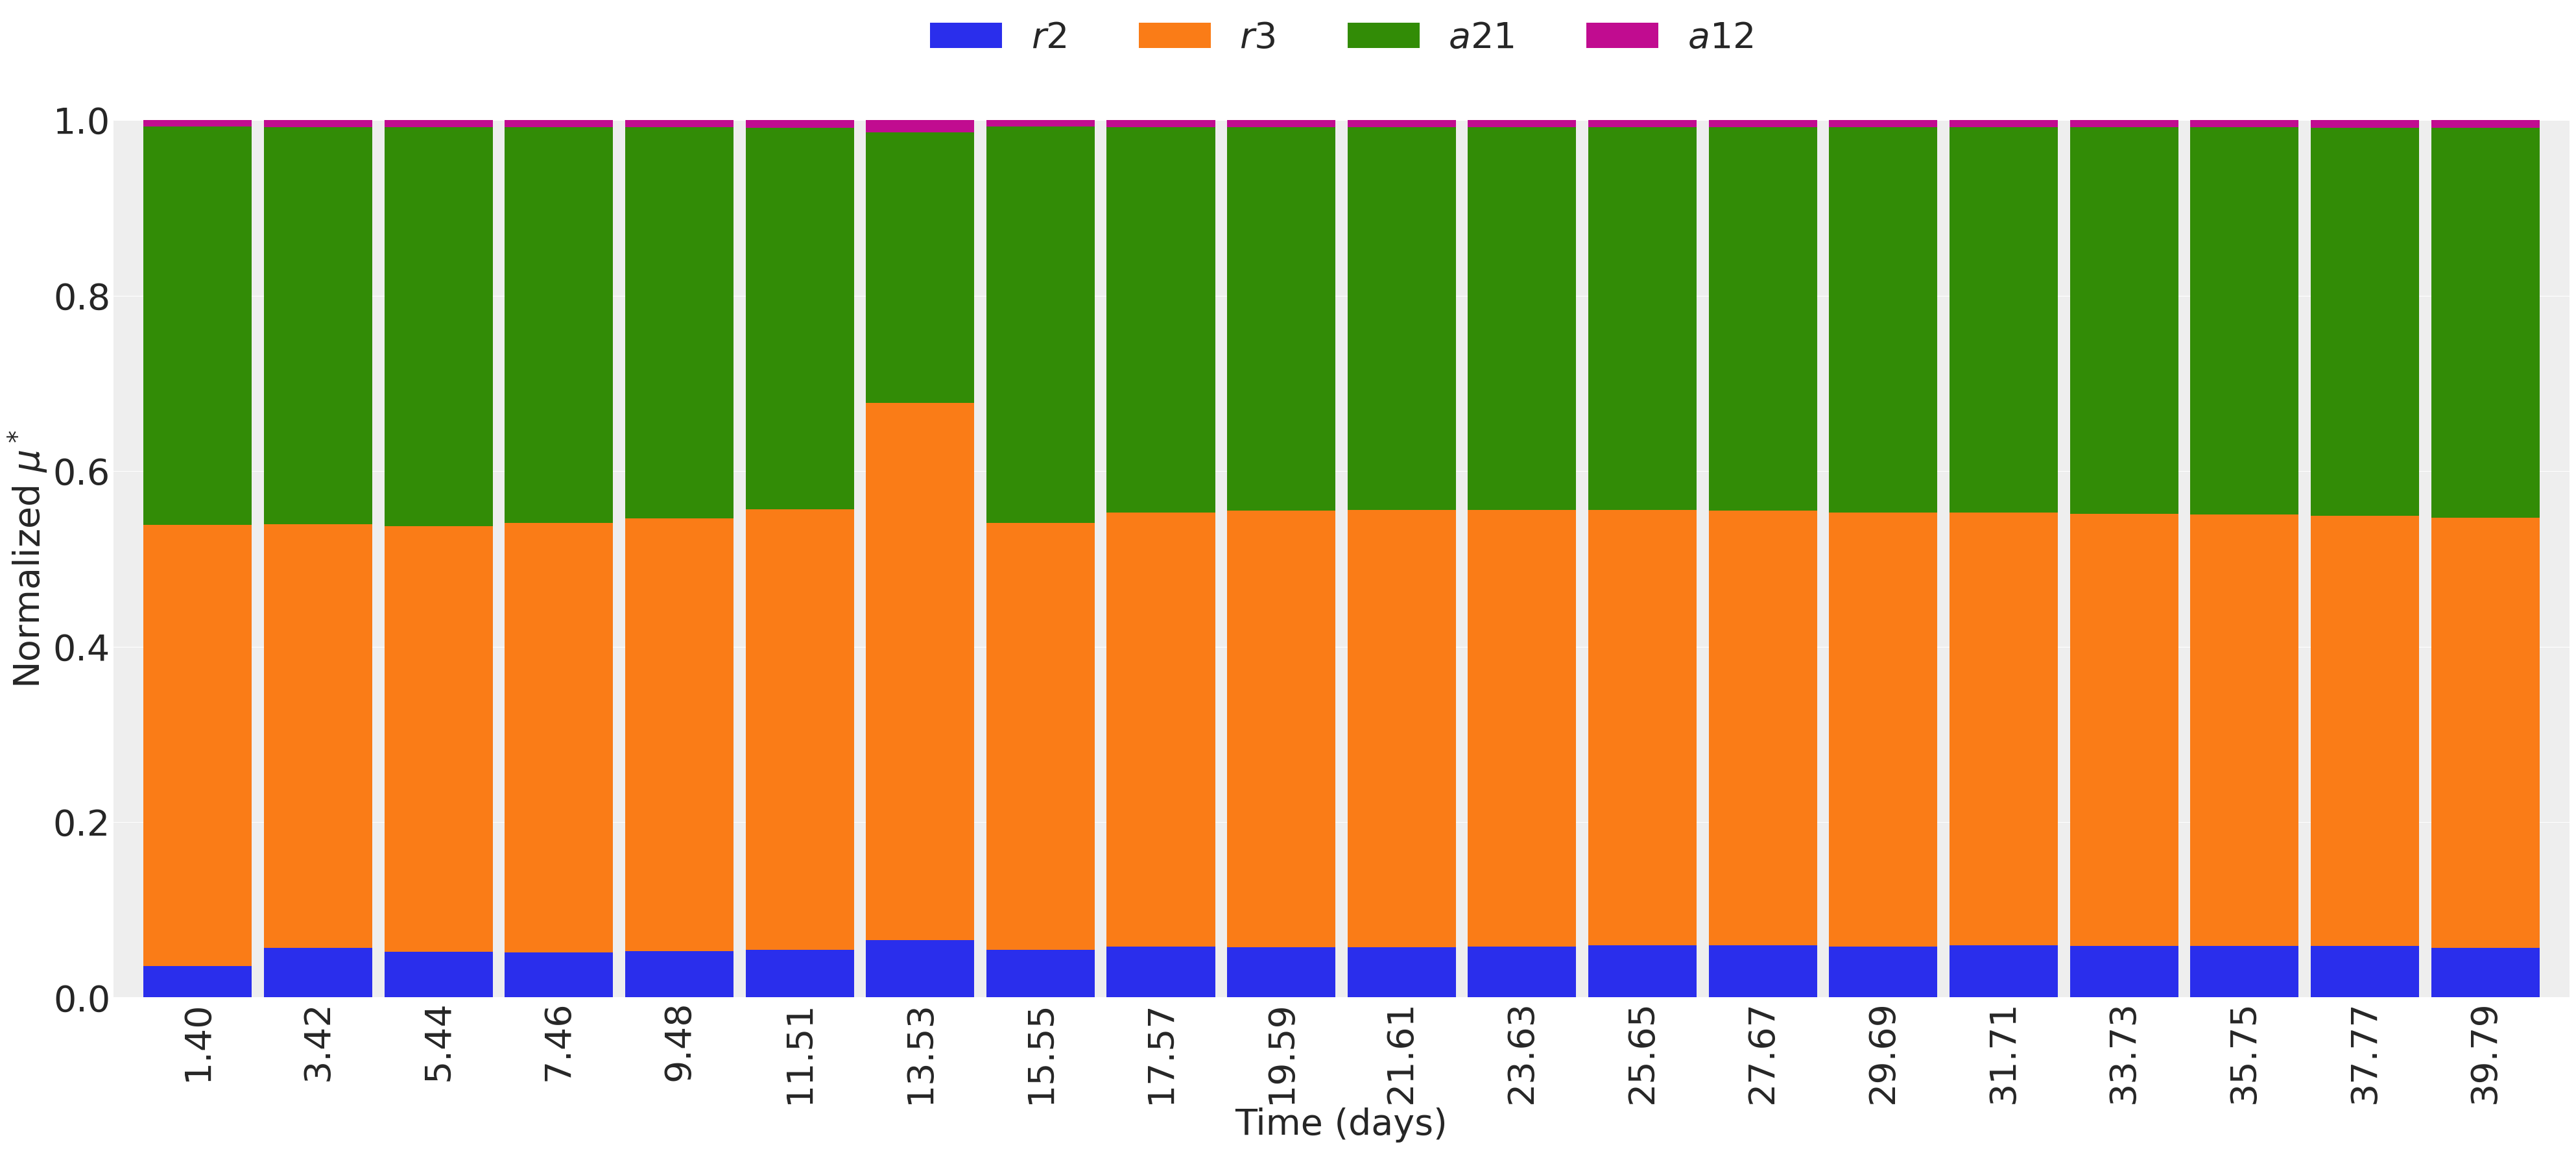

In [40]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 5
valid_time_lists_to_plot_mu = valid_time_lists[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='time_list', rot=90, width=0.9, figsize=(40, 18), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_time_lists_to_plot_mu[x]:.2f}")
plt.xlabel("Time (days)", fontsize = 40), plt.ylabel(r"Normalized $\mu^*$", fontsize = 40), plt.xticks(fontsize=40), plt.yticks(fontsize=40)

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True, fontsize=40)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_derivative_M14.png", dpi=300)
plt.show()

<ipython-input-41-d6d804e16224>:12: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


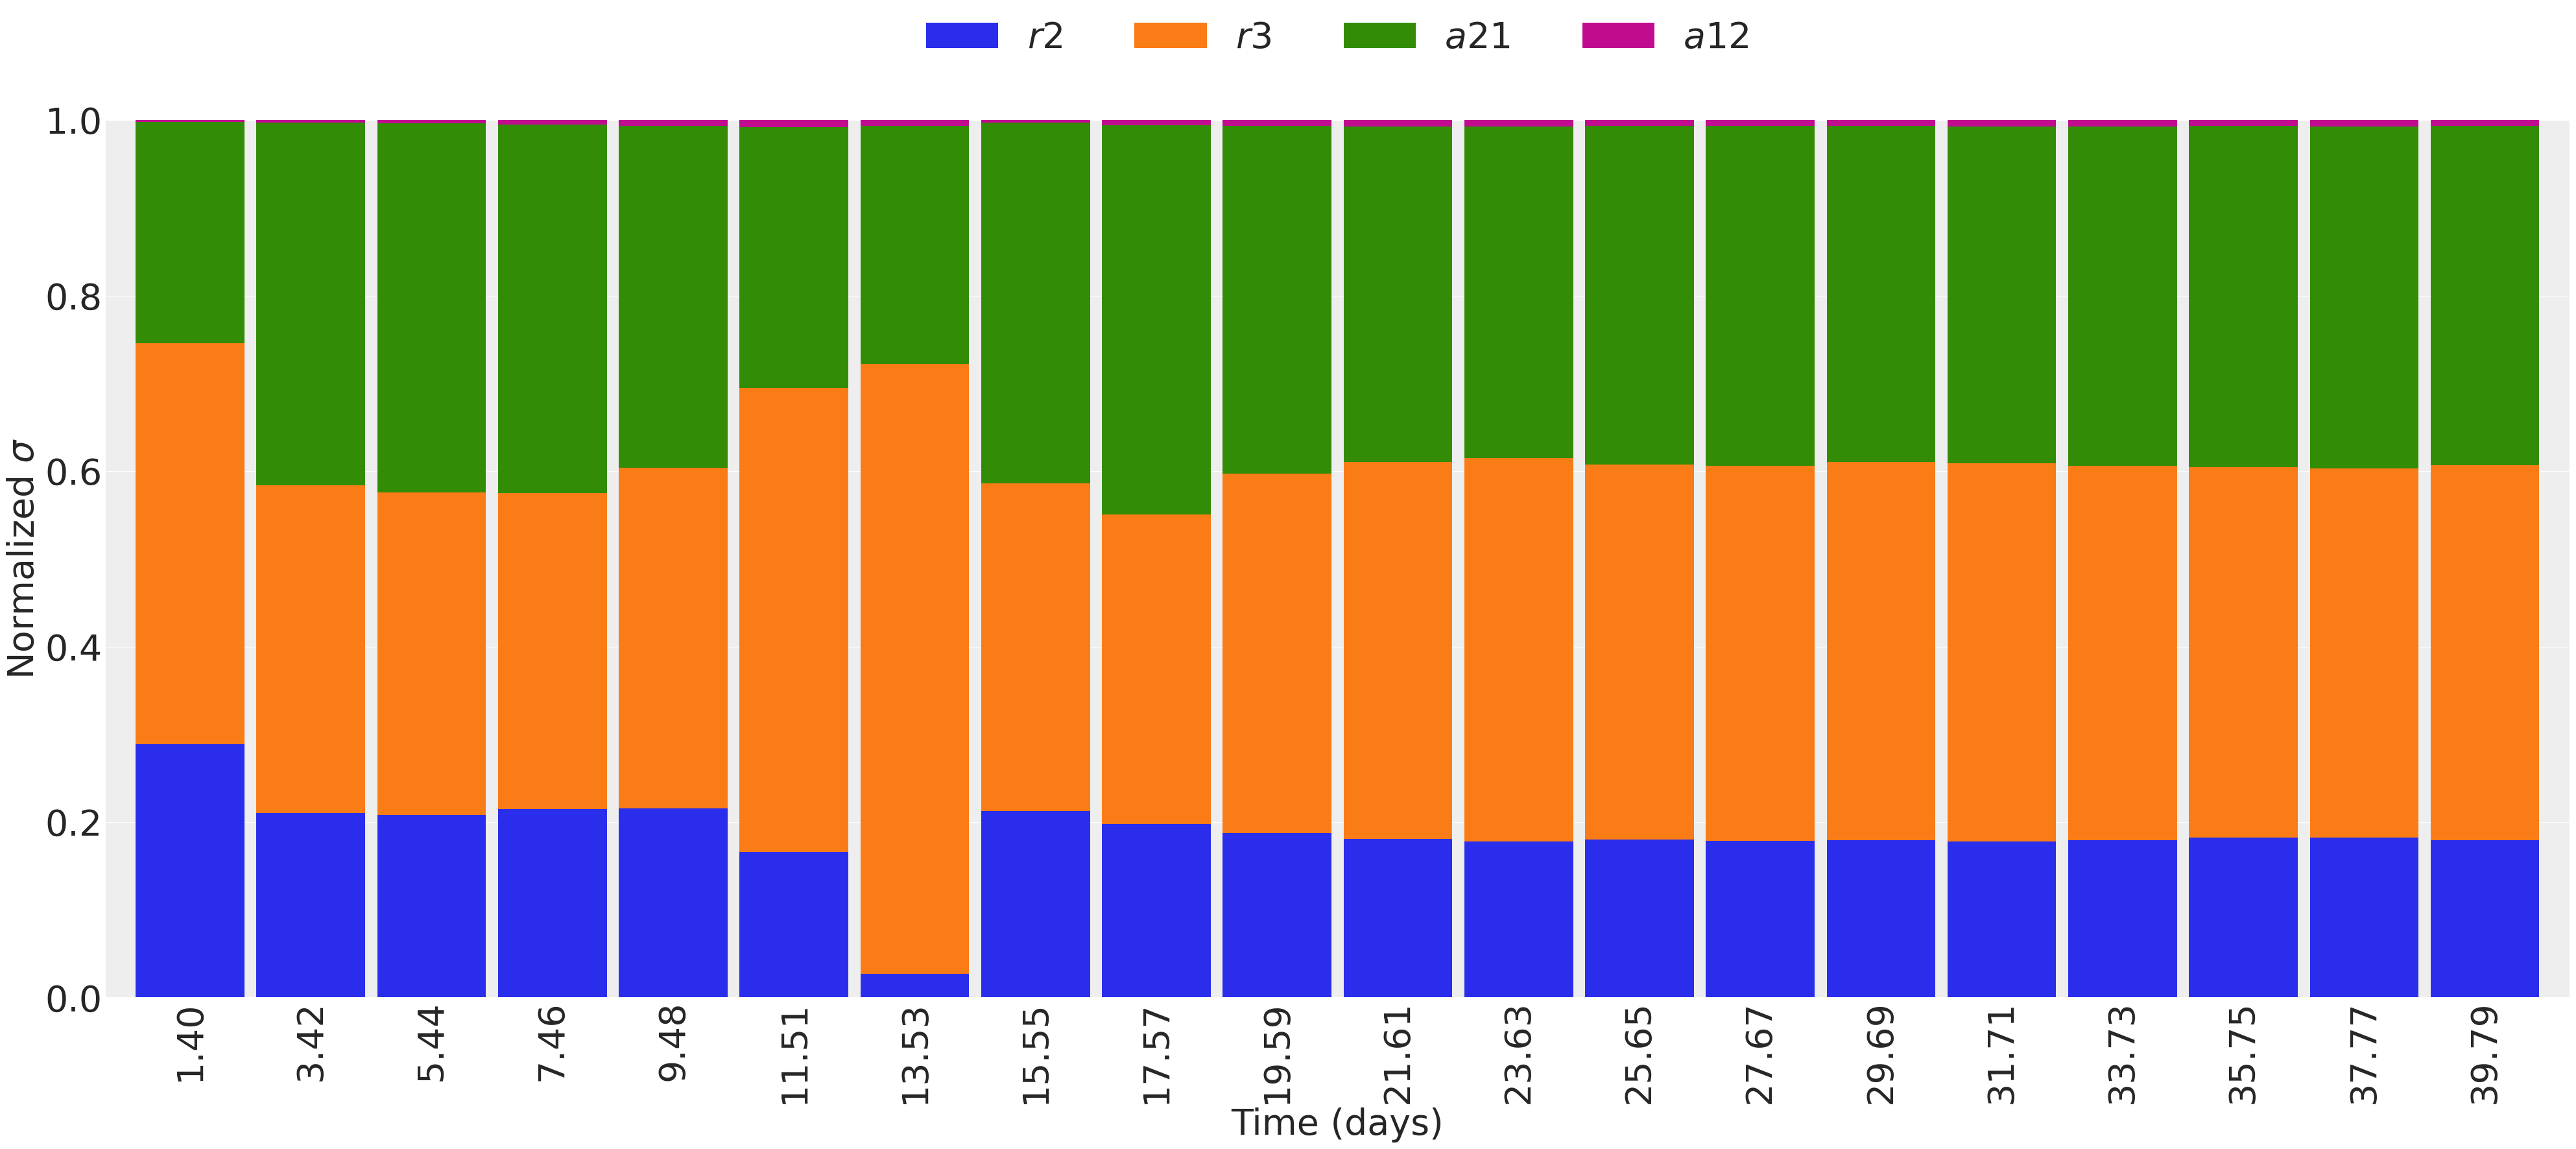

In [41]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 5
valid_time_lists_to_plot_sigma = valid_time_lists[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='time_list', rot=90, width=0.9, figsize=(40, 18), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_time_lists_to_plot_sigma[x]:.2f}")
plt.xlabel("Time (days)", fontsize = 40), plt.ylabel(r"Normalized $\sigma$", fontsize = 40), plt.xticks(fontsize=40), plt.yticks(fontsize=40)

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True, fontsize=40)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma_derivative_M14.png", dpi=300)
plt.show()

## Bayesian calibration

In [42]:
@theano.compile.ops.as_op(
    itypes=[
        t.dvector, 
        t.dscalar,  # r2
        t.dscalar,  # r3
        t.dscalar,  # a21
        t.dscalar,  # a12
        t.dscalar,  # u0
        t.dscalar,  # v0
    ], 
    otypes=[t.dmatrix]
)
def M14_ode_wrapper(time_list_exp, r2,r3,a21,a12, u0, v0):
    time_list_span = (time_list_exp.min(), time_list_exp.max())

    args = [r2,r3,a21,a12]
    initial_conditions = np.array([u0, v0])
    y_model = solve_ivp(
        M14_model, 
        time_list_span, 
        initial_conditions, 
        t_eval=time_list_exp, 
        method='LSODA',
        args=args
    )
    simulated_time_list = y_model.t
    simulated_ode_solution = y_model.y
    simulated_qoi1, simulated_qoi2 = simulated_ode_solution

    concatenate_simulated_qoi = np.vstack([simulated_qoi1, simulated_qoi2]).T

    return concatenate_simulated_qoi

In [43]:
observed_aphids = aphid_density.astype(np.float64)
observed_ladybeetles = ladybeetle_density.astype(np.float64)
observations_to_fit = np.vstack([observed_aphids, observed_ladybeetles]).T  # note the transpose here
time_observations = time_list.astype(np.float64)

print("\n*** Performing Bayesian calibration ***")

print("-- Running Monte Carlo simulations:")
start_time = time.time()
percent_calibration = 0.01

with pm.Model() as fine_model_M14:
    # Prior distributions for the model's parameters    
    r2_ = pm.Data("r2", 7.712286116072414e-06)
    r3_ = pm.Uniform(
        "r3",
        lower=5.2e-8,#(1.0 - percent_calibration) * 5.2264665899163776e-08,#r3,#
        upper=5.35e-8,#(1.0 + 3.0*percent_calibration) * 5.2264665899163776e-08,#r3,#
    )
    a21_ = pm.Uniform(
        "a21",
        lower=0.000032, #(1.0 - 1.5*percent_calibration) * 3.212465447661946e-05,# a21,#
        upper=0.0000334, #(1.0 + 2.0*percent_calibration) * 3.212465447661946e-05,# a21,#
    )
    a12_ = pm.Data("a12", 0.00029023981892152757)
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=0, upper=1000, shape=2)  # note 'shape' here

    # Wrapper for time_list. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "M14_model",
        M14_ode_wrapper(
            time_calibration,
            r2_,
            r3_,
            a21_,
            a12_,
            u0_,
            v0_
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit
    )
    
coarse_steps_1 = 4
observed_aphids_coarse_1 = observed_aphids[::coarse_steps_1]
observed_ladybeetles_coarse_1 = observed_ladybeetles[::coarse_steps_1]
observations_to_fit_coarse_1 = np.vstack(
    [observed_aphids_coarse_1, observed_ladybeetles_coarse_1]
).T
time_observations_coarse_1 = time_observations[::coarse_steps_1]

with pm.Model() as coarse_model_1:
    # Prior distributions for the model's parameters
    r2_ = pm.Data("r2", 7.712286116072414e-06)
    r3_ = pm.Uniform(
        "r3",
        lower=5.2e-8,#(1.0 - percent_calibration) * 5.2264665899163776e-08,#r3,#
        upper=5.35e-8,#(1.0 + 3.0*percent_calibration) * 5.2264665899163776e-08,#r3,#
    )
    a21_ = pm.Uniform(
        "a21",
        lower=0.000032, #(1.0 - 1.5*percent_calibration) * 3.212465447661946e-05,# a21,#
        upper=0.0000334, #(1.0 + 2.0*percent_calibration) * 3.212465447661946e-05,# a21,#
    )
    a12_ = pm.Data("a12", 0.00029023981892152757)
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=0, upper=1000, shape=2)  # note 'shape' here

    # Wrapper for time_list. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations_coarse_1)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "M14_model",
        M14_ode_wrapper(
            time_calibration,
            r2_,
            r3_,
            a21_,
            a12_,
            u0_,
            v0_
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit_coarse_1
    )


with fine_model_M14:
    step = pm.MLDA(coarse_models=[coarse_model_1], subsampling_rates=[5])
#     step = pm.DEMetropolisZ()
    trace_calibration_M14 = pm.sample(draws=6000, chains=6, cores=6, step=step, random_seed=seed, tune=2000)#, start={'r3': (5.2264665899163776e-08), 'a21': (3.212465447661946e-05), 'std_deviation': np.array([220.,2e-06])})

duration = time.time() - start_time

print(f"-- Monte Carlo simulations done in {duration / 60:.3f} minutes")


*** Performing Bayesian calibration ***
-- Running Monte Carlo simulations:


/home/tungdil/.local/lib/python3.8/site-packages/pymc3/step_methods/mlda.py:385: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  warnings.warn(
/home/tungdil/.local/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Multiprocess sampling (6 chains in 6 jobs)
MLDA: [std_deviation, a21, r3]


/home/tungdil/.local/lib/python3.8/site-packages/pymc3/step_methods/metropolis.py:849: RuntimeWarning: underflow encountered in exp
  "accept": np.exp(accept),
/home/tungdil/.local/lib/python3.8/site-packages/pymc3/step_methods/metropolis.py:849: RuntimeWarning: underflow encountered in exp
  "accept": np.exp(accept),
/home/tungdil/.local/lib/python3.8/site-packages/pymc3/step_methods/mlda.py:770: RuntimeWarning: overflow encountered in exp
  stats = {"tune": self.tune, "accept": np.exp(accept), "accepted": accepted}
/home/tungdil/.local/lib/python3.8/site-packages/pymc3/step_methods/metropolis.py:849: RuntimeWarning: underflow encountered in exp
  "accept": np.exp(accept),
/home/tungdil/.local/lib/python3.8/site-packages/pymc3/step_methods/metropolis.py:849: RuntimeWarning: underflow encountered in exp
  "accept": np.exp(accept),
/home/tungdil/.local/lib/python3.8/site-packages/pymc3/step_methods/metropolis.py:849: RuntimeWarning: underflow encountered in exp
  "accept": np.exp(accept

-- Monte Carlo simulations done in 8.215 minutes


In [44]:
calibration_variable_names = [
    "std_deviation",
    "r3",
    "a21",
]

  0%|          | 0/3 [00:00<?, ?it/s]/home/tungdil/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/tungdil/.local/lib/python3.8/site-packages/arviz/stats/density_utils.py:241: RuntimeWarning: underflow encountered in exp
  f = np.sum(np.power(k_sq, l) * a_sq * np.exp(-k_sq * np.pi ** 2 * t))
/home/tungdil/.local/lib/python3.8/site-packages/arviz/stats/density_utils.py:249: RuntimeWarning: underflow encountered in exp
  f = np.sum(k_sq ** j * a_sq * np.exp(-k_sq * np.pi ** 2.0 * t_j))
/home/tungdil/.local/lib/python3.8/site-packages/arviz/stats/density_utils.py:249: RuntimeWarning: underflow encountered in multiply
  f = np.sum(k_sq ** j * a_sq * np.exp(-k_sq * np.pi ** 2.0 * t_j))
/home/tungdil/.local/lib/pytho

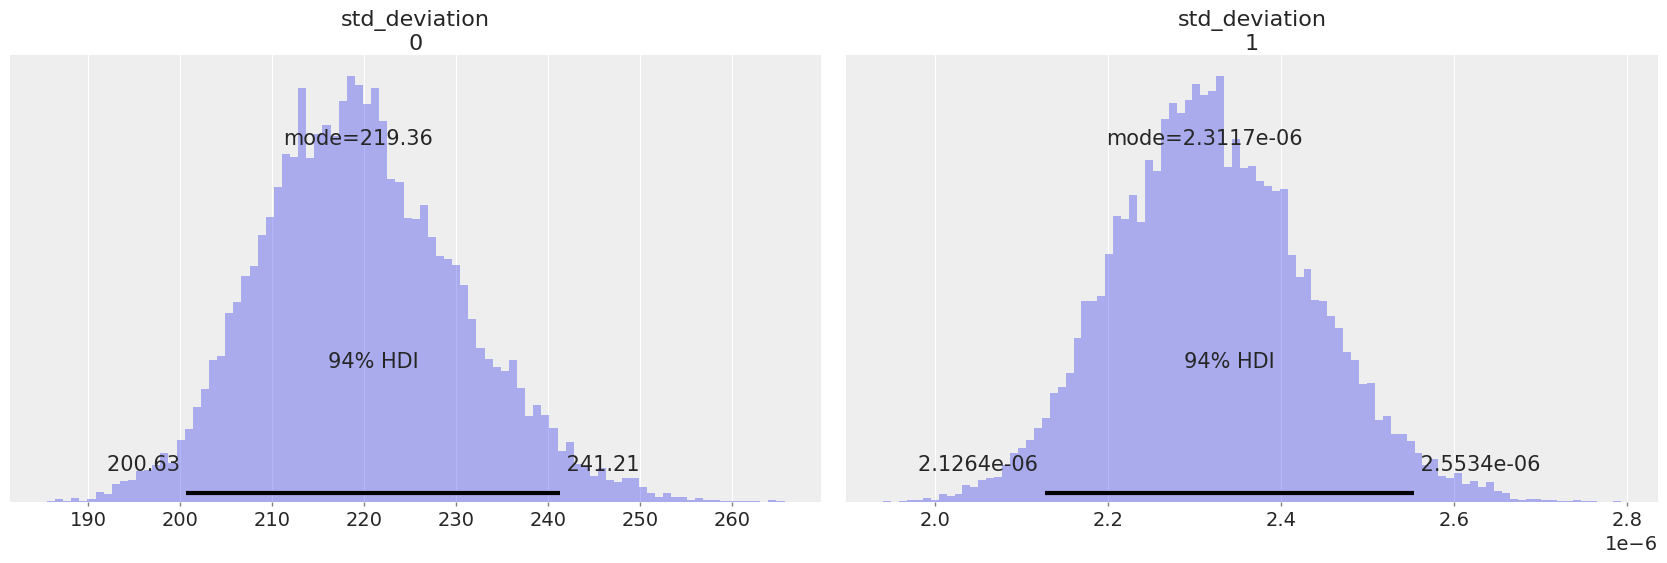

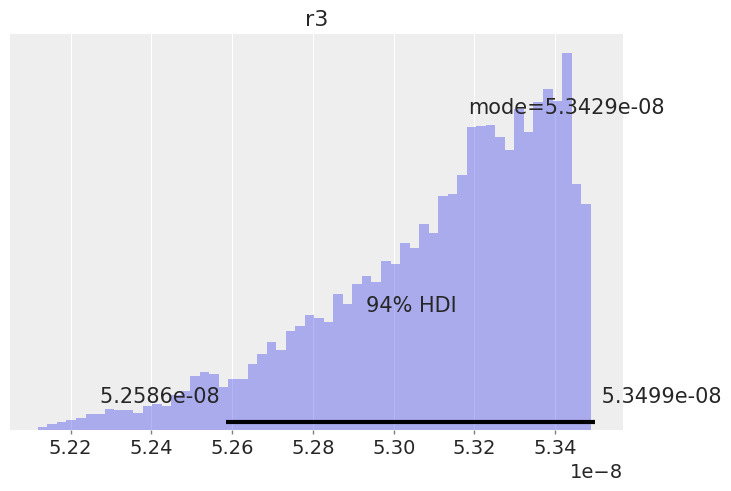

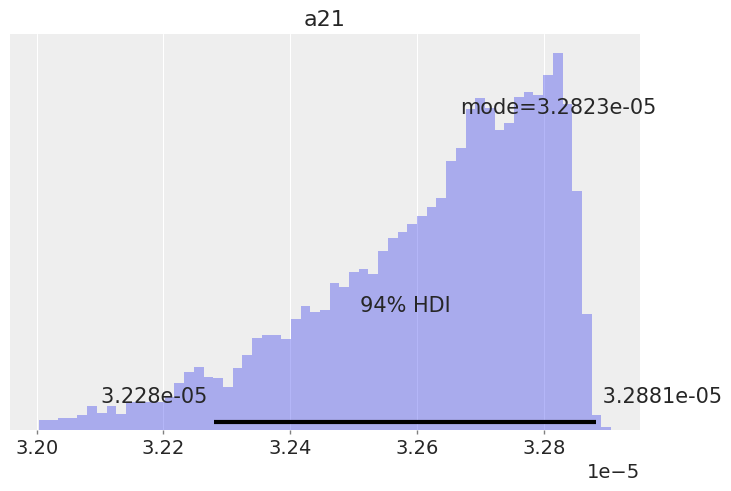

In [45]:
plot_step = 1
progress_bar = tqdm(calibration_variable_names)
for variable in progress_bar:
    pm.plot_posterior(
        trace_calibration_M14[::plot_step], 
        var_names=(f"{variable}"), 
        kind="hist", 
        round_to=5,
        point_estimate="mode"
    )
    plt.savefig(f"img/posterior_cal_{variable}_M14.png")

/home/tungdil/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/tungdil/.local/lib/python3.8/site-packages/arviz/stats/density_utils.py:241: RuntimeWarning: underflow encountered in exp
  f = np.sum(np.power(k_sq, l) * a_sq * np.exp(-k_sq * np.pi ** 2 * t))
/home/tungdil/.local/lib/python3.8/site-packages/arviz/stats/density_utils.py:249: RuntimeWarning: underflow encountered in exp
  f = np.sum(k_sq ** j * a_sq * np.exp(-k_sq * np.pi ** 2.0 * t_j))
/home/tungdil/.local/lib/python3.8/site-packages/arviz/stats/density_utils.py:249: RuntimeWarning: underflow encountered in multiply
  f = np.sum(k_sq ** j * a_sq * np.exp(-k_sq * np.pi ** 2.0 * t_j))
/home/tungdil/.local/lib/python3.8/site-packages/arviz/stats/densit

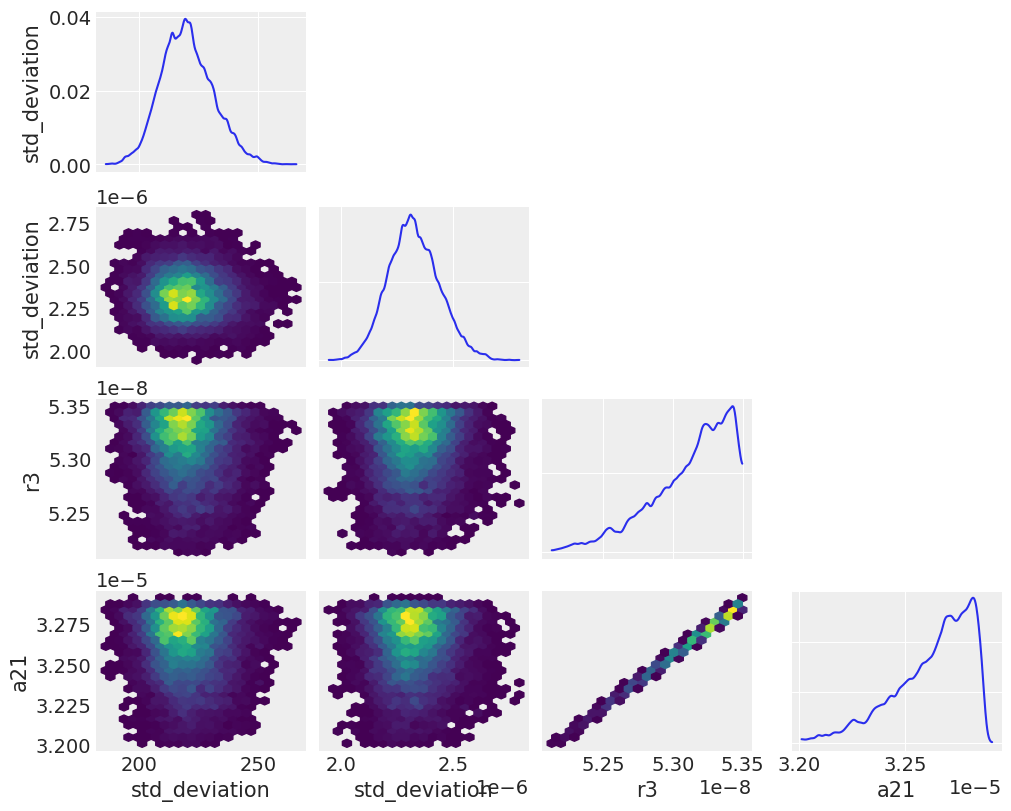

In [46]:
az.plot_pair(
    trace_calibration_M14,
    var_names=calibration_variable_names,
    kind="hexbin",
    fill_last=False,
    marginals=True,
    figsize=(10, 8),
)
plt.savefig("img/marginals_cal_M14.png")

In [47]:
df_stats_summary = az.summary(
    data=trace_calibration_M14,
    var_names=calibration_variable_names,
    kind='stats',
    round_to=15,  # rounding level display
)

df_stats_summary

/home/tungdil/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean            sd        hdi_3%       hdi_97%
std_deviation[0]  2.200877e+02  1.088419e+01  2.006290e+02  2.412092e+02
std_deviation[1]  2.326034e-06  1.136467e-07  2.126390e-06  2.553450e-06
r3                5.312158e-08  2.826100e-10  5.258572e-08  5.349900e-08
a21               3.263125e-05  1.826105e-07  3.228039e-05  3.288148e-05

In [48]:
from scipy.stats import gaussian_kde  # to calculate MPV from KDE

def _scalar_rv_mvp_estimation(rv_realization_values: np.ndarray) -> np.ndarray:
    num_of_realizations = len(rv_realization_values)
    kernel = gaussian_kde(rv_realization_values)
    equally_spaced_samples = np.linspace(
        rv_realization_values.min(),
        rv_realization_values.max(),
        num_of_realizations
    )
    kde = kernel(equally_spaced_samples)
    kde_max_index = np.argmax(kde)
    rv_mpv_value = equally_spaced_samples[kde_max_index]
    return rv_mpv_value


def calculate_rv_posterior_mpv(pm_trace, variable_names: list) -> dict:
    rv_mpv_values_dict = dict()
    progress_bar = tqdm(variable_names)
    for variable in progress_bar:
        progress_bar.set_description(f"Calculating MPV from KDE for {variable}")
        rv_realization_values = pm_trace[f"{variable}"]

        try:
            num_of_dimensions = rv_realization_values.shape[1]
        except IndexError:
            num_of_dimensions = 0

        if num_of_dimensions == 0:
            rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values)
            rv_mpv_values_dict[f"{variable}"] = rv_mpv_value
        else:
            for dimension in range(num_of_dimensions):
                variable_name_decomposed = f"{variable}[{dimension}]"
                rv_realization_values_decomposed = np.array(rv_realization_values[:, dimension])
                rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values_decomposed)
                rv_mpv_values_dict[f"{variable_name_decomposed}"] = rv_mpv_value

    return rv_mpv_values_dict


def add_mpv_to_summary(arviz_summary: pd.DataFrame, rv_modes_dict: dict) -> pd.DataFrame:
    new_arviz_summary = arviz_summary.copy()
    variable_names = list(rv_modes_dict.keys())
    rv_mode_values = list(rv_modes_dict.values())
    new_arviz_summary["mpv"] = pd.Series(data=rv_mode_values, index=variable_names)
    return new_arviz_summary

In [49]:
calibration_variable_mpv = calculate_rv_posterior_mpv(
    pm_trace=trace_calibration_M14, variable_names=calibration_variable_names
)
df_stats_summary = add_mpv_to_summary(df_stats_summary, calibration_variable_mpv)
df_stats_summary.to_csv("csv/stats_summary_calibration_M14.csv")  # save in csv format

df_stats_summary

Calculating MPV from KDE for std_deviation:   0%|          | 0/3 [00:00<?, ?it/s]/home/tungdil/.local/lib/python3.8/site-packages/scipy/stats/kde.py:255: RuntimeWarning: underflow encountered in exp
  result += self.weights[i]*exp(-energy)
/home/tungdil/.local/lib/python3.8/site-packages/scipy/stats/kde.py:255: RuntimeWarning: underflow encountered in multiply
  result += self.weights[i]*exp(-energy)
Calculating MPV from KDE for a21: 100%|██████████| 3/3 [00:46<00:00, 15.55s/it]          


mean            sd        hdi_3%       hdi_97%  \
std_deviation[0]  2.200877e+02  1.088419e+01  2.006290e+02  2.412092e+02   
std_deviation[1]  2.326034e-06  1.136467e-07  2.126390e-06  2.553450e-06   
r3                5.312158e-08  2.826100e-10  5.258572e-08  5.349900e-08   
a21               3.263125e-05  1.826105e-07  3.228039e-05  3.288148e-05   

                           mpv  
std_deviation[0]  2.197945e+02  
std_deviation[1]  2.312260e-06  
r3                5.340231e-08  
a21               3.281022e-05

In [50]:
percentile_cut = 2.5

y_min = np.percentile(trace_calibration_M14["M14_model"], percentile_cut, axis=0)
y_max = np.percentile(trace_calibration_M14["M14_model"], 100 - percentile_cut, axis=0)
y_fit = np.percentile(trace_calibration_M14["M14_model"], 50, axis=0)

<ipython-input-51-49e66f815376>:46: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


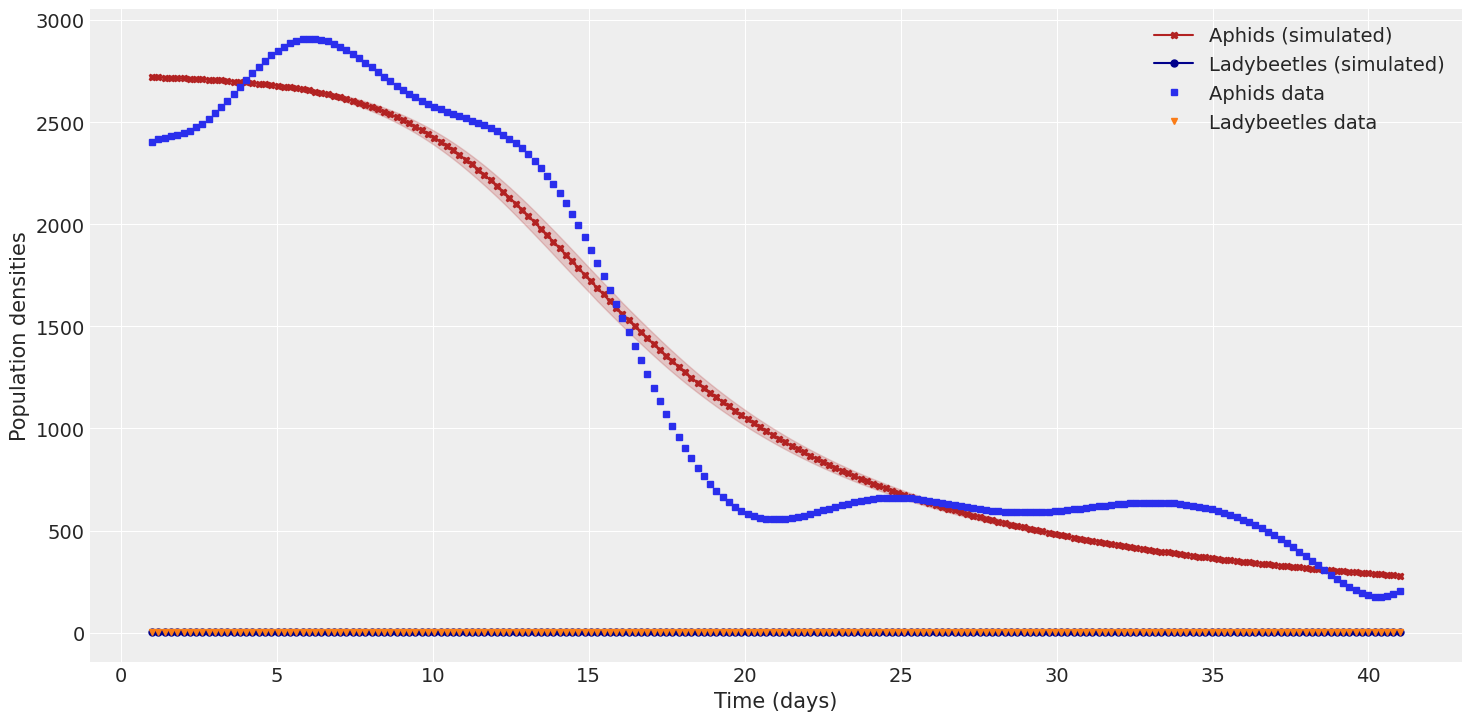

In [51]:
plt.figure(figsize=(15, 7.5))

plt.plot(
    time_observations,
    y_fit[:, 0],
    "firebrick",
    label="Aphids (simulated)",
    marker="X",
    linestyle="-",
    markersize=5,
)
plt.fill_between(time_observations, y_min[:, 0], y_max[:, 0], color="firebrick", alpha=0.2)

plt.plot(
    time_observations,
    y_fit[:, 1],
    "darkblue",
    label="Ladybeetles (simulated)",
    marker="o",
    linestyle="-",
    markersize=5,
)
plt.fill_between(time_observations, y_min[:, 1], y_max[:, 1], color="darkblue", alpha=0.2)

plt.plot(
    time_observations, 
    aphid_density, 
    label="Aphids data", 
    marker="s", 
    linestyle="", 
    markersize=5
)
plt.plot(
    time_observations, 
    ladybeetle_density, 
    label="Ladybeetles data", 
    marker="v", 
    linestyle="", 
    markersize=5
)

plt.legend(shadow=True)
plt.xlabel('Time (days)', fontsize=15)
plt.ylabel('Population densities', fontsize=15)

plt.tight_layout()
#plt.savefig("img/calibration_M14.png", dpi=300)
plt.show()

<ipython-input-135-e362412f0758>:20: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


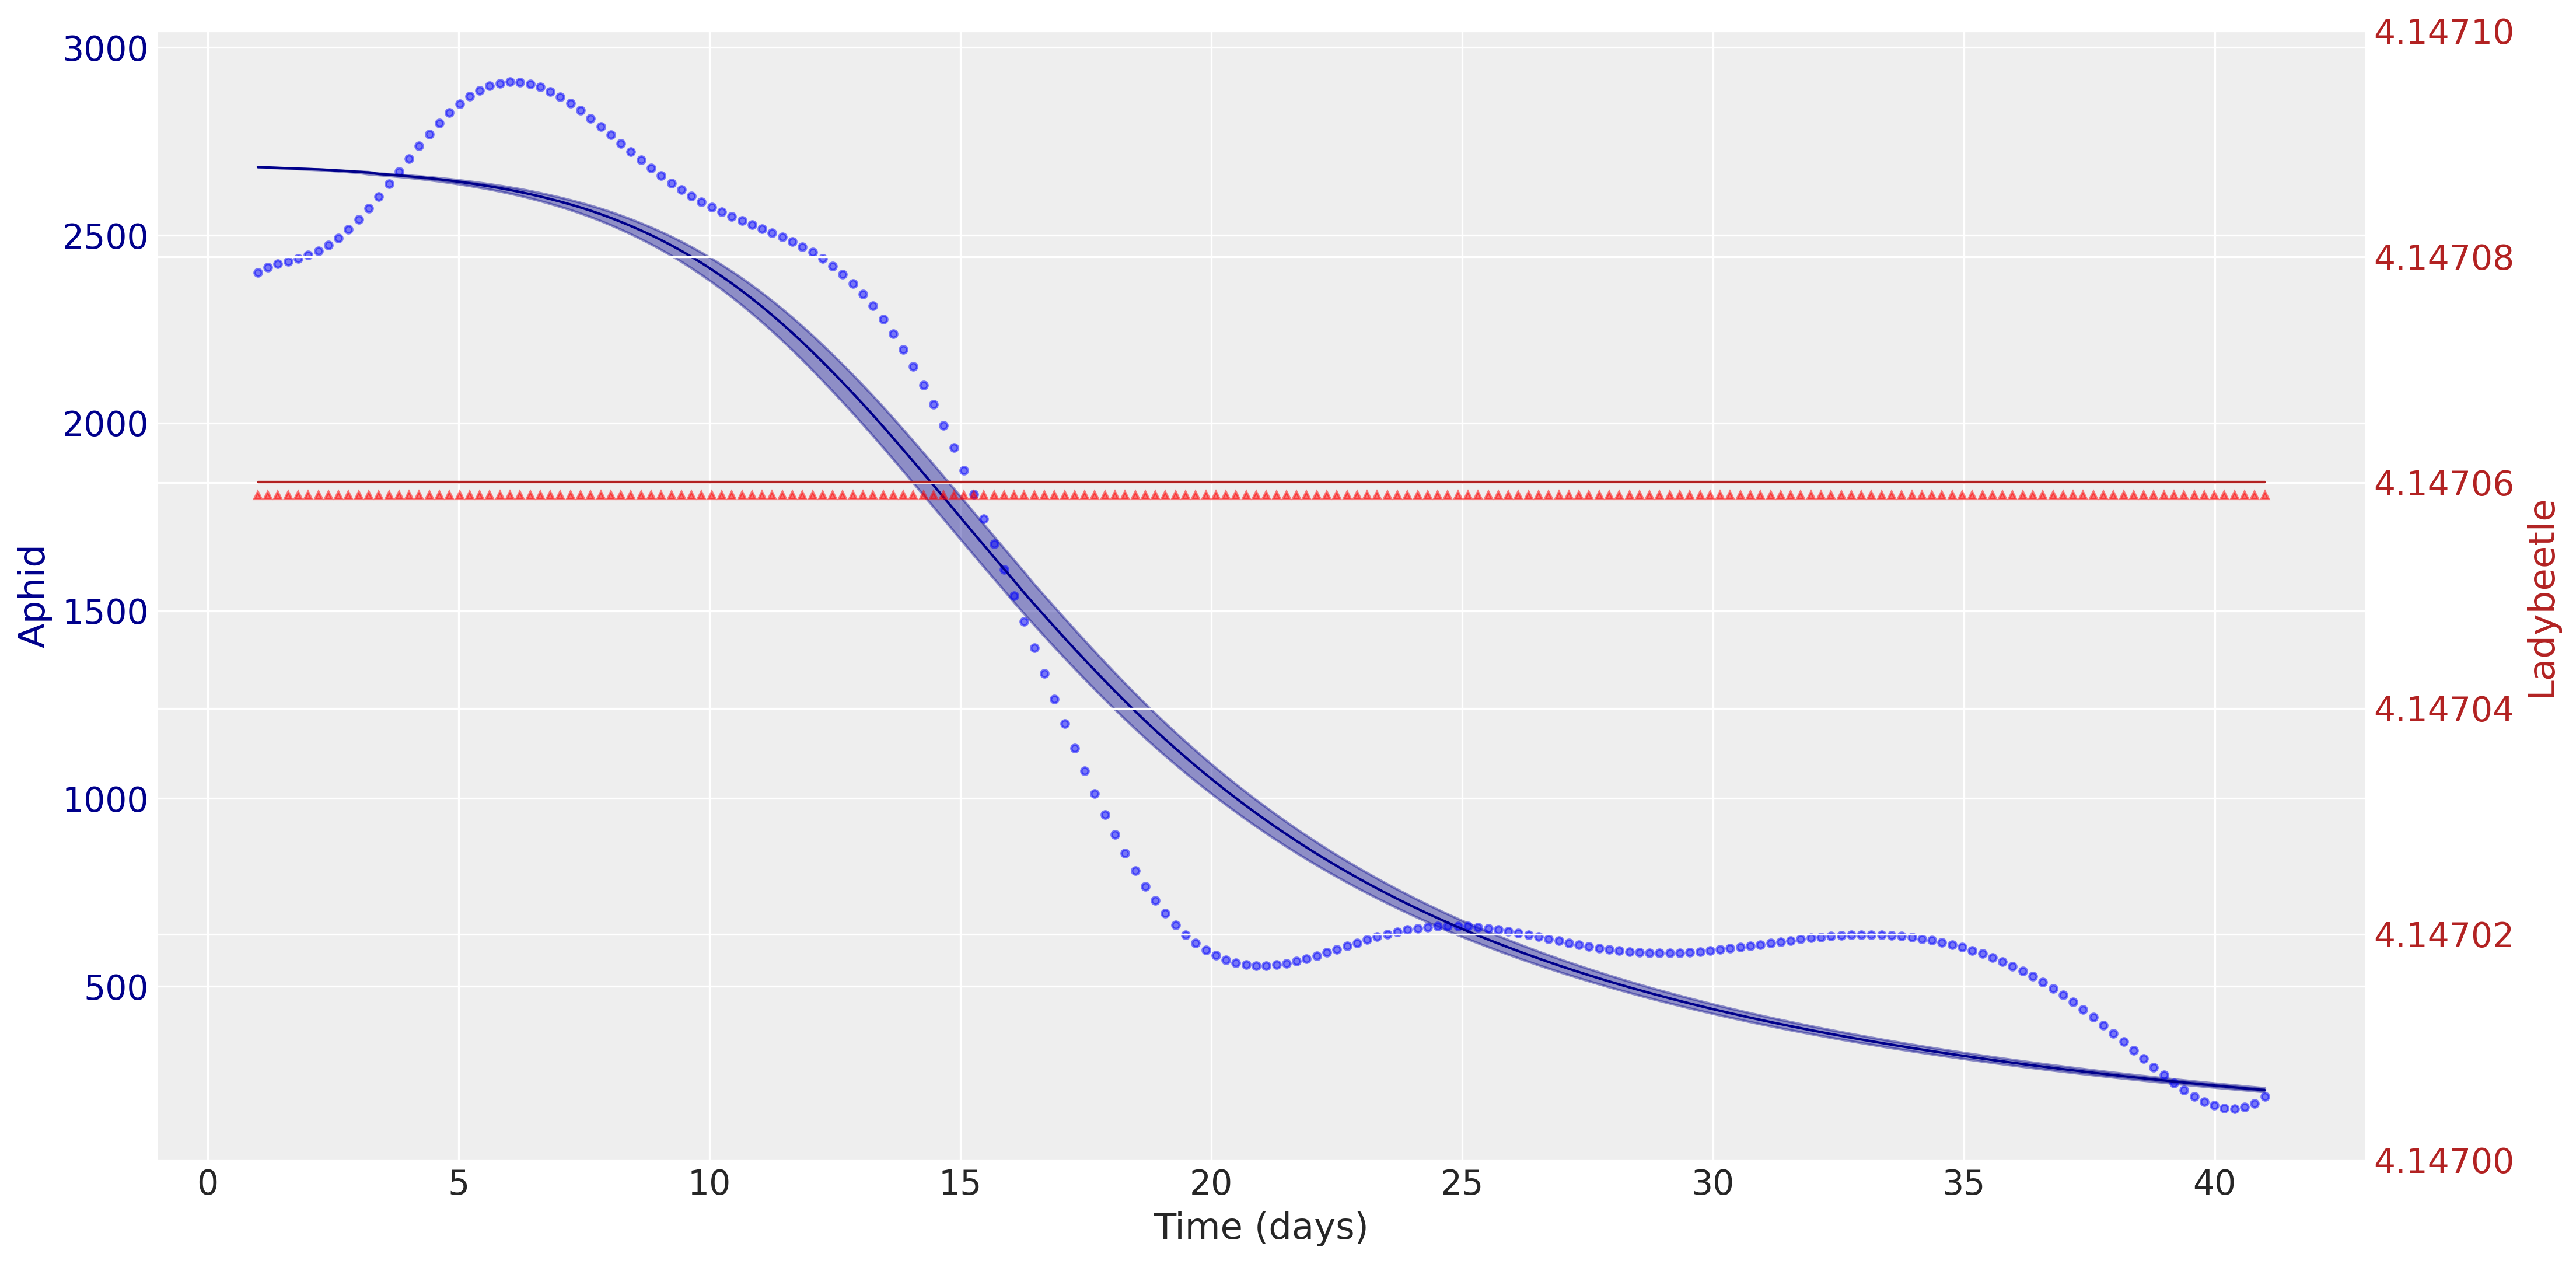

In [135]:
fig, ax1 = plt.subplots(1, 1, figsize = (15, 7.5), dpi = 300)
ax2 = ax1.twinx()
ax1.plot(time_observations, aphid_density, "bo", alpha = 0.5, markersize = 3)
ax2.plot(time_observations, ladybeetle_density, "r^", alpha = 0.5, markersize = 3)
ax1.plot(time_observations, y_fit[:, 0], "darkblue", alpha = 1.0, linewidth = 1)
ax2.plot(time_observations, y_fit[:, 1], "firebrick", alpha = 1.0, linewidth = 1)

ax1.fill_between(time_observations, y_min[:,0], y_max[:,0], color = "darkblue", alpha = 0.4)
ax2.fill_between(time_observations, y_min[:,1], y_max[:,1], color = "firebrick", alpha = 0.4)
ax1.set_xlabel(r"Time (days)")
ax1.set_ylabel(r"Aphid", color = "darkblue")
ax2.set_ylabel(r"Ladybeetle", color = "firebrick")
ax1.tick_params(axis = "y", labelcolor = "darkblue")
ax2.tick_params(axis = "y", labelcolor = "firebrick")
ax1.ticklabel_format(useOffset=False)
ax2.ticklabel_format(useOffset=False)

ax2.set_ylim([4.1470, 4.1471])

plt.tight_layout()
plt.savefig("img/calibration_M14.png", dpi=300)
plt.show()

In [53]:
print("-- Exporting calibrated parameter to CSV")

start_time = time.time()

dict_realizations = dict()  # save the realizations in a Python dictionary
progress_bar = tqdm(calibration_variable_names[1:])
for variable in progress_bar:
    progress_bar.set_description(f"Gathering {variable} realizations")
    parameter_realization = trace_calibration_M14.get_values(f"{variable}")
    dict_realizations[f"{variable}"] = parameter_realization

df_realizations = pd.DataFrame(dict_realizations)
df_realizations.to_csv("csv/calibration_realizations_M14.csv")

duration = time.time() - start_time

print(f"-- Exported done in {duration:.3f} seconds")

Gathering a21 realizations: 100%|██████████| 2/2 [00:00<00:00, 1788.23it/s]

-- Exporting calibrated parameter to CSV
-- Exported done in 0.115 seconds


In [54]:
df_realizations

r3       a21
0      5.332790e-08  0.000033
1      5.332910e-08  0.000033
2      5.333751e-08  0.000033
3      5.333751e-08  0.000033
4      5.333751e-08  0.000033
...             ...       ...
35995  5.297733e-08  0.000033
35996  5.297733e-08  0.000033
35997  5.297733e-08  0.000033
35998  5.303214e-08  0.000033
35999  5.303972e-08  0.000033

[36000 rows x 2 columns]

# Model 02

In [55]:
import matplotlib.pyplot as plt
from numba import jit
import numpy as np  # linear algebra
from scipy.integrate import solve_ivp  # to solve ODE system
import pandas as pd

y0 = 2713.7232754553243, 4.147055452699332

@jit(nopython=True)
def M02_model(
    t,
    X,
    r2 = 9.715e-05,
    r3 = 3.919e-08,
    a1 = 7.269e-03,
):
    """
    Prey-Predator M02 Model python implementation.
    """
    u, v = X
    u_prime = - r2*u**2 - a1*u*v + r3*u**3
    v_prime = 0.0
    return u_prime, v_prime

def M02_ode_solver(
    y0,
    t_span,
    t_eval,
    r2 = 9.715e-05,
    r3 = 3.919e-08,
    a1 = 7.269e-03,
):
    solution_ODE = solve_ivp(
        fun=M02_model,
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        args=(r2, r3, a1),
        method="LSODA",
    )
    return solution_ODE

t0 = time_list.min()
tf = time_list.max()
days_to_forecast = 0
time_list_range = np.linspace(t0, tf + days_to_forecast, len(time_list))

u_data = aphid_density
v_data = ladybeetle_density

* We now need to calibrate the parameters of the function. Firstly, we have to define a least-squares residual error function:

In [56]:
def M02_least_squares_error_ode(
    par, time_list_exp, f_exp, fitting_model, initial_conditions
):
    args = par
    f_exp1, f_exp2 = f_exp
    time_list_span = (time_list_exp.min(), time_list_exp.max())

    weighting_for_exp1_constraints = 1
    weighting_for_exp2_constraints = 1
    num_of_qoi = len(f_exp)

    try:
        y_model = fitting_model(initial_conditions, time_list_span, time_list_exp, *args)
    #         y_model = fitting_model(time_list_span, time_list_exp, *args)
        simulated_time_list = y_model.t
        simulated_ode_solution = y_model.y
        simulated_qoi1, simulated_qoi2 = simulated_ode_solution

        residual1 = f_exp1 - simulated_qoi1
        residual2 = f_exp2 - simulated_qoi2

        first_term = weighting_for_exp1_constraints * np.sum(residual1 ** 2.0)
        second_term = weighting_for_exp2_constraints * np.sum(residual2 ** 2.0)

        objective_function = 1 / num_of_qoi * (first_term + second_term)
    except ValueError:
        objective_function = 1e15

    return objective_function

def callback_de(xk, convergence):
    """
    This function is to show the optimization procedure progress.
    """
    print(f'parameters = {xk}\n')

* Now we calibrate minimizing the residual applying the Differential Evolution method, a global optimization method, provided by `scipy`:

In [57]:
from scipy import optimize

seed=seed

r2 = 9.715e-05
r3 = 3.919e-08
a1 = 7.269e-03
denom_min = 0.99
denom_max = 1.01
bounds_M02 = [
    ( ( r2 * denom_min ), ( r2 * denom_max ) ),
    ( ( r3 * denom_min ), ( r3 * denom_max ) ),
    ( ( a1 * denom_min ), ( a1 * denom_max ) ),
]

result_M02 = optimize.differential_evolution(
    M02_least_squares_error_ode,
    bounds=bounds_M02,
    args=(
        time_list,
        [aphid_density, ladybeetle_density],
        M02_ode_solver,
        y0,
    ),
    popsize=30,
    strategy="best1bin",
    tol=1e-5,
    recombination=0.95,
    mutation=0.6,
    maxiter=10000,
    polish=True,
    disp=True,
    seed=seed,
    callback=callback_de,
    workers=-1,
)

print(result_M02)

/home/tungdil/.local/lib/python3.8/site-packages/scipy/optimize/_differentialevolution.py:492: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  warnings.warn("differential_evolution: the 'workers' keyword has"


differential_evolution step 1: f(x)= 6.15907e+06
parameters = [9.74067039e-05 3.95806535e-08 7.22938895e-03]

differential_evolution step 2: f(x)= 6.15907e+06
parameters = [9.74067039e-05 3.95806535e-08 7.22938895e-03]

differential_evolution step 3: f(x)= 6.15305e+06
parameters = [9.73277257e-05 3.95780024e-08 7.27808988e-03]

differential_evolution step 4: f(x)= 6.15305e+06
parameters = [9.73277257e-05 3.95780024e-08 7.27808988e-03]

differential_evolution step 5: f(x)= 6.14818e+06
parameters = [9.72624674e-05 3.95697743e-08 7.31930523e-03]

differential_evolution step 6: f(x)= 6.14605e+06
parameters = [9.72621541e-05 3.95789769e-08 7.32814288e-03]

differential_evolution step 7: f(x)= 6.14513e+06
parameters = [9.72563847e-05 3.95781273e-08 7.33550446e-03]

differential_evolution step 8: f(x)= 6.14513e+06
parameters = [9.72563847e-05 3.95781273e-08 7.33550446e-03]

differential_evolution step 9: f(x)= 6.14458e+06
parameters = [9.72678380e-05 3.95817763e-08 7.34105827e-03]

differenti

* Retrieving the calibrated parameter values:

In [58]:
t0 = time_list.min()
tf = time_list.max()
days_to_forecast = 0
time_list_range = np.linspace(t0, tf + days_to_forecast, 100)
(
    r2_deterministic,
    r3_deterministic,
    a1_deterministic,
) = result_M02.x

solution_ODE_M02 = M02_ode_solver(
    y0,
    (t0, tf + days_to_forecast), 
    time_list_range, 
    *result_M02.x
)
t_computed_M02, y_computed_M02 = solution_ODE_M02.t, solution_ODE_M02.y
u_M02, v_M02 = y_computed_M02

parameters_dict = {
    "Model": "M02",
    u"$r2$": r2_deterministic,
    u"$r3$": r3_deterministic,
    u"$a1$": a1_deterministic,
}

print("r2=" + str(r2_deterministic) + "\n" + "r3=" + str(r3_deterministic) + "\n" + "a1=" + str(a1_deterministic) )

df_parameters_calibrated = pd.DataFrame.from_records([parameters_dict])
#print(df_parameters_calibrated.to_latex(index=False))

r2=9.725556231317079e-05
r3=3.958189231020605e-08
a1=0.007341637777931233


#### Simulation

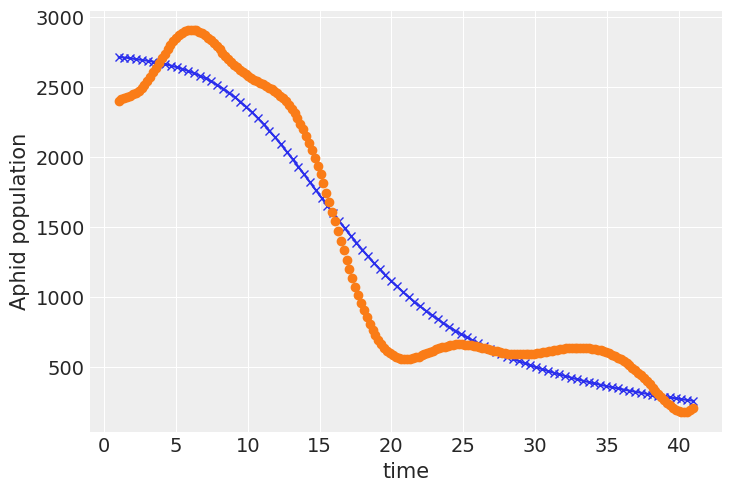

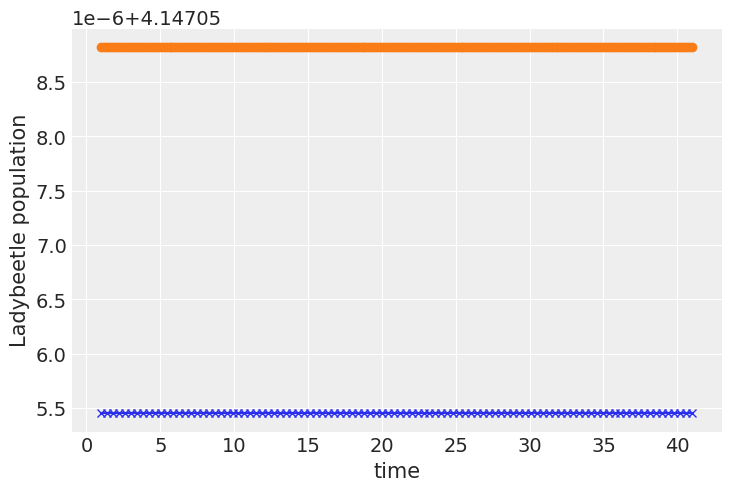

In [59]:
import matplotlib.pyplot as plt

aphid_observed = aphid_data[:].copy()
ladybeetle_observed = ladybeetle_data[:].copy()

plt.plot(t_computed_M02, u_M02, '-x')
plt.plot(time_list, aphid_density, 'o', label='Observed')

plt.xlabel('time')
plt.ylabel('Aphid population')
plt.show()

plt.plot(t_computed_M02, v_M02, '-x')
plt.plot(time_list, ladybeetle_density, 'o', label='Observed')
plt.xlabel('time')
plt.ylabel('Ladybeetle population')
plt.show()

## Sensitivity Analyses

### Least-Squares objective function

In [60]:
from SALib.sample.morris import sample as ee_sample

mean_values_params = [
    r2,
    r3,
    a1,
]
factors_names = [
    r"$r2$",
    r"$r3$",
    r"$a1$",
]
params_perturbations = 0.01
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [61]:
from tqdm import tqdm

num_of_realizations = parameter_values.shape[0]
qoi_sensitivity_outputs = np.zeros(num_of_realizations)

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    residual_least_squares_result = M02_least_squares_error_ode(
        parameters_realization,
        time_list,
        [u_data, v_data],
        M02_ode_solver,
        y0
    )
    
    qoi_sensitivity_outputs[realization_index] = residual_least_squares_result

100%|██████████| 16/16 [00:00<00:00, 918.14it/s]


In [62]:
from SALib.analyze.morris import analyze as ee_analyze

data_time_list = time_list
num_of_experimental_points = data_time_list.shape[0]

df_Si = pd.DataFrame(columns=[*problem_info['names']])

Si = ee_analyze(problem_info, parameter_values, qoi_sensitivity_outputs, num_levels=grid_level, seed=seed)
Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
for idx, param_name in enumerate(problem_info['names']):
    df_Si.loc[0, param_name] = Si['mu_star_normalized'][idx]

df_Si = df_Si.T
df_Si.rename(columns={0: r'$\mu^*$'}, inplace=True)
df_Si.sort_values(by=r'$\mu^*$', ascending=False, inplace=True)
df_Si

$\mu^*$
$r3$   0.516102
$r2$   0.431206
$a1$  0.0526911

<ipython-input-63-5bdf280c7220>:9: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


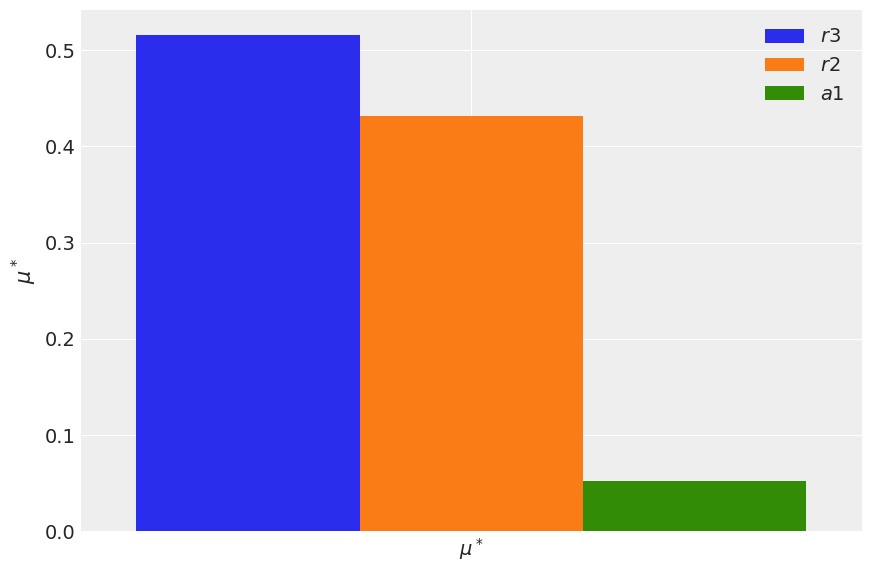

In [63]:
df_Si.T.plot.bar(rot=0, width=3, figsize=(9, 6))

plt.rcParams.update({'font.size': 16})

plt.ylabel(r"$\mu^*$")

plt.legend(fancybox=True, shadow=True)

plt.tight_layout()
#plt.savefig("img/sensitivity_least_squares_M02.png", dpi=300)
plt.show()

### Prey (pest) population

In [64]:
from SALib.sample.morris import sample as ee_sample

mean_values_params = [
    r2,
    r3,
    a1,
]
factors_names = [
    r"$r2$",
    r"$r3$",
    r"$a1$",
]
params_perturbations = 0.01
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [65]:
from tqdm import tqdm

t0 = time_list.min()
tf = time_list.max()
days_to_forecast = 0
time_list_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_list_points = time_list_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_list_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_M02 = M02_ode_solver(
        y0, 
        (t0, tf + days_to_forecast), 
        time_list_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_M02.y
    
    qoi_sensitivity_outputs[realization_index, :] = u_realization

100%|██████████| 16/16 [00:00<00:00, 743.75it/s]


In [66]:
from SALib.analyze.morris import analyze as ee_analyze

df_Si = pd.DataFrame(columns=['time_list', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['time_list', *problem_info['names']])
df_Si['time_list'] = time_list_range
df_sigmai['time_list'] = time_list_range
for time_list_point in tqdm(range(num_of_time_list_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_list_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_list_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_list_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='time_list', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='time_list', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_time_lists = df_Si.time_list.values
df_Si

  0%|          | 0/100 [00:00<?, ?it/s]/home/tungdil/.local/lib/python3.8/site-packages/numpy/ma/core.py:864: RuntimeWarning: underflow encountered in multiply
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
100%|██████████| 100/100 [00:00<00:00, 450.02it/s]


time_list      $r2$      $r3$       $a1$
0    1.404040  0.459619  0.488938  0.0514423
1    1.808081  0.463254  0.490867  0.0458793
2    2.212121   0.46842  0.481226  0.0503532
3    2.616162  0.456993  0.491327    0.05168
4    3.020202  0.458764  0.489403  0.0518325
..        ...       ...       ...        ...
94  39.383838  0.574613  0.354238   0.071149
95  39.787879  0.574181  0.354149  0.0716696
96  40.191919  0.573772  0.354013  0.0722145
97  40.595960  0.573391  0.353838  0.0727714
98  41.000000  0.573018  0.353674  0.0733073

[99 rows x 4 columns]

In [67]:
df_sigmai

time_list      $r2$       $r3$        $a1$
0    1.404040   0.78866   0.168085   0.0432551
1    1.808081  0.469525   0.527195  0.00328065
2    2.212121   0.97735  0.0149411  0.00770893
3    2.616162  0.846603   0.141304   0.0120928
4    3.020202   0.66575   0.282651   0.0515991
..        ...       ...        ...         ...
94  39.383838  0.751357   0.191246   0.0573964
95  39.787879  0.750819   0.191779   0.0574017
96  40.191919  0.750281   0.192262   0.0574569
97  40.595960  0.749817    0.19262   0.0575629
98  41.000000  0.749495    0.19283   0.0576745

[99 rows x 4 columns]

<ipython-input-68-eb99e360e602>:12: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


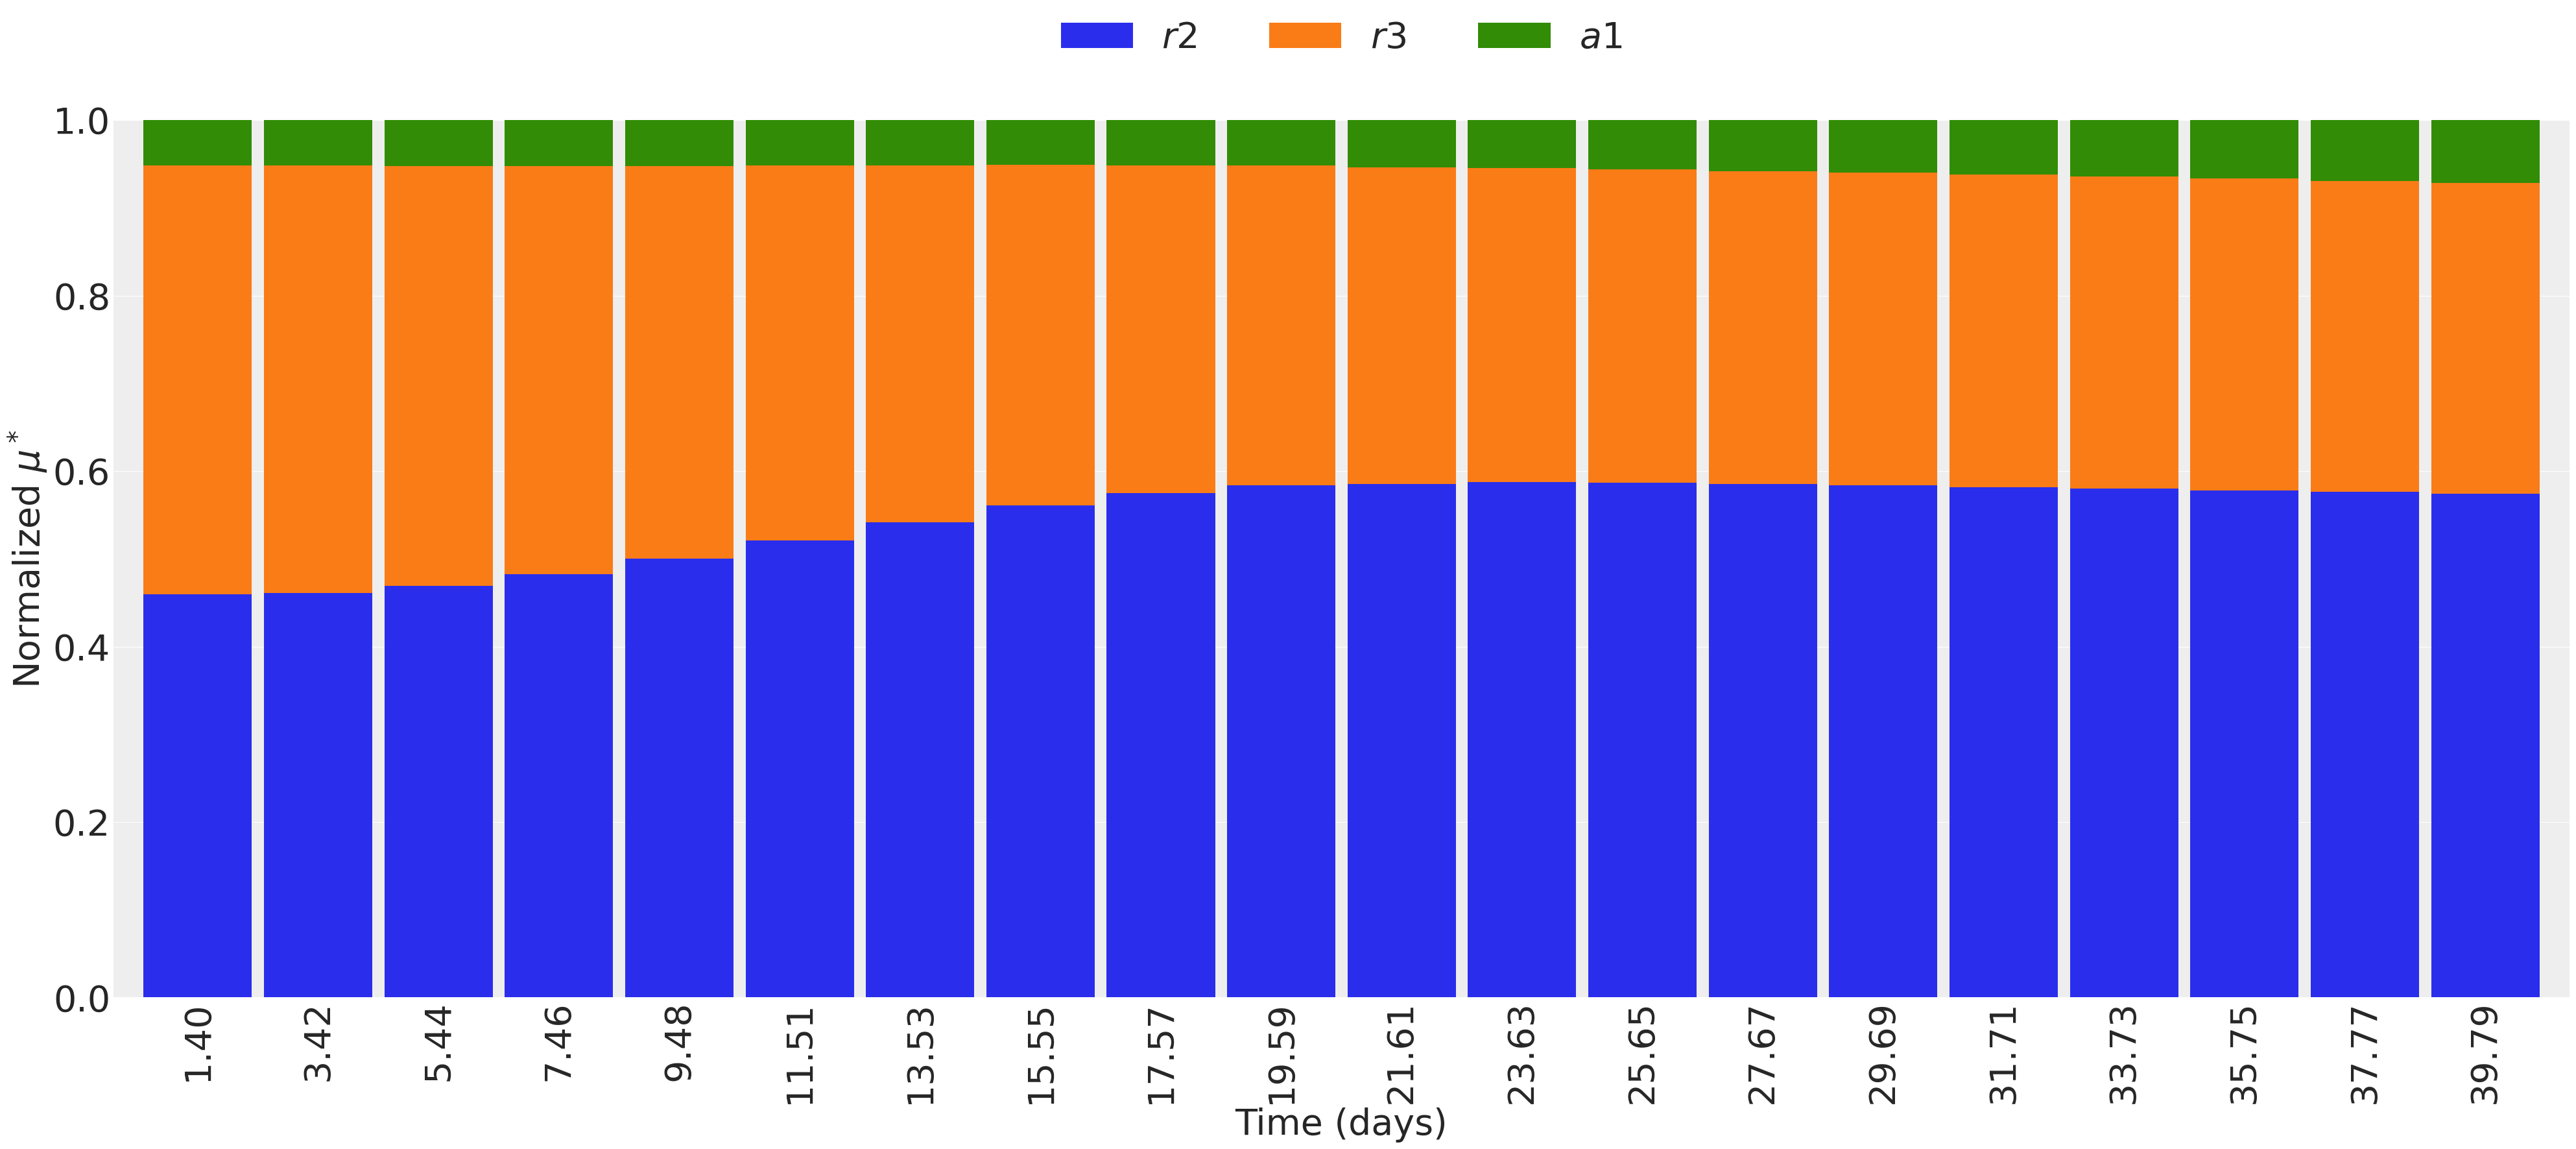

In [68]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 5
valid_time_lists_to_plot_mu = valid_time_lists[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='time_list', rot=90, width=0.9, figsize=(40, 18), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_time_lists_to_plot_mu[x]:.2f}")
plt.xlabel("Time (days)", fontsize = 40), plt.ylabel(r"Normalized $\mu^*$", fontsize = 40), plt.xticks(fontsize=40), plt.yticks(fontsize=40)

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True, fontsize=40)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_M02.png", dpi=300)
plt.show()

<ipython-input-69-be6f687658d2>:12: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


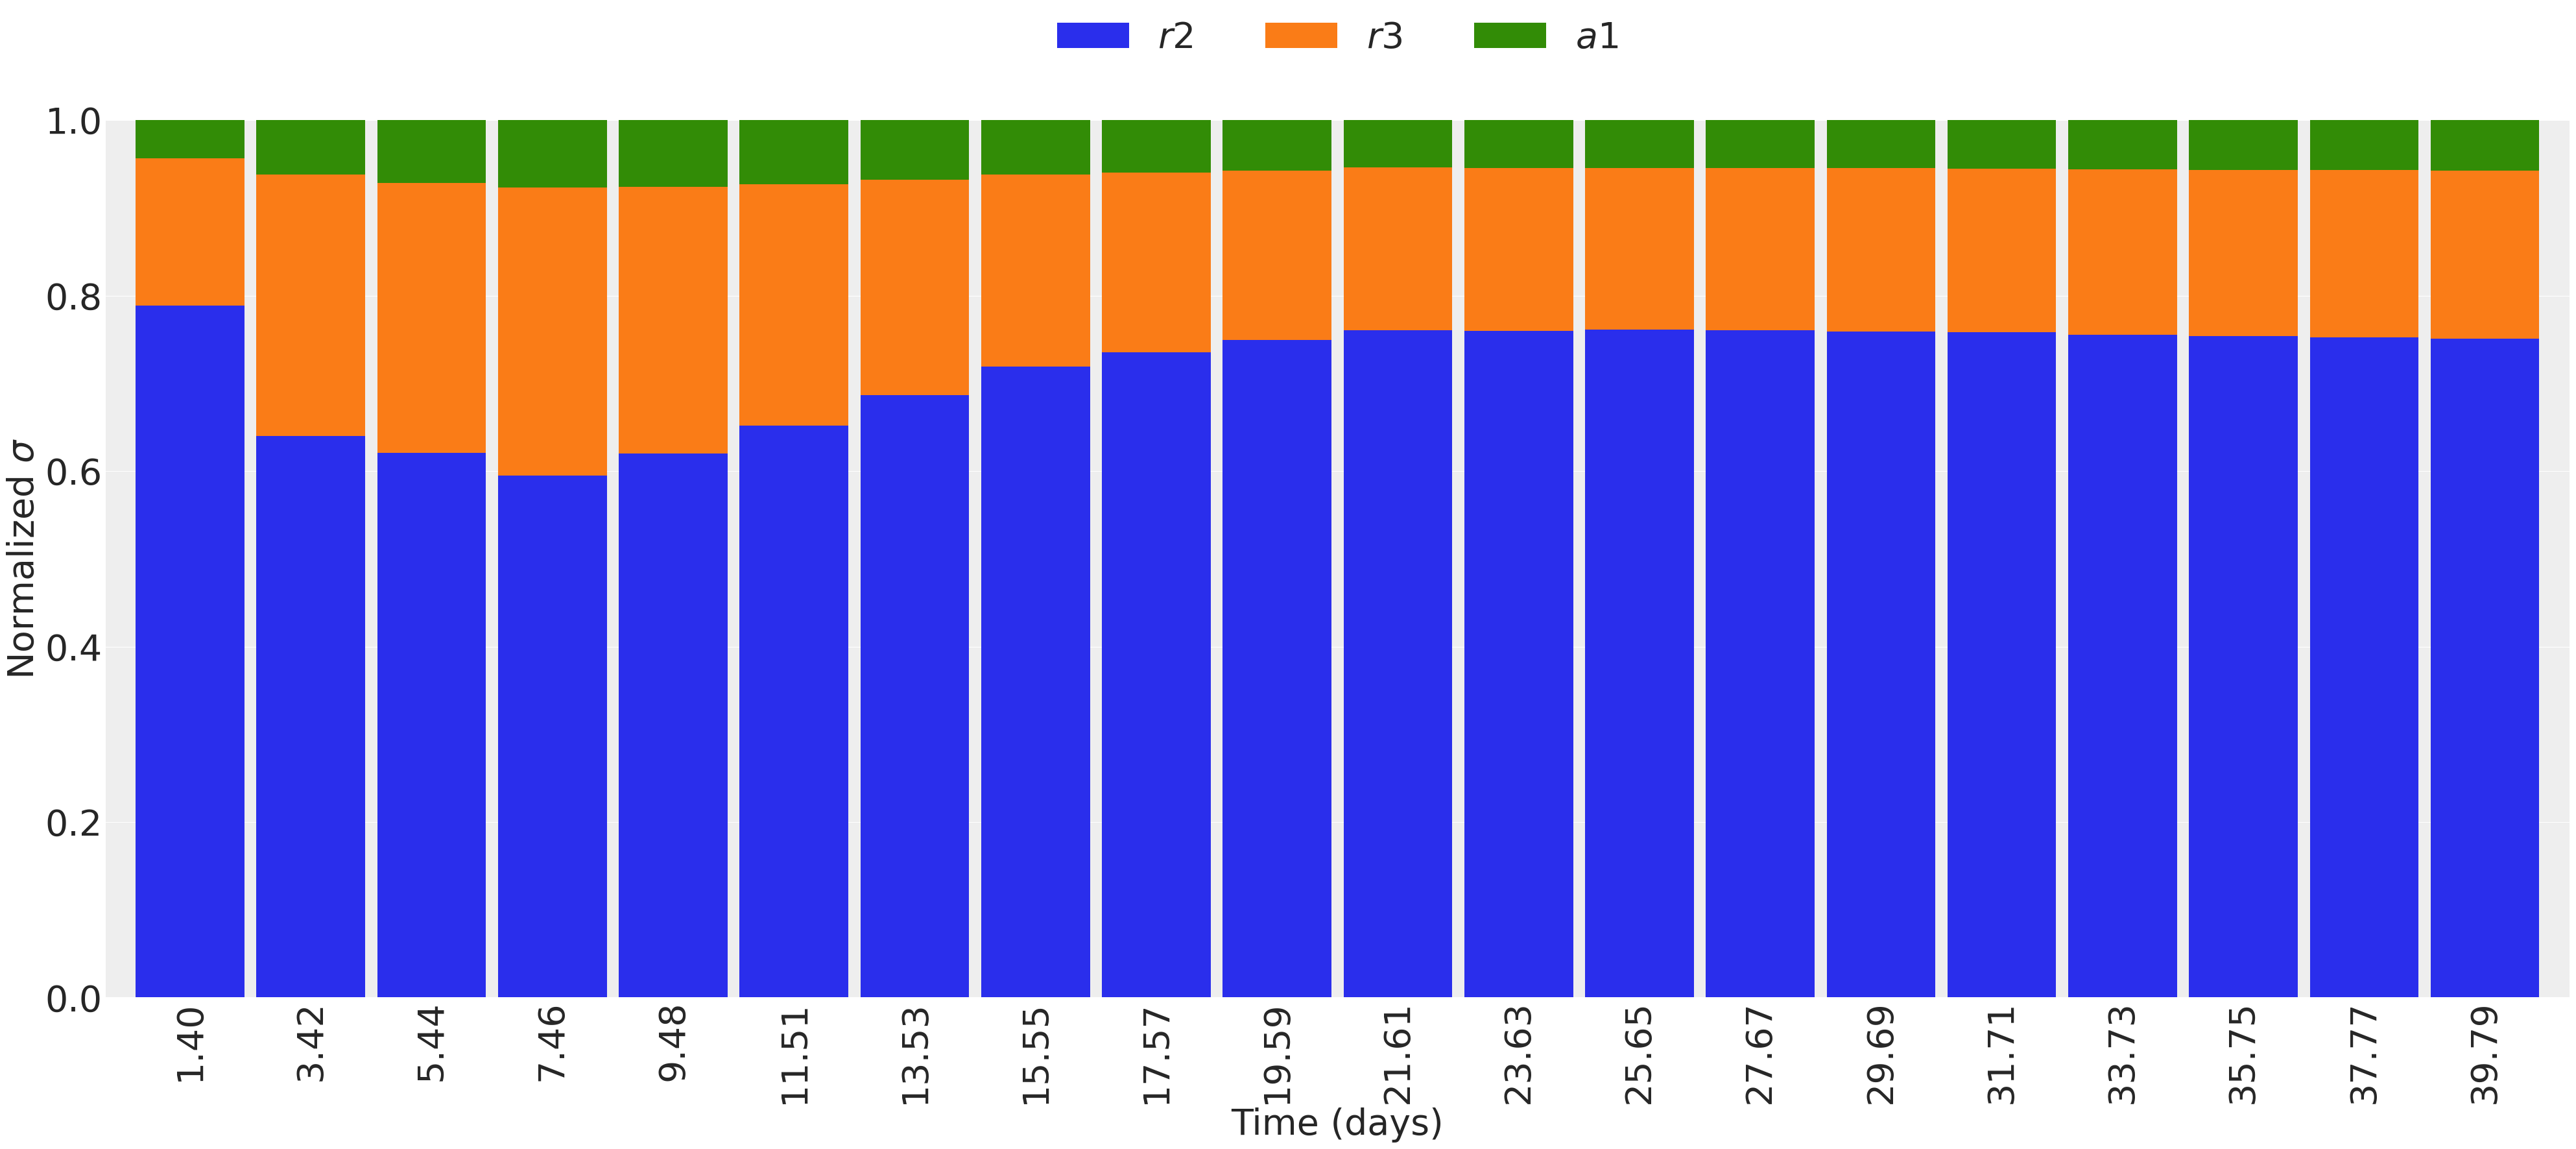

In [69]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 5
valid_time_lists_to_plot_sigma = valid_time_lists[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='time_list', rot=90, width=0.9, figsize=(40, 18), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_time_lists_to_plot_sigma[x]:.2f}")
plt.xlabel("Time (days)", fontsize = 40), plt.ylabel(r"Normalized $\sigma$", fontsize = 40), plt.xticks(fontsize=40), plt.yticks(fontsize=40)

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True, fontsize=40)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma_M02.png", dpi=300)
plt.show()

### time-derivative of pest (prey) population

In [70]:
def calculate_pest_time_list_derivative_series(
    time_list_array, 
    u_array, 
    v_array, 
    ode_model,
    model_pars
):
    pest_time_list_derivative_values = list()
    for t_idx, time_list in enumerate(time_list_array):
        u = u_array[t_idx]
        v = v_array[t_idx]
        stacked_population = [u, v]
        pest_time_list_derivative_value, _ = ode_model(time_list, stacked_population, *model_pars)
        pest_time_list_derivative_values.append(pest_time_list_derivative_value)
        
    pest_time_list_derivative_array = np.array(pest_time_list_derivative_values)
    return pest_time_list_derivative_array

In [71]:
pest_time_list_derivative_array = calculate_pest_time_list_derivative_series(
    t_computed_M02,
    u_M02,
    v_M02,
    M02_model,
    mean_values_params
)

pest_time_list_derivative_array

/home/tungdil/.local/lib/python3.8/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'X' of function 'M02_model'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-55-1ab9f7b051d9>", line 10:
@jit(nopython=True)
def M02_model(
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


array([ -14.04753377,  -15.41436442,  -16.77244214,  -18.8610419 ,
        -20.43822354,  -22.23298299,  -24.28786092,  -26.62908313,
        -29.24567788,  -32.12532175,  -35.27617284,  -38.79753388,
        -42.68114936,  -46.89792094,  -51.41595003,  -56.27367308,
        -61.50607413,  -67.05529966,  -72.85890606,  -78.85595449,
        -85.02195855,  -91.28378093,  -97.55226959, -103.73536319,
       -109.73180431, -115.40358446, -120.66681584, -125.45008628,
       -129.68428855, -133.29431146, -136.18517416, -138.33834666,
       -139.7487941 , -140.41337759, -140.35098501, -139.60679484,
       -138.22621901, -136.23160606, -133.80262587, -130.92956961,
       -127.67714378, -124.11303989, -120.3069714 , -116.32995114,
       -112.25251719, -108.14291224, -104.03026437,  -99.9369714 ,
        -95.89548117,  -91.93415417,  -88.07724088,  -84.3337499 ,
        -80.71042938,  -77.21553694,  -73.85490306,  -70.6321846 ,
        -67.54711865,  -64.59833443,  -61.78391834,  -59.10092

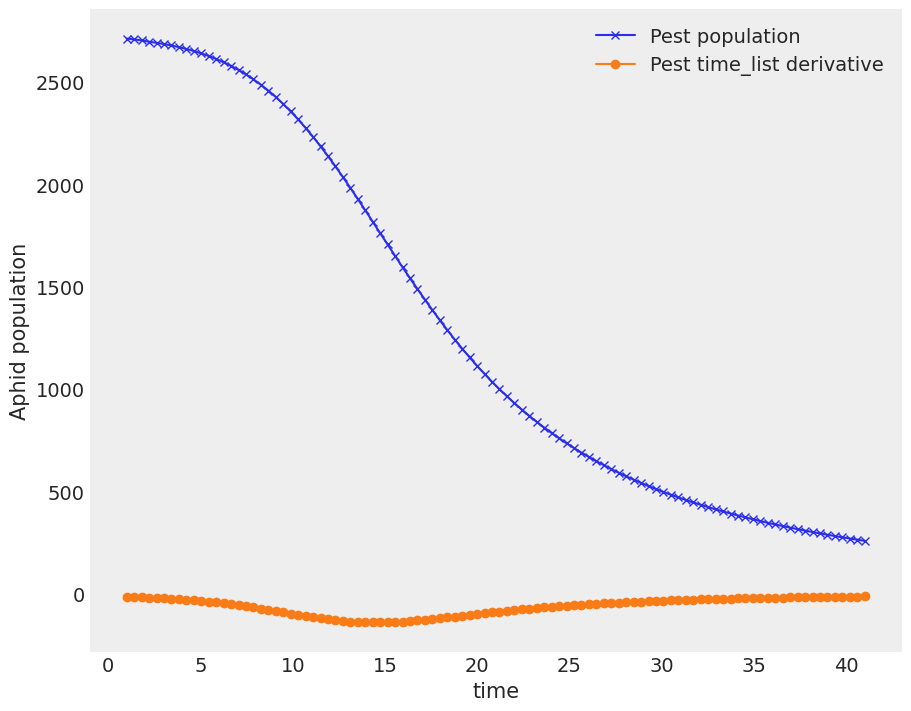

In [72]:
plt.figure(figsize=(9, 7))

plt.plot(t_computed_M02, u_M02, '-x', label='Pest population')
plt.plot(t_computed_M02, pest_time_list_derivative_array, '-o', label='Pest time_list derivative')

plt.xlabel('time')
plt.ylabel('Aphid population')

plt.grid()
plt.legend(shadow=True)

#plt.savefig("img/pest_derivative_M02.png", dpi=300)
plt.show()

In [73]:
mean_values_params = [
    r2,
    r3,
    a1,
]
factors_names = [
    r"$r2$",
    r"$r3$",
    r"$a1$",
]
params_perturbations = 0.01
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [74]:
t0 = time_list.min()
tf = time_list.max()
days_to_forecast = 0
time_list_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_list_points = time_list_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_list_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_M02 = M02_ode_solver(
        y0, 
        (t0, tf + days_to_forecast), 
        time_list_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_M02.y
    
    pest_time_list_derivative_array = calculate_pest_time_list_derivative_series(
        time_list_range,
        u_realization,
        v_realization,
        M02_model,
        parameters_realization
    )
    
    qoi_sensitivity_outputs[realization_index, :] = pest_time_list_derivative_array

100%|██████████| 16/16 [00:00<00:00, 339.26it/s]


In [75]:
df_Si = pd.DataFrame(columns=['time_list', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['time_list', *problem_info['names']])
df_Si['time_list'] = time_list_range
df_sigmai['time_list'] = time_list_range
for time_list_point in tqdm(range(num_of_time_list_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_list_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_list_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_list_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='time_list', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='time_list', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_time_lists = df_Si.time_list.values
df_Si

  0%|          | 0/100 [00:00<?, ?it/s]/home/tungdil/.local/lib/python3.8/site-packages/numpy/ma/core.py:864: RuntimeWarning: underflow encountered in multiply
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
100%|██████████| 100/100 [00:00<00:00, 478.87it/s]


time_list      $r2$      $r3$       $a1$
0    1.404040  0.454864  0.493272  0.0518642
1    1.808081  0.457887  0.491494  0.0506192
2    2.212121  0.461664  0.486693  0.0516433
3    2.616162  0.459579  0.488305  0.0521165
4    3.020202  0.462111  0.485677  0.0522118
..        ...       ...       ...        ...
94  39.383838  0.587899  0.358865  0.0532365
95  39.787879  0.587583  0.358973  0.0534433
96  40.191919  0.587292  0.359035  0.0536732
97  40.595960  0.587031  0.359055  0.0539133
98  41.000000   0.58678   0.35909  0.0541291

[99 rows x 4 columns]

In [76]:
df_sigmai

time_list      $r2$      $r3$       $a1$
0    1.404040  0.632665   0.30507  0.0622654
1    1.808081    0.4318  0.550481  0.0177186
2    2.212121  0.831499  0.144136  0.0243643
3    2.616162   0.58022  0.353896  0.0658845
4    3.020202  0.546005  0.378124  0.0758704
..        ...       ...       ...        ...
94  39.383838  0.760349  0.184977  0.0546746
95  39.787879  0.759794  0.185524  0.0546822
96  40.191919  0.759236  0.186027  0.0547363
97  40.595960  0.758744  0.186419  0.0548372
98  41.000000  0.758385  0.186674  0.0549408

[99 rows x 4 columns]

<ipython-input-77-bcc07bf8bfe0>:12: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


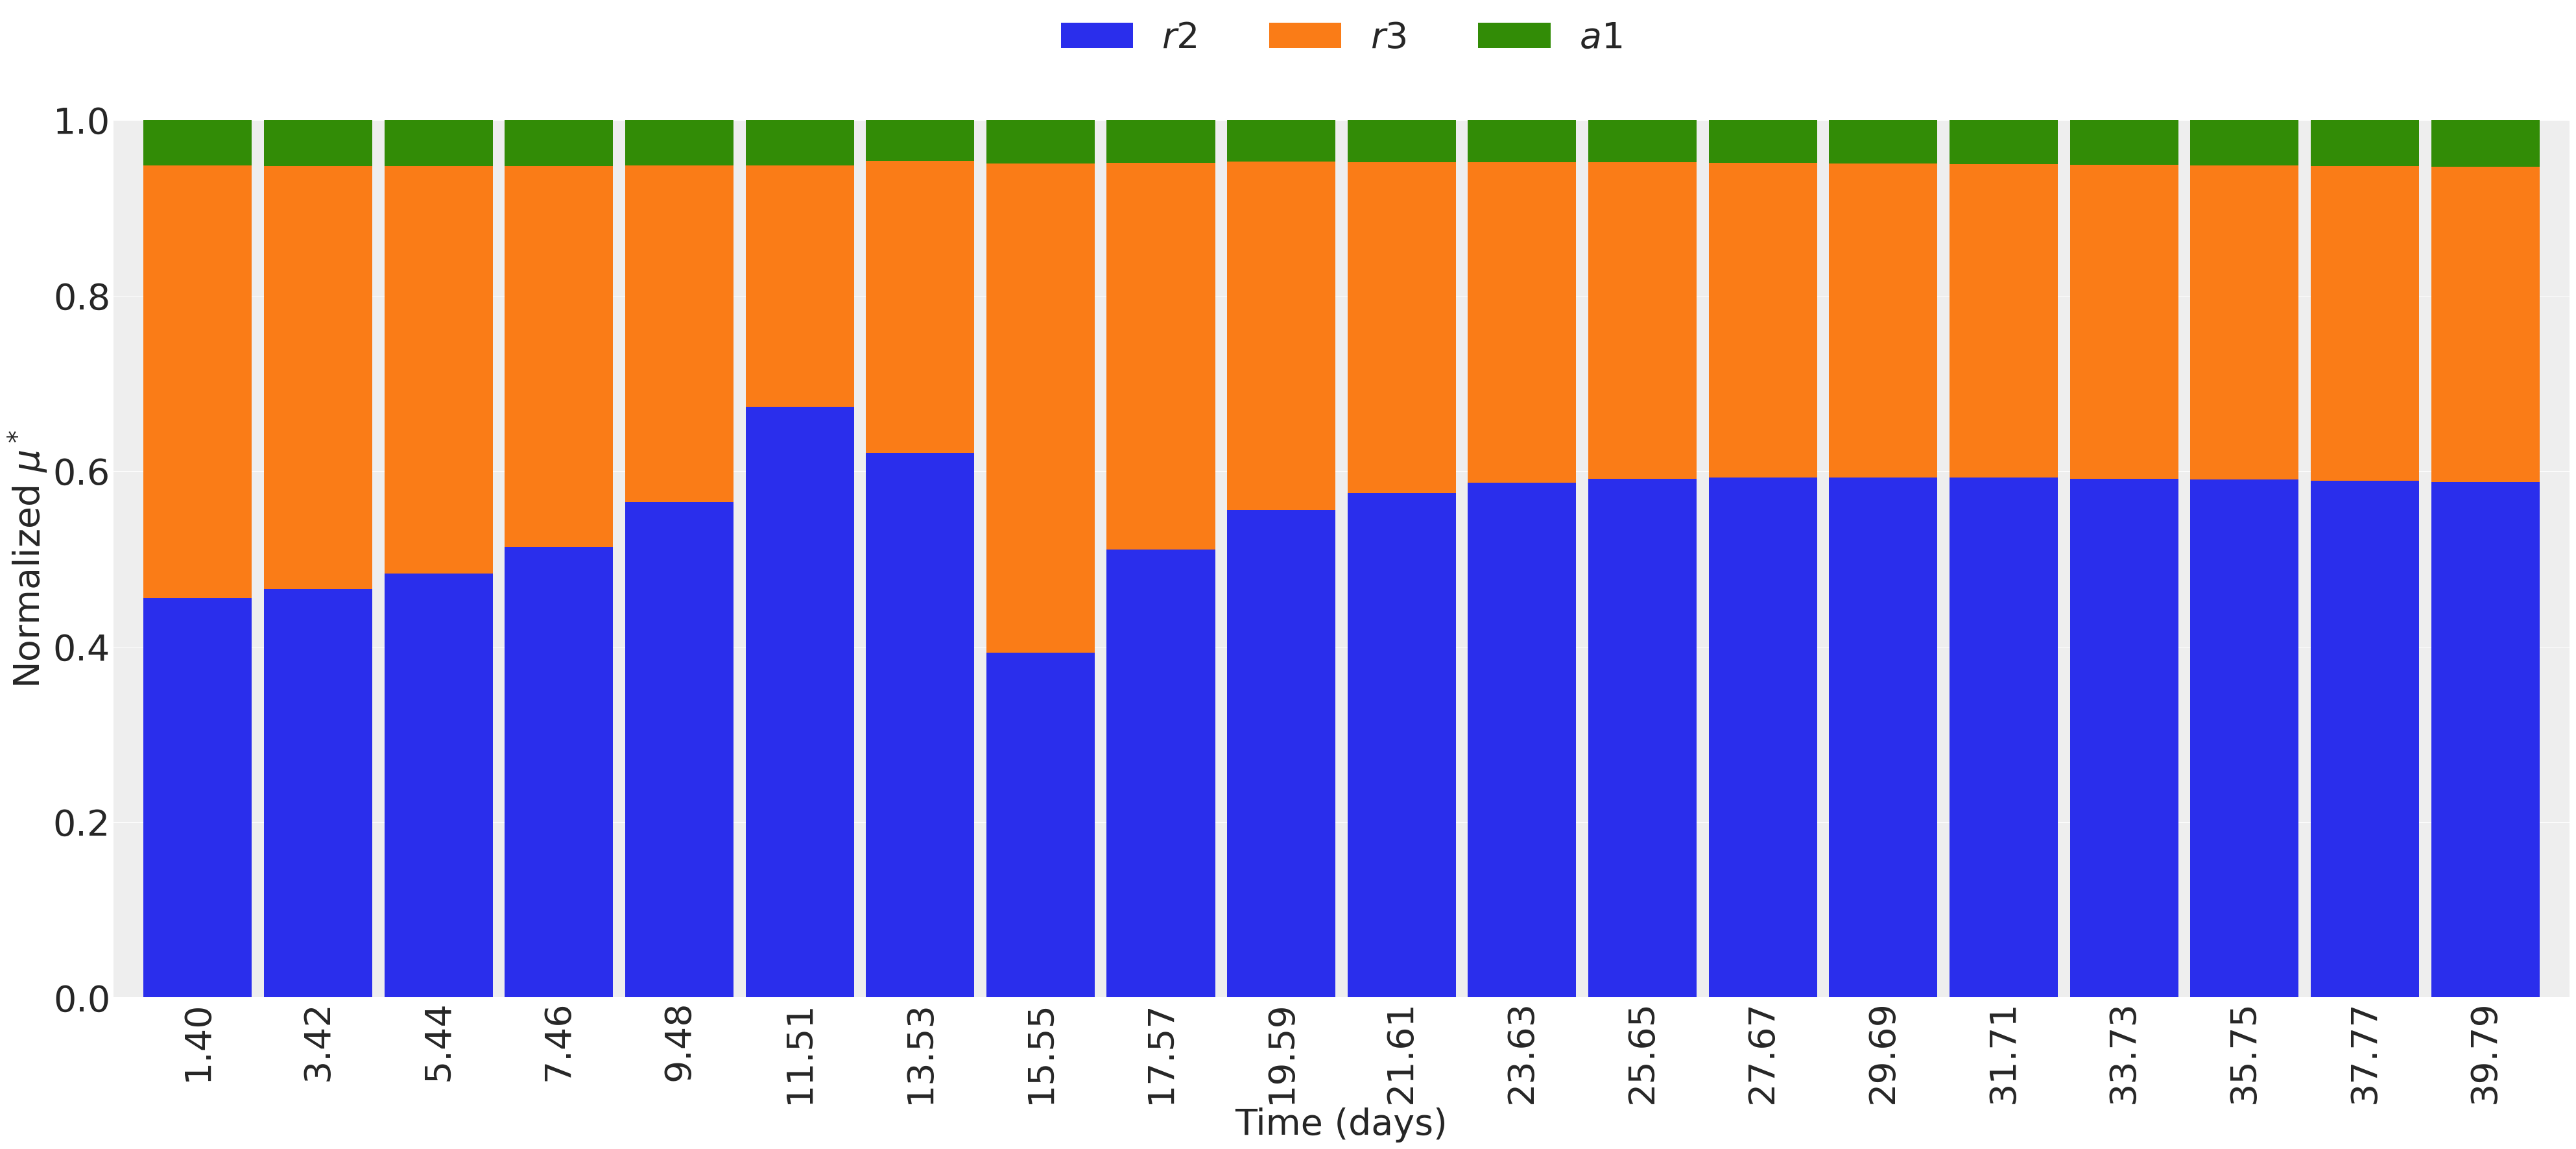

In [77]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 5
valid_time_lists_to_plot_mu = valid_time_lists[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='time_list', rot=90, width=0.9, figsize=(40, 18), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_time_lists_to_plot_mu[x]:.2f}")
plt.xlabel("Time (days)", fontsize = 40), plt.ylabel(r"Normalized $\mu^*$", fontsize = 40), plt.xticks(fontsize=40), plt.yticks(fontsize=40)

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True, fontsize=40)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_derivative_M02.png", dpi=300)
plt.show()

<ipython-input-78-290b45dc8240>:12: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


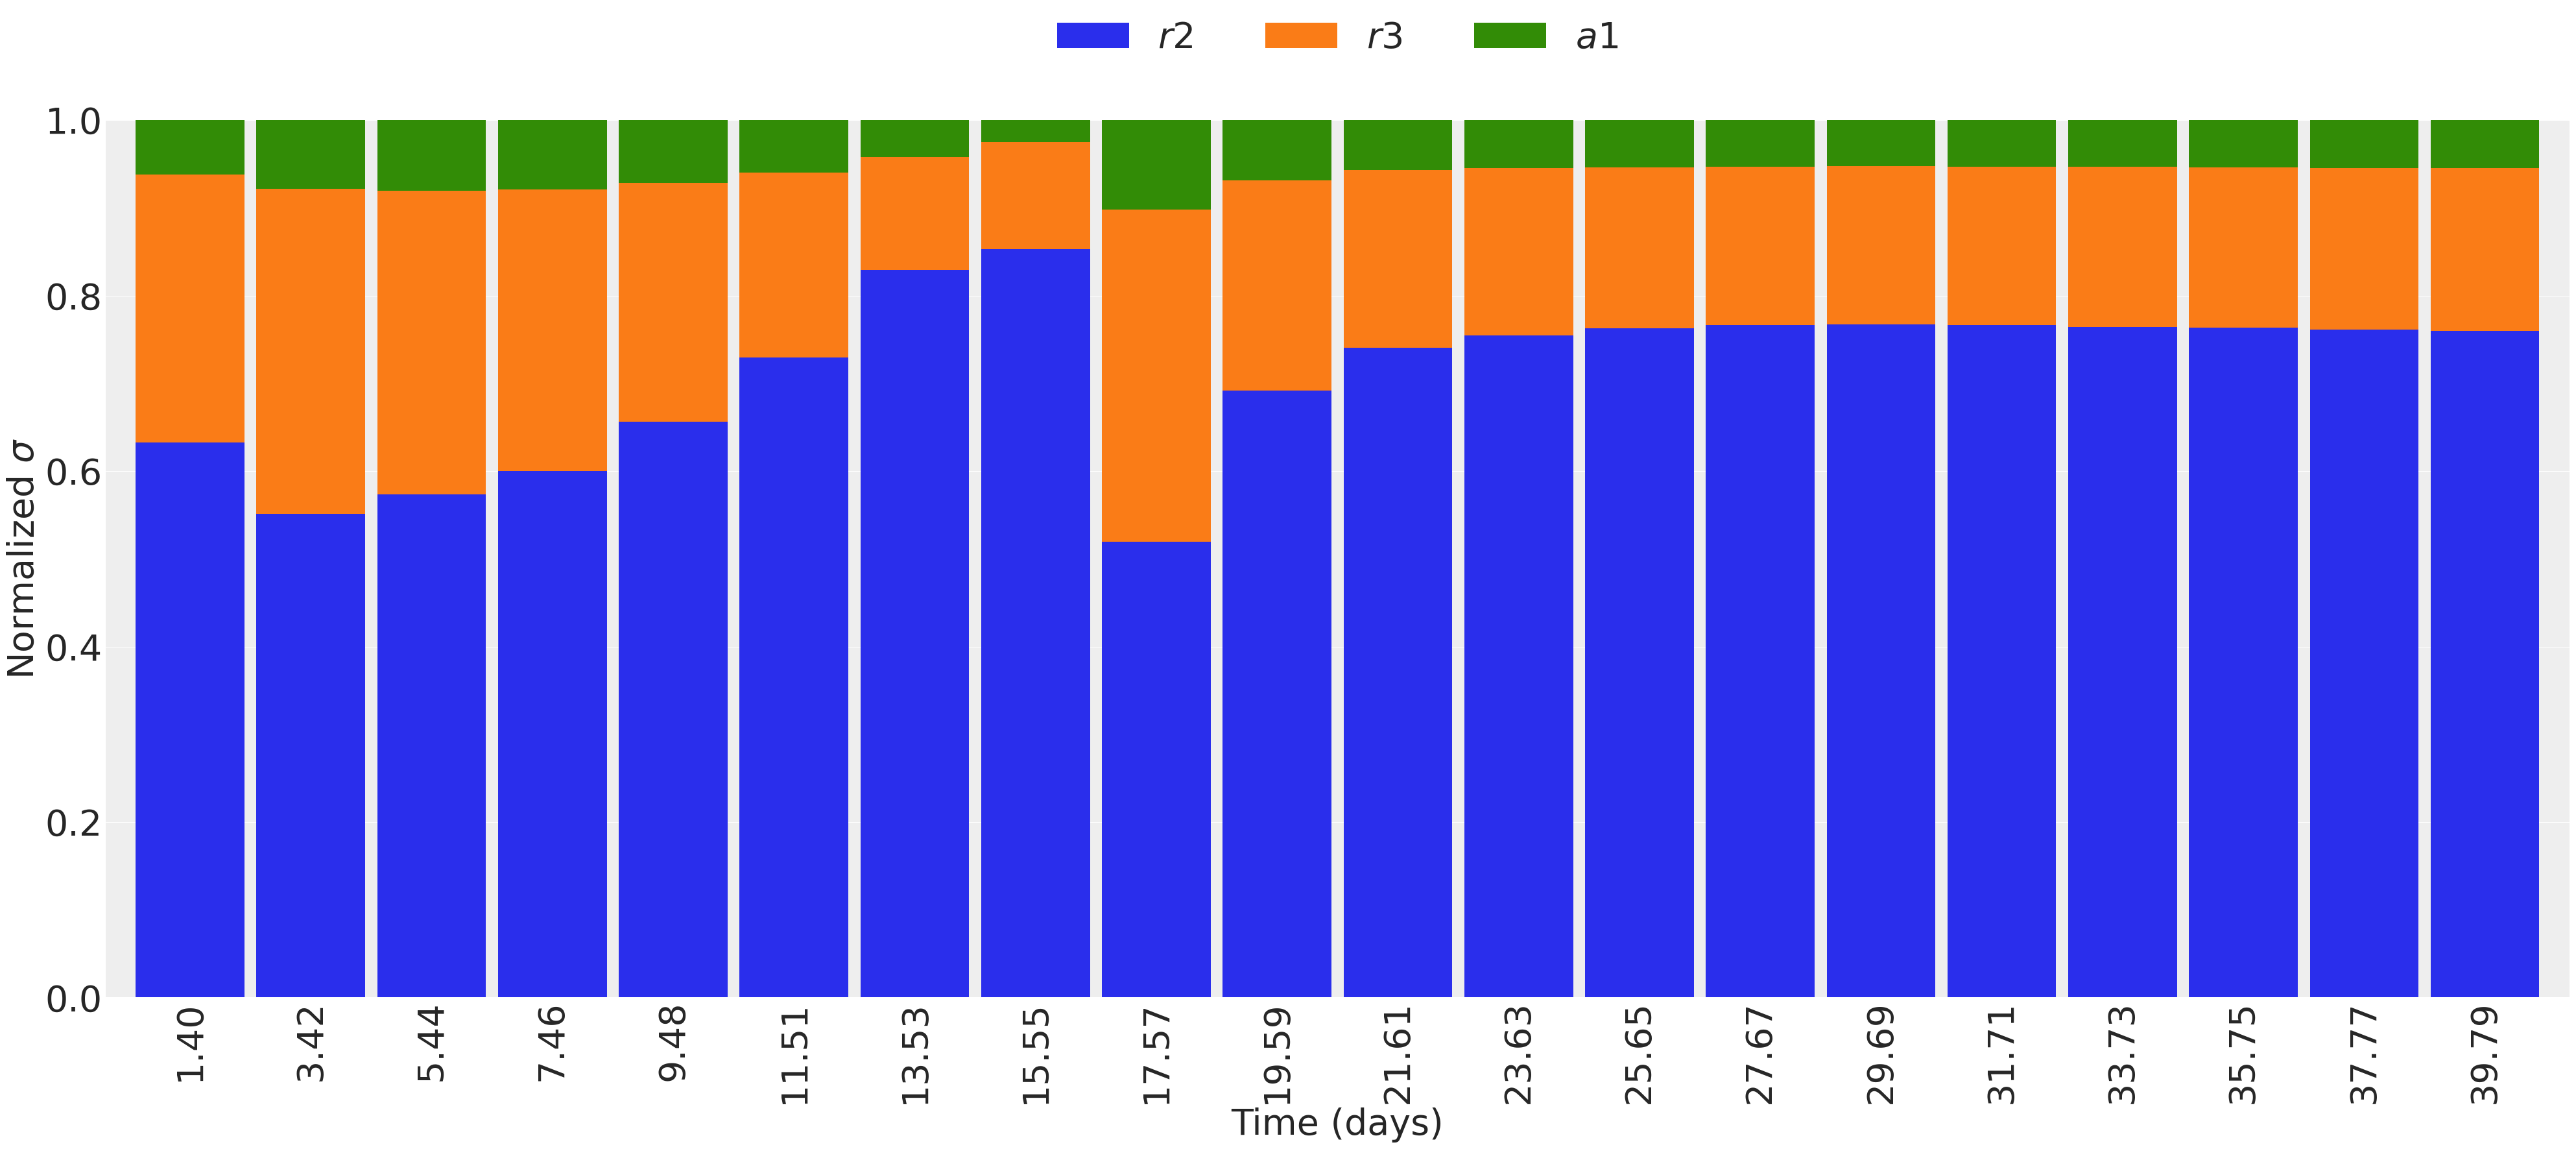

In [78]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 5
valid_time_lists_to_plot_sigma = valid_time_lists[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='time_list', rot=90, width=0.9, figsize=(40, 18), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_time_lists_to_plot_sigma[x]:.2f}")
plt.xlabel("Time (days)", fontsize = 40), plt.ylabel(r"Normalized $\sigma$", fontsize = 40), plt.xticks(fontsize=40), plt.yticks(fontsize=40)

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True, fontsize=40)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma_derivative_M02.png", dpi=300)
plt.show()

## Bayesian calibration

In [79]:
@theano.compile.ops.as_op(
    itypes=[
        t.dvector, 
        t.dscalar,  # r2
        t.dscalar,  # r3
        t.dscalar,  # a1
        t.dscalar,  # u0
        t.dscalar,  # v0
    ], 
    otypes=[t.dmatrix]
)
def M02_ode_wrapper(time_list_exp, r2, r3, a1, u0, v0):
    time_list_span = (time_list_exp.min(), time_list_exp.max())

    args = [r2, r3, a1]
    initial_conditions = np.array([u0, v0])
    y_model = solve_ivp(
        M02_model, 
        time_list_span, 
        initial_conditions, 
        t_eval=time_list_exp, 
        method='LSODA',
        args=args
    )
    simulated_time_list = y_model.t
    simulated_ode_solution = y_model.y
    simulated_qoi1, simulated_qoi2 = simulated_ode_solution

    concatenate_simulated_qoi = np.vstack([simulated_qoi1, simulated_qoi2]).T

    return concatenate_simulated_qoi

In [80]:
observed_aphids = aphid_density.astype(np.float64)
observed_ladybeetles = ladybeetle_density.astype(np.float64)
observations_to_fit = np.vstack([observed_aphids, observed_ladybeetles]).T  # note the transpose here
time_observations = time_list.astype(np.float64)

print("\n*** Performing Bayesian calibration ***")

print("-- Running Monte Carlo simulations:")
start_time = time.time()
percent_calibration = 0.01
with pm.Model() as fine_model_M02:
    # Prior distributions for the model's parameters
    r2_ = pm.Uniform(
        "r2",
        lower=9.6e-05,#(1.0 - 1.5*percent_calibration) * 9.715464592532921e-05, #r2,
        upper=1.2e-04,#(1.0 + 2.0*percent_calibration) * 9.715464592532921e-05, #r2,
    )
    r3_ = pm.Uniform(
        "r3",
        lower=3.88e-08,#(1.0 - percent_calibration) * 3.9189661209196945e-08, #r3,
        upper=4.08e-08,#(1.0 + 4.0*percent_calibration) * 3.9189661209196945e-08, #r3,
    )
    a1_ = pm.Data("a1", 0.007269048423168431) #pm.Data("a1", a1)
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=0, upper=1000, shape=2)  # note 'shape' here

    # Wrapper for time_list. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "M02_model",
        M02_ode_wrapper(
            time_calibration,
            r2_,
            r3_,
            a1_,
            u0_,
            v0_
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit
    )
    
coarse_steps_1 = 4
observed_aphids_coarse_1 = observed_aphids[::coarse_steps_1]
observed_ladybeetles_coarse_1 = observed_ladybeetles[::coarse_steps_1]
observations_to_fit_coarse_1 = np.vstack(
    [observed_aphids_coarse_1, observed_ladybeetles_coarse_1]
).T
time_observations_coarse_1 = time_observations[::coarse_steps_1]

with pm.Model() as coarse_model_1:
    # Prior distributions for the model's parameters
    r2_ = pm.Uniform(
        "r2",
        lower=9.6e-05,#(1.0 - 1.5*percent_calibration) * 9.715464592532921e-05, #r2,
        upper=1.2e-04,#(1.0 + 2.0*percent_calibration) * 9.715464592532921e-05, #r2,
    )
    r3_ = pm.Uniform(
        "r3",
        lower=3.88e-08,#(1.0 - percent_calibration) * 3.9189661209196945e-08, #r3,
        upper=4.08e-08,#(1.0 + 4.0*percent_calibration) * 3.9189661209196945e-08, #r3,
    )
    a1_ = pm.Data("a1", 0.007269048423168431) #pm.Data("a1", a1)
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=0, upper=1000, shape=2)  # note 'shape' here

    # Wrapper for time_list. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations_coarse_1)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "M02_model",
        M02_ode_wrapper(
            time_calibration,
            r2_,
            r3_,
            a1_,
            u0_,
            v0_
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit_coarse_1
    )


with fine_model_M02:
    step = pm.MLDA(coarse_models=[coarse_model_1], subsampling_rates=[5])
#     step = pm.DEMetropolisZ()
    trace_calibration_M02 = pm.sample(draws=6000, chains=6, cores=6, tune=2000, step=step, random_seed=seed) # pm.sample(draws=6000, chains=6, cores=6, tune=2000, step=step, random_seed=seed)

duration = time.time() - start_time

print(f"-- Monte Carlo simulations done in {duration / 60:.3f} minutes")


*** Performing Bayesian calibration ***
-- Running Monte Carlo simulations:


/home/tungdil/.local/lib/python3.8/site-packages/pymc3/step_methods/mlda.py:385: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  warnings.warn(
/home/tungdil/.local/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Multiprocess sampling (6 chains in 6 jobs)
MLDA: [std_deviation, r3, r2]


/home/tungdil/.local/lib/python3.8/site-packages/pymc3/step_methods/metropolis.py:849: RuntimeWarning: underflow encountered in exp
  "accept": np.exp(accept),
/home/tungdil/.local/lib/python3.8/site-packages/pymc3/step_methods/mlda.py:770: RuntimeWarning: overflow encountered in exp
  stats = {"tune": self.tune, "accept": np.exp(accept), "accepted": accepted}
/home/tungdil/.local/lib/python3.8/site-packages/pymc3/step_methods/metropolis.py:849: RuntimeWarning: underflow encountered in exp
  "accept": np.exp(accept),
/home/tungdil/.local/lib/python3.8/site-packages/pymc3/step_methods/mlda.py:770: RuntimeWarning: overflow encountered in exp
  stats = {"tune": self.tune, "accept": np.exp(accept), "accepted": accepted}
/home/tungdil/.local/lib/python3.8/site-packages/pymc3/step_methods/metropolis.py:849: RuntimeWarning: underflow encountered in exp
  "accept": np.exp(accept),
/home/tungdil/.local/lib/python3.8/site-packages/pymc3/step_methods/mlda.py:770: RuntimeWarning: overflow encounte

-- Monte Carlo simulations done in 5.659 minutes


In [81]:
calibration_variable_names = [
    "std_deviation",
    "r2",
    "r3",
]

  0%|          | 0/3 [00:00<?, ?it/s]/home/tungdil/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/tungdil/.local/lib/python3.8/site-packages/arviz/stats/density_utils.py:241: RuntimeWarning: underflow encountered in exp
  f = np.sum(np.power(k_sq, l) * a_sq * np.exp(-k_sq * np.pi ** 2 * t))
/home/tungdil/.local/lib/python3.8/site-packages/arviz/stats/density_utils.py:249: RuntimeWarning: underflow encountered in exp
  f = np.sum(k_sq ** j * a_sq * np.exp(-k_sq * np.pi ** 2.0 * t_j))
/home/tungdil/.local/lib/python3.8/site-packages/arviz/stats/density_utils.py:249: RuntimeWarning: underflow encountered in multiply
  f = np.sum(k_sq ** j * a_sq * np.exp(-k_sq * np.pi ** 2.0 * t_j))
/home/tungdil/.local/lib/pytho

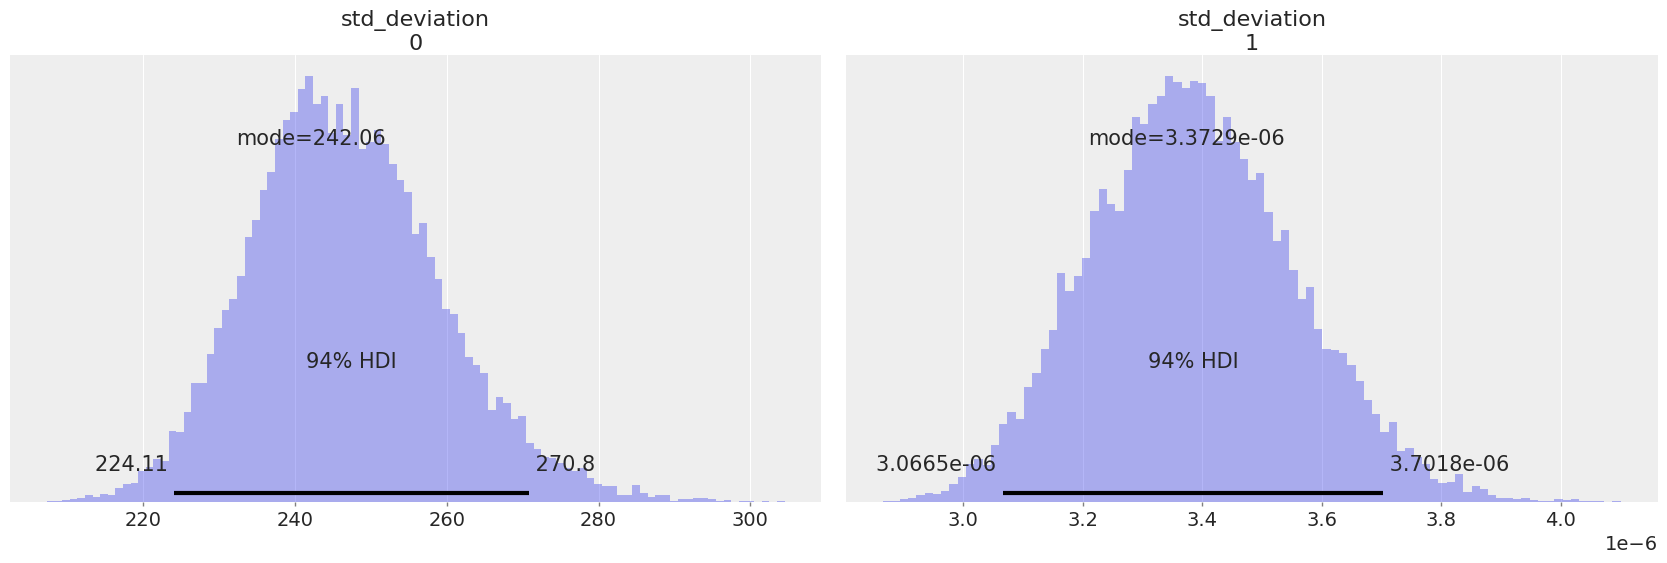

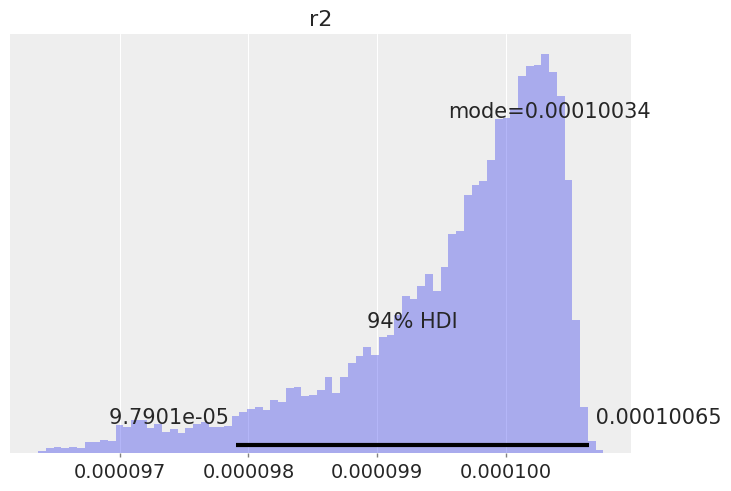

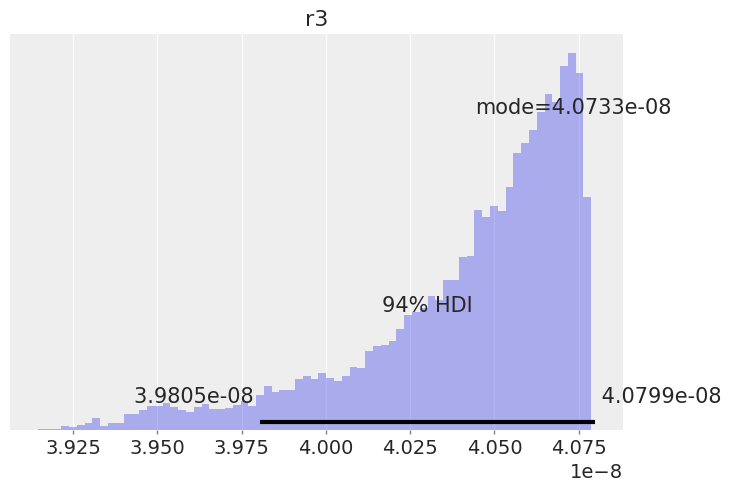

In [82]:
plot_step = 1
progress_bar = tqdm(calibration_variable_names)
for variable in progress_bar:
    pm.plot_posterior(
        trace_calibration_M02[::plot_step], 
        var_names=(f"{variable}"), 
        kind="hist", 
        round_to=5,
        point_estimate="mode"
    )
    plt.savefig(f"img/posterior_cal_{variable}_M02.png")

/home/tungdil/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/tungdil/.local/lib/python3.8/site-packages/arviz/stats/density_utils.py:241: RuntimeWarning: underflow encountered in exp
  f = np.sum(np.power(k_sq, l) * a_sq * np.exp(-k_sq * np.pi ** 2 * t))
/home/tungdil/.local/lib/python3.8/site-packages/arviz/stats/density_utils.py:249: RuntimeWarning: underflow encountered in exp
  f = np.sum(k_sq ** j * a_sq * np.exp(-k_sq * np.pi ** 2.0 * t_j))
/home/tungdil/.local/lib/python3.8/site-packages/arviz/stats/density_utils.py:249: RuntimeWarning: underflow encountered in multiply
  f = np.sum(k_sq ** j * a_sq * np.exp(-k_sq * np.pi ** 2.0 * t_j))
/home/tungdil/.local/lib/python3.8/site-packages/arviz/stats/densit

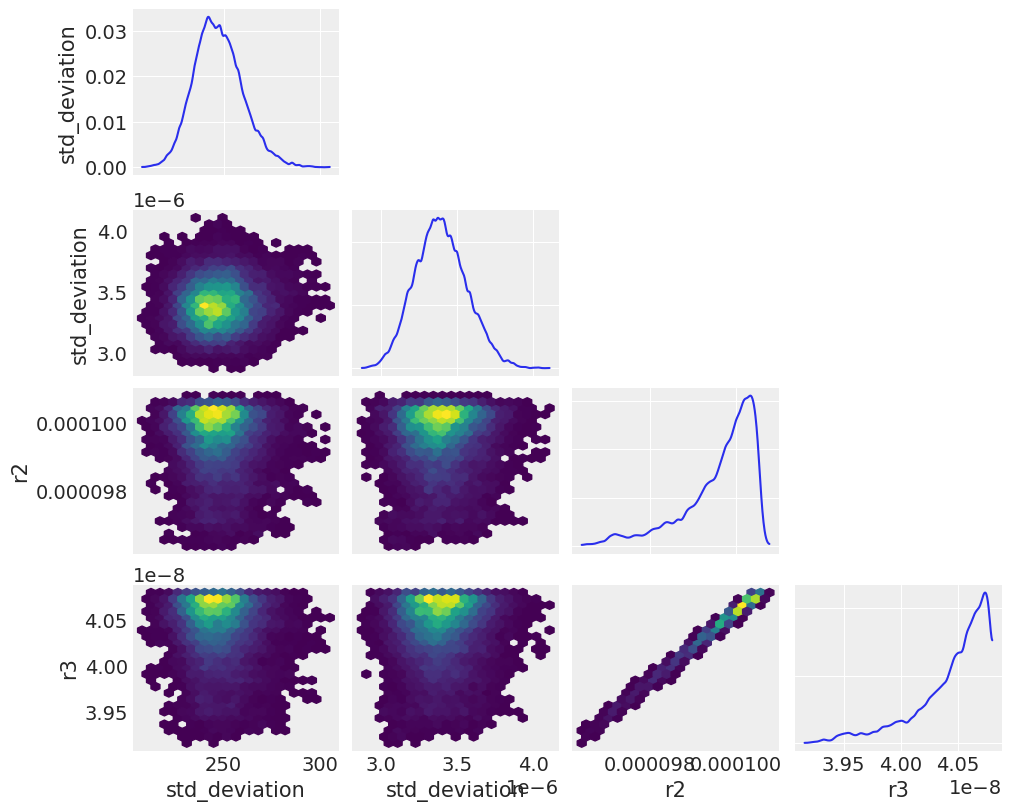

In [83]:
az.plot_pair(
    trace_calibration_M02,
    var_names=calibration_variable_names,
    kind="hexbin",
    fill_last=False,
    marginals=True,
    figsize=(10, 8),
)
plt.savefig("img/marginals_cal_M02.png")

In [84]:
df_stats_summary = az.summary(
    data=trace_calibration_M02,
    var_names=calibration_variable_names,
    kind='stats',
    round_to=15,  # rounding level display
)

df_stats_summary

/home/tungdil/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean            sd        hdi_3%       hdi_97%
std_deviation[0]  2.473554e+02  1.254284e+01  2.241058e+02  2.708034e+02
std_deviation[1]  3.392834e-06  1.702585e-07  3.066462e-06  3.701794e-06
r2                9.960678e-05  8.390726e-07  9.790110e-05  1.006460e-04
r3                4.043474e-08  3.194040e-10  3.980525e-08  4.079897e-08

In [85]:
calibration_variable_mpv = calculate_rv_posterior_mpv(
    pm_trace=trace_calibration_M02, variable_names=calibration_variable_names
)
df_stats_summary = add_mpv_to_summary(df_stats_summary, calibration_variable_mpv)
df_stats_summary.to_csv("csv/stats_summary_calibration_M02.csv")  # save in csv format

df_stats_summary

Calculating MPV from KDE for std_deviation:   0%|          | 0/3 [00:00<?, ?it/s]/home/tungdil/.local/lib/python3.8/site-packages/scipy/stats/kde.py:255: RuntimeWarning: underflow encountered in exp
  result += self.weights[i]*exp(-energy)
/home/tungdil/.local/lib/python3.8/site-packages/scipy/stats/kde.py:255: RuntimeWarning: underflow encountered in multiply
  result += self.weights[i]*exp(-energy)
Calculating MPV from KDE for r3: 100%|██████████| 3/3 [00:38<00:00, 12.74s/it]           


mean            sd        hdi_3%       hdi_97%  \
std_deviation[0]  2.473554e+02  1.254284e+01  2.241058e+02  2.708034e+02   
std_deviation[1]  3.392834e-06  1.702585e-07  3.066462e-06  3.701794e-06   
r2                9.960678e-05  8.390726e-07  9.790110e-05  1.006460e-04   
r3                4.043474e-08  3.194040e-10  3.980525e-08  4.079897e-08   

                           mpv  
std_deviation[0]  2.424847e+02  
std_deviation[1]  3.378332e-06  
r2                1.002712e-04  
r3                4.070982e-08

In [86]:
percentile_cut = 2.5

y_min = np.percentile(trace_calibration_M02["M02_model"], percentile_cut, axis=0)
y_max = np.percentile(trace_calibration_M02["M02_model"], 100 - percentile_cut, axis=0)
y_fit = np.percentile(trace_calibration_M02["M02_model"], 50, axis=0)

<ipython-input-87-36e867457e16>:46: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


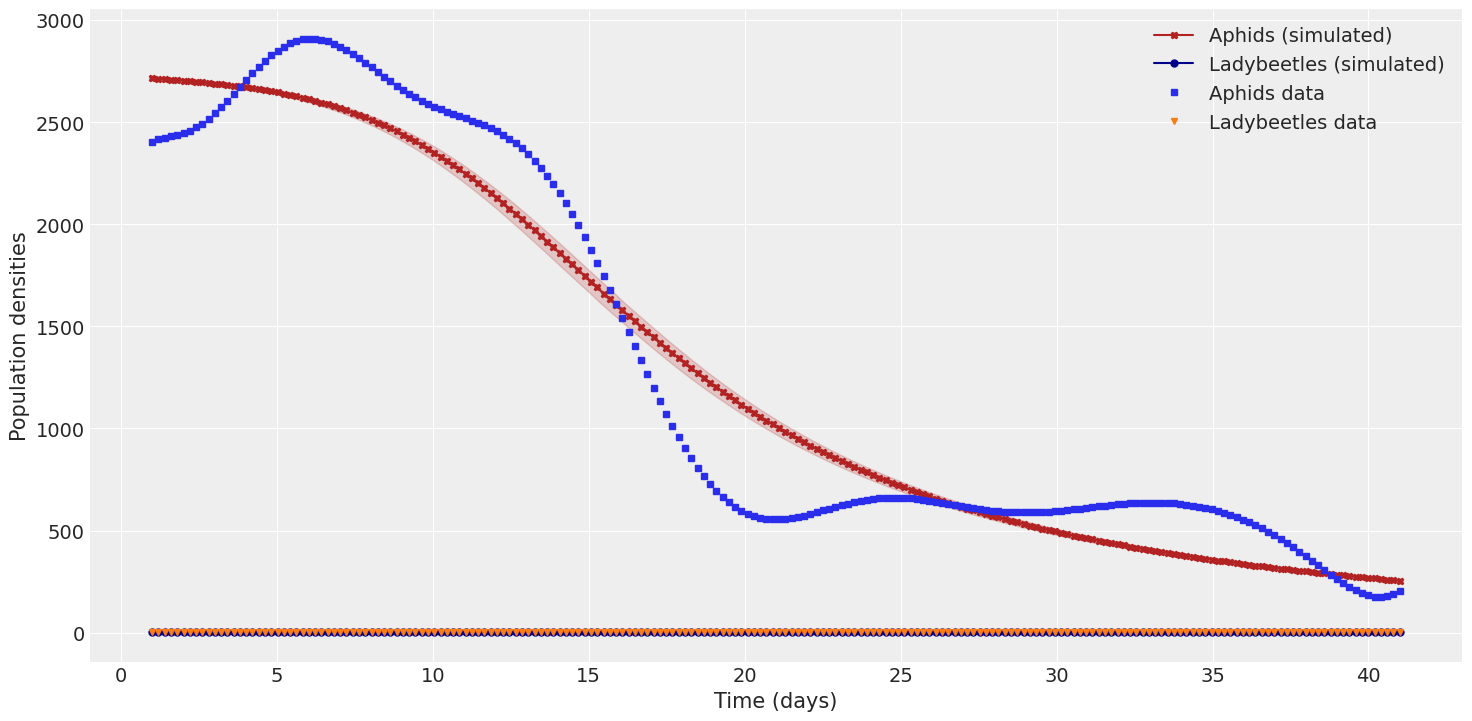

In [87]:
plt.figure(figsize=(15, 7.5))

plt.plot(
    time_observations,
    y_fit[:, 0],
    "firebrick",
    label="Aphids (simulated)",
    marker="X",
    linestyle="-",
    markersize=5,
)
plt.fill_between(time_observations, y_min[:, 0], y_max[:, 0], color="firebrick", alpha=0.2)

plt.plot(
    time_observations,
    y_fit[:, 1],
    "darkblue",
    label="Ladybeetles (simulated)",
    marker="o",
    linestyle="-",
    markersize=5,
)
plt.fill_between(time_observations, y_min[:, 1], y_max[:, 1], color="darkblue", alpha=0.2)

plt.plot(
    time_observations, 
    aphid_density, 
    label="Aphids data", 
    marker="s", 
    linestyle="", 
    markersize=5
)
plt.plot(
    time_observations, 
    ladybeetle_density, 
    label="Ladybeetles data", 
    marker="v", 
    linestyle="", 
    markersize=5
)

plt.legend(shadow=True)
plt.xlabel('Time (days)', fontsize=15)
plt.ylabel('Population densities', fontsize=15)

plt.tight_layout()
#plt.savefig("img/calibration_M02.png", dpi=300)
plt.show()

<ipython-input-137-16b1497eea87>:20: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


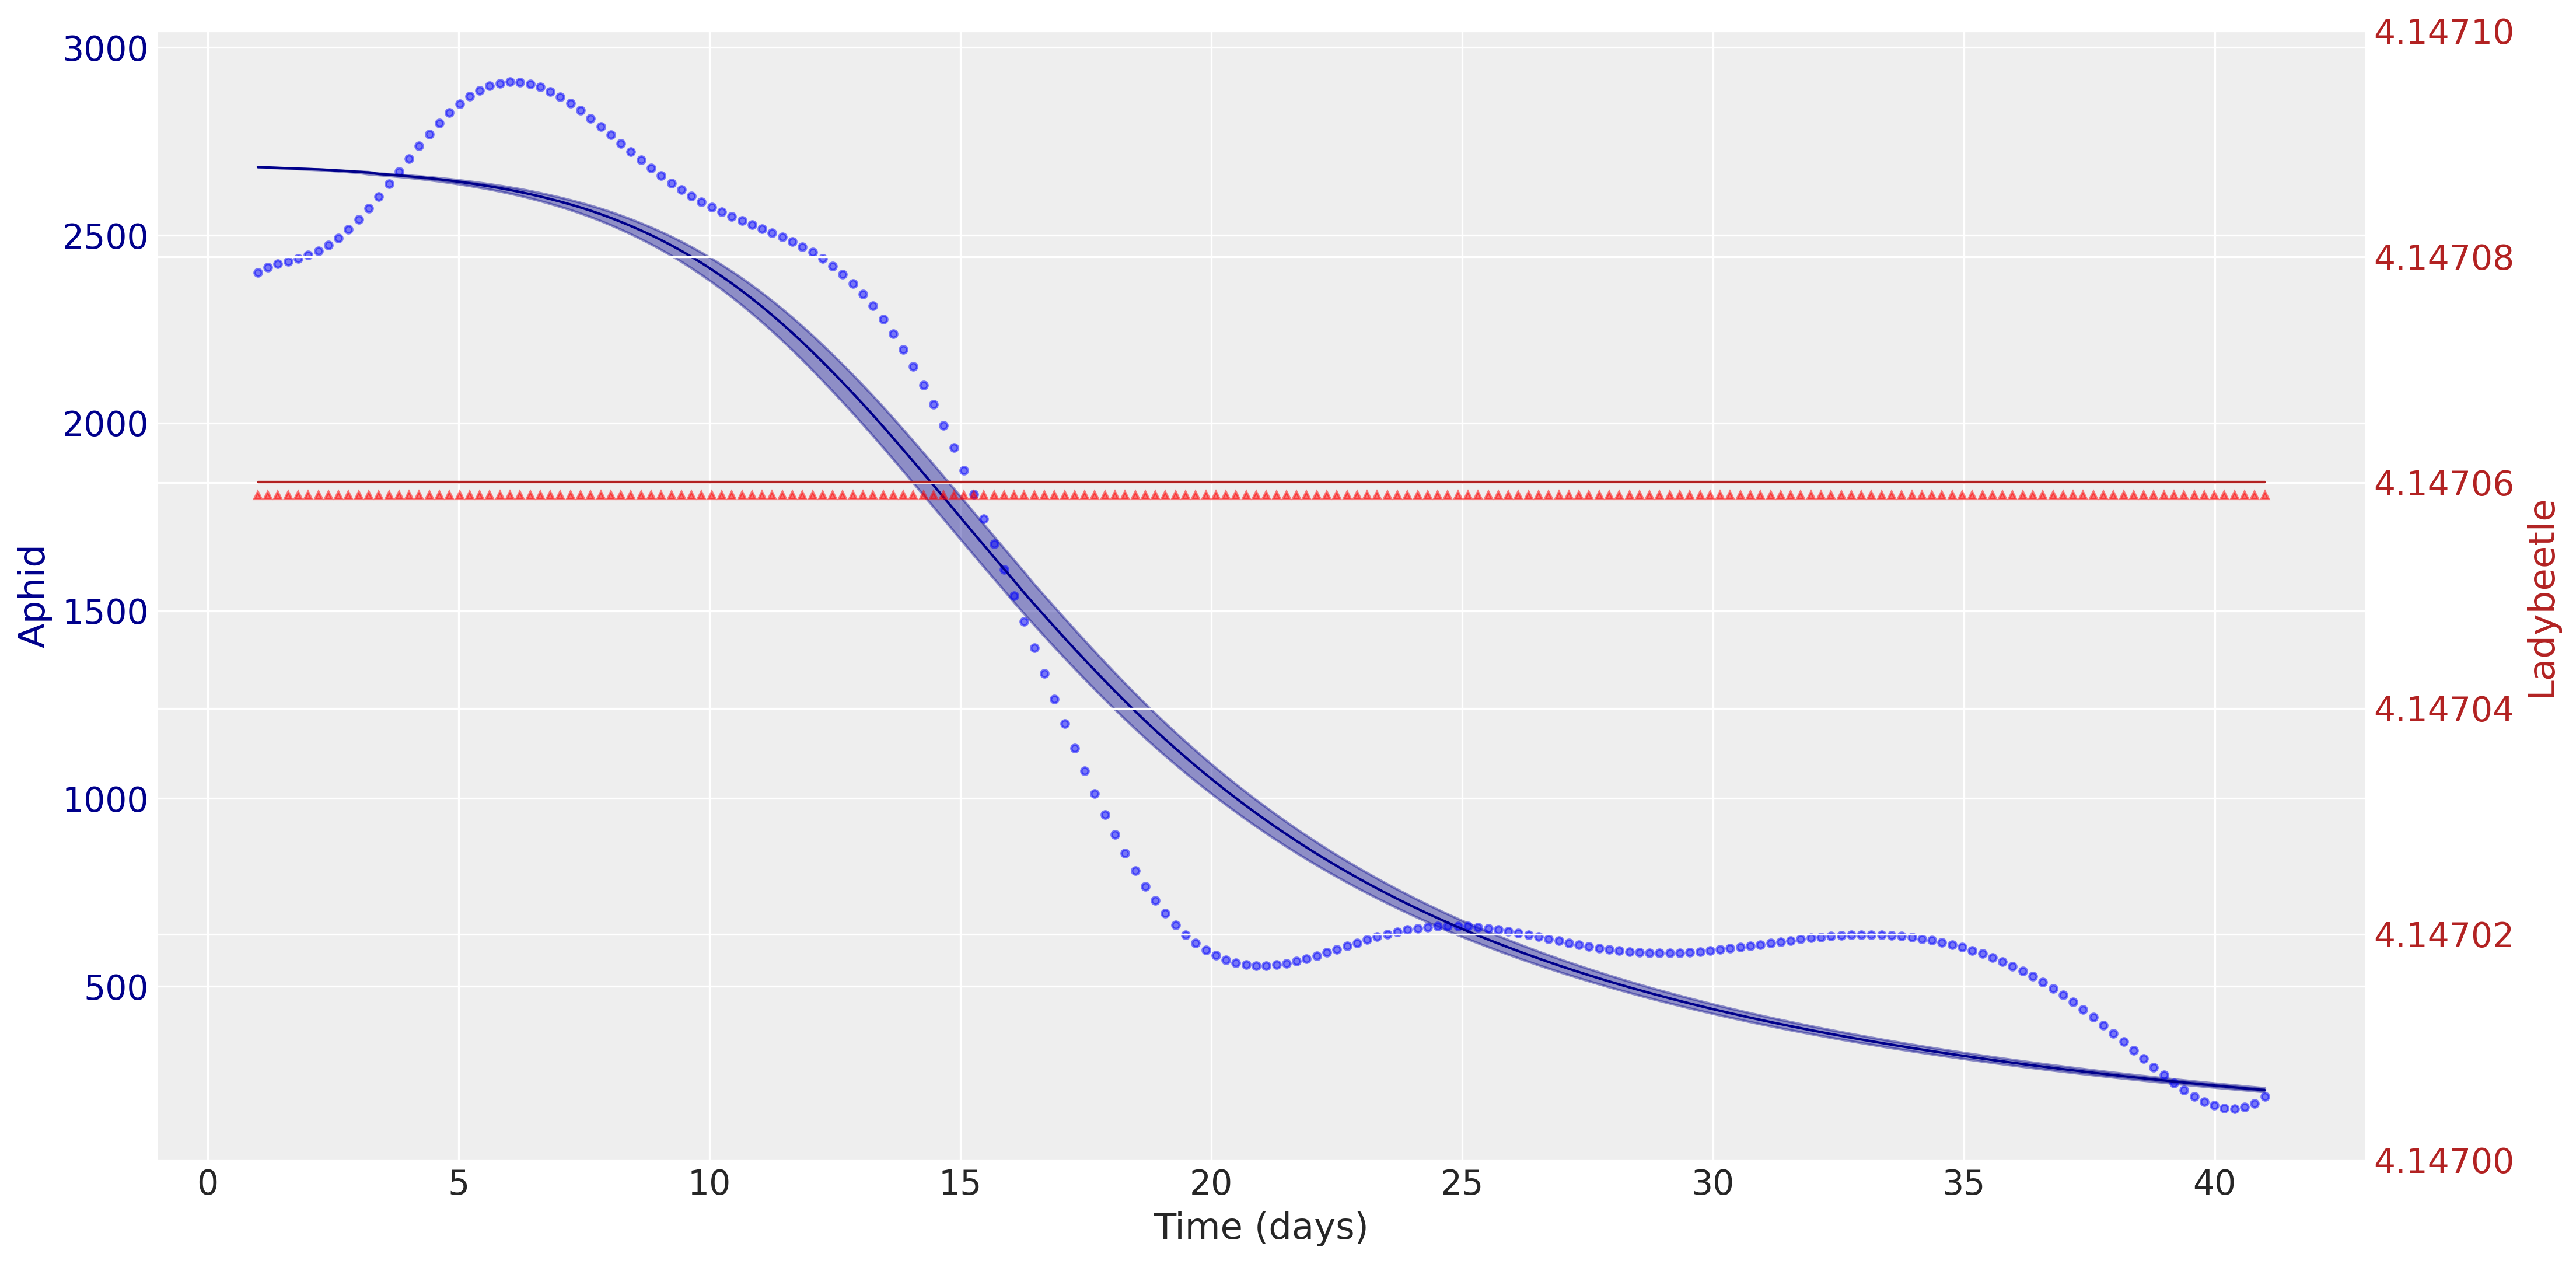

In [137]:
fig, ax1 = plt.subplots(1, 1, figsize = (15, 7.5), dpi = 300)
ax2 = ax1.twinx()
ax1.plot(time_observations, aphid_density, "bo", alpha = 0.5, markersize = 3)
ax2.plot(time_observations, ladybeetle_density, "r^", alpha = 0.5, markersize = 3)
ax1.plot(time_observations, y_fit[:, 0], "darkblue", alpha = 1.0, linewidth = 1)
ax2.plot(time_observations, y_fit[:, 1], "firebrick", alpha = 1.0, linewidth = 1)

ax1.fill_between(time_observations, y_min[:,0], y_max[:,0], color = "darkblue", alpha = 0.4)
ax2.fill_between(time_observations, y_min[:,1], y_max[:,1], color = "firebrick", alpha = 0.4)
ax1.set_xlabel(r"Time (days)")
ax1.set_ylabel(r"Aphid", color = "darkblue")
ax2.set_ylabel(r"Ladybeetle", color = "firebrick")
ax1.tick_params(axis = "y", labelcolor = "darkblue")
ax2.tick_params(axis = "y", labelcolor = "firebrick")
ax1.ticklabel_format(useOffset=False)
ax2.ticklabel_format(useOffset=False)

ax2.set_ylim([4.1470, 4.1471])

plt.tight_layout()
plt.savefig("img/calibration_M02.png", dpi=300)
plt.show()

In [89]:
print("-- Exporting calibrated parameter to CSV")

start_time = time.time()

dict_realizations = dict()  # save the realizations in a Python dictionary
progress_bar = tqdm(calibration_variable_names[1:])
for variable in progress_bar:
    progress_bar.set_description(f"Gathering {variable} realizations")
    parameter_realization = trace_calibration_M02.get_values(f"{variable}")
    dict_realizations[f"{variable}"] = parameter_realization

df_realizations = pd.DataFrame(dict_realizations)
df_realizations.to_csv("csv/calibration_realizations_M02.csv")

duration = time.time() - start_time

print(f"-- Exported done in {duration:.3f} seconds")

Gathering r3 realizations: 100%|██████████| 2/2 [00:00<00:00, 1718.62it/s]

-- Exporting calibrated parameter to CSV
-- Exported done in 0.110 seconds


In [90]:
df_realizations

r2            r3
0      0.0001  4.068403e-08
1      0.0001  4.067920e-08
2      0.0001  4.069880e-08
3      0.0001  4.071449e-08
4      0.0001  4.071449e-08
...       ...           ...
35995  0.0001  4.045169e-08
35996  0.0001  4.045169e-08
35997  0.0001  4.053152e-08
35998  0.0001  4.053152e-08
35999  0.0001  4.053152e-08

[36000 rows x 2 columns]

# Model 09

In [91]:
import matplotlib.pyplot as plt
from numba import jit
import numpy as np  # linear algebra
from scipy.integrate import solve_ivp  # to solve ODE system
import pandas as pd

y0 = 2681.4743756420753, 4.1470600152530155

@jit(nopython=True)
def M09_model(
    t,
    X,
    r2 = 9.028e-05,
    r3 = 3.678e-08,
    a12 = 1.601e-03,
):
    """
    Prey-Predator M09 Model python implementation.
    """
    u, v = X
    u_prime = - r2*u**2 + r3*u**3 - a12*u*v**2
    v_prime = 0.0
    return u_prime, v_prime

def M09_ode_solver(
    y0,
    t_span,
    t_eval,
    r2 = 9.028e-05,
    r3 = 3.678e-08,
    a12 = 1.601e-03,
):
    solution_ODE = solve_ivp(
        fun=M09_model,
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        args=(r2, r3, a12),
        method="LSODA",
    )
    return solution_ODE

t0 = time_list.min()
tf = time_list.max()
days_to_forecast = 0
time_list_range = np.linspace(t0, tf + days_to_forecast, len(time_list))

u_data = aphid_density
v_data = ladybeetle_density

* We now need to calibrate the parameters of the function. Firstly, we have to define a least-squares residual error function:

In [92]:
def M09_least_squares_error_ode(
    par, time_list_exp, f_exp, fitting_model, initial_conditions
):
    args = par
    f_exp1, f_exp2 = f_exp
    time_list_span = (time_list_exp.min(), time_list_exp.max())

    weighting_for_exp1_constraints = 1
    weighting_for_exp2_constraints = 1
    num_of_qoi = len(f_exp)

    try:
        y_model = fitting_model(initial_conditions, time_list_span, time_list_exp, *args)
    #         y_model = fitting_model(time_list_span, time_list_exp, *args)
        simulated_time_list = y_model.t
        simulated_ode_solution = y_model.y
        simulated_qoi1, simulated_qoi2 = simulated_ode_solution

        residual1 = f_exp1 - simulated_qoi1
        residual2 = f_exp2 - simulated_qoi2

        first_term = weighting_for_exp1_constraints * np.sum(residual1 ** 2.0)
        second_term = weighting_for_exp2_constraints * np.sum(residual2 ** 2.0)

        objective_function = 1 / num_of_qoi * (first_term + second_term)
    except ValueError:
        objective_function = 1e15

    return objective_function

def callback_de(xk, convergence):
    """
    This function is to show the optimization procedure progress.
    """
    print(f'parameters = {xk}\n')

* Now we calibrate minimizing the residual applying the Differential Evolution method, a global optimization method, provided by `scipy`:

In [93]:
from scipy import optimize

seed=seed

r2 = 9.028e-05
r3 = 3.678e-08
a12 = 1.601e-03
denom_min = 0.99
denom_max = 1.01
bounds_M09 = [
    ( ( r2 * denom_min ), ( r2 * denom_max ) ),
    ( ( r3 * denom_min ), ( r3 * denom_max ) ),
    ( ( a12 * denom_min ), ( a12 * denom_max ) ),
]

result_M09 = optimize.differential_evolution(
    M09_least_squares_error_ode,
    bounds=bounds_M09,
    args=(
        time_list,
        [aphid_density, ladybeetle_density],
        M09_ode_solver,
        y0,
    ),
    popsize=30,
    strategy="best1bin",
    tol=1e-5,
    recombination=0.95,
    mutation=0.6,
    maxiter=10000,
    polish=True,
    disp=True,
    seed=seed,
    callback=callback_de,
    workers=-1,
)

print(result_M09)

/home/tungdil/.local/lib/python3.8/site-packages/scipy/optimize/_differentialevolution.py:492: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  warnings.warn("differential_evolution: the 'workers' keyword has"


differential_evolution step 1: f(x)= 7.03749e+06
parameters = [9.06332349e-05 3.71154371e-08 1.61362289e-03]

differential_evolution step 2: f(x)= 7.03749e+06
parameters = [9.06332349e-05 3.71154371e-08 1.61362289e-03]

differential_evolution step 3: f(x)= 7.03749e+06
parameters = [9.06332349e-05 3.71154371e-08 1.61362289e-03]

differential_evolution step 4: f(x)= 7.0369e+06
parameters = [9.06746775e-05 3.71242854e-08 1.61483573e-03]

differential_evolution step 5: f(x)= 7.03547e+06
parameters = [9.06765508e-05 3.71274315e-08 1.61360634e-03]

differential_evolution step 6: f(x)= 7.0329e+06
parameters = [9.07057106e-05 3.71391115e-08 1.61483573e-03]

differential_evolution step 7: f(x)= 7.03145e+06
parameters = [9.07082884e-05 3.71444726e-08 1.61363293e-03]

differential_evolution step 8: f(x)= 7.03145e+06
parameters = [9.07082884e-05 3.71444726e-08 1.61363293e-03]

differential_evolution step 9: f(x)= 7.03106e+06
parameters = [9.06728040e-05 3.71415146e-08 1.61572818e-03]

differential

* Retrieving the calibrated parameter values:

In [94]:
t0 = time_list.min()
tf = time_list.max()
days_to_forecast = 0
time_list_range = np.linspace(t0, tf + days_to_forecast, 100)
(
    r2_deterministic,
    r3_deterministic,
    a12_deterministic,
) = result_M09.x

solution_ODE_M09 = M09_ode_solver(
    y0,
    (t0, tf + days_to_forecast), 
    time_list_range, 
    *result_M09.x
)
t_computed_M09, y_computed_M09 = solution_ODE_M09.t, solution_ODE_M09.y
u_M09, v_M09 = y_computed_M09

parameters_dict = {
    "Model": "M09",
    u"$r2$": r2_deterministic,
    u"$r3$": r3_deterministic,
    u"$a12$": a12_deterministic,
}

print("r2=" + str(r2_deterministic) + "\n" + "r3=" + str(r3_deterministic) + "\n" + "a12=" + str(a12_deterministic) )

df_parameters_calibrated = pd.DataFrame.from_records([parameters_dict])
#print(df_parameters_calibrated.to_latex(index=False))

r2=9.069315633442903e-05
r3=3.71477898629665e-08
a12=0.0016170094762767212


#### Simulation

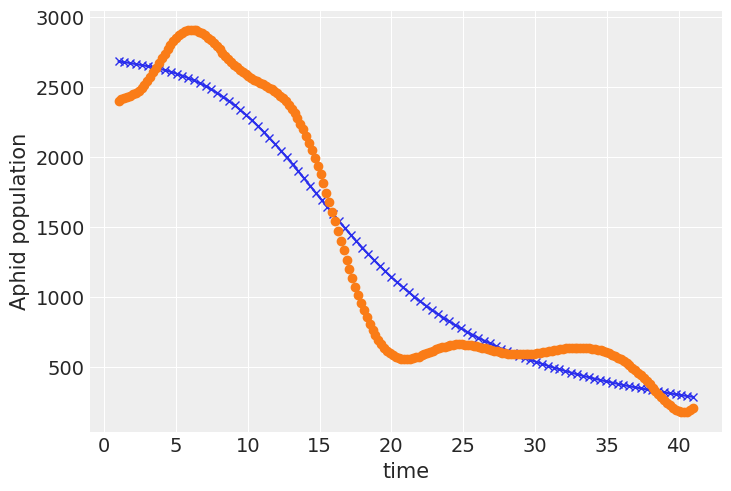

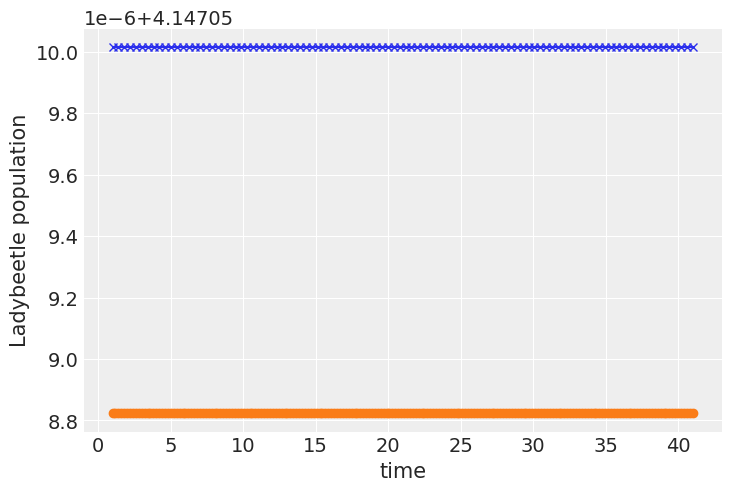

In [95]:
import matplotlib.pyplot as plt

aphid_observed = aphid_data[:].copy()
ladybeetle_observed = ladybeetle_data[:].copy()

plt.plot(t_computed_M09, u_M09, '-x')
plt.plot(time_list, aphid_density, 'o', label='Observed')

plt.xlabel('time')
plt.ylabel('Aphid population')
plt.show()

plt.plot(t_computed_M09, v_M09, '-x')
plt.plot(time_list, ladybeetle_density, 'o', label='Observed')
plt.xlabel('time')
plt.ylabel('Ladybeetle population')
plt.show()

## Sensitivity Analyses

### Least-Squares objective function

In [96]:
from SALib.sample.morris import sample as ee_sample

mean_values_params = [
    r2,
    r3,
    a12,
]
factors_names = [
    r"$r2$",
    r"$r3$",
    r"$a12$",
]
params_perturbations = 0.01
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [97]:
from tqdm import tqdm

num_of_realizations = parameter_values.shape[0]
qoi_sensitivity_outputs = np.zeros(num_of_realizations)

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    residual_least_squares_result = M09_least_squares_error_ode(
        parameters_realization,
        time_list,
        [u_data, v_data],
        M09_ode_solver,
        y0
    )
    
    qoi_sensitivity_outputs[realization_index] = residual_least_squares_result

100%|██████████| 16/16 [00:00<00:00, 995.02it/s]


In [98]:
from SALib.analyze.morris import analyze as ee_analyze

data_time_list = time_list
num_of_experimental_points = data_time_list.shape[0]

df_Si = pd.DataFrame(columns=[*problem_info['names']])

Si = ee_analyze(problem_info, parameter_values, qoi_sensitivity_outputs, num_levels=grid_level, seed=seed)
Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
for idx, param_name in enumerate(problem_info['names']):
    df_Si.loc[0, param_name] = Si['mu_star_normalized'][idx]

df_Si = df_Si.T
df_Si.rename(columns={0: r'$\mu^*$'}, inplace=True)
df_Si.sort_values(by=r'$\mu^*$', ascending=False, inplace=True)
df_Si

$\mu^*$
$r2$    0.490411
$r3$    0.466098
$a12$  0.0434909

<ipython-input-99-97cb1de3d104>:9: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


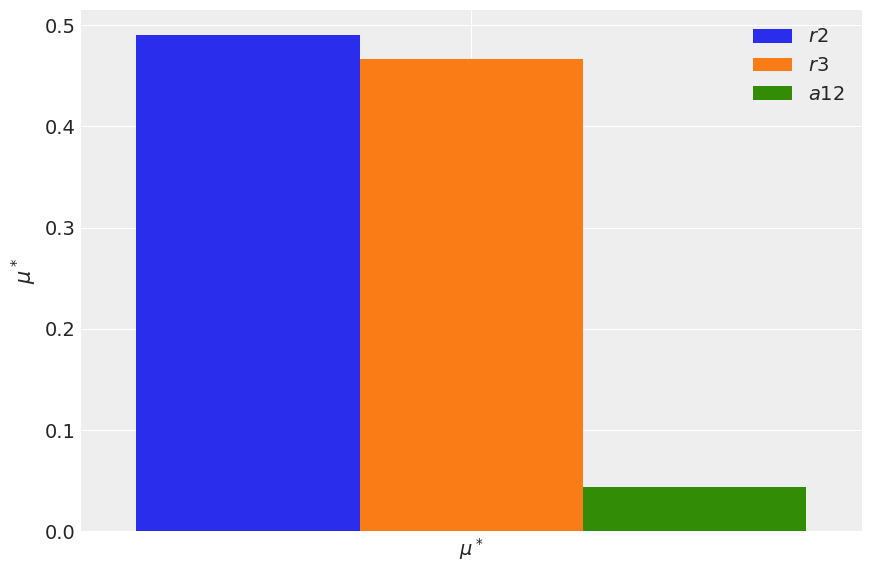

In [99]:
df_Si.T.plot.bar(rot=0, width=3, figsize=(9, 6))

plt.rcParams.update({'font.size': 16})

plt.ylabel(r"$\mu^*$")

plt.legend(fancybox=True, shadow=True)

plt.tight_layout()
#plt.savefig("img/sensitivity_least_squares_M09.png", dpi=300)
plt.show()

### Prey (pest) population

In [100]:
from SALib.sample.morris import sample as ee_sample

mean_values_params = [
    r2,
    r3,
    a12,
]
factors_names = [
    r"$r2$",
    r"$r3$",
    r"$a12$",
]
params_perturbations = 0.01
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [101]:
from tqdm import tqdm

t0 = time_list.min()
tf = time_list.max()
days_to_forecast = 0
time_list_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_list_points = time_list_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_list_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_M09 = M09_ode_solver(
        y0, 
        (t0, tf + days_to_forecast), 
        time_list_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_M09.y
    
    qoi_sensitivity_outputs[realization_index, :] = u_realization

100%|██████████| 16/16 [00:00<00:00, 830.58it/s]


In [102]:
from SALib.analyze.morris import analyze as ee_analyze

df_Si = pd.DataFrame(columns=['time_list', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['time_list', *problem_info['names']])
df_Si['time_list'] = time_list_range
df_sigmai['time_list'] = time_list_range
for time_list_point in tqdm(range(num_of_time_list_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_list_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_list_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_list_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='time_list', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='time_list', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_time_lists = df_Si.time_list.values
df_Si

  0%|          | 0/100 [00:00<?, ?it/s]/home/tungdil/.local/lib/python3.8/site-packages/numpy/ma/core.py:864: RuntimeWarning: underflow encountered in multiply
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
100%|██████████| 100/100 [00:00<00:00, 543.38it/s]


time_list      $r2$      $r3$      $a12$
0    1.404040  0.460301  0.490756  0.0489433
1    1.808081  0.467329  0.492304  0.0403665
2    2.212121  0.471987  0.482339   0.045674
3    2.616162  0.458115  0.493505    0.04838
4    3.020202  0.459301  0.491556  0.0491427
..        ...       ...       ...        ...
94  39.383838  0.564452  0.366223  0.0693245
95  39.787879  0.564163  0.366039  0.0697983
96  40.191919  0.563867  0.365823  0.0703093
97  40.595960  0.563559  0.365611  0.0708295
98  41.000000  0.563245  0.365424  0.0713305

[99 rows x 4 columns]

In [103]:
df_sigmai

time_list      $r2$      $r3$      $a12$
0    1.404040  0.673516  0.136303   0.190181
1    1.808081  0.413742  0.547886  0.0383727
2    2.212121   0.74602  0.130498   0.123482
3    2.616162  0.460966  0.262187   0.276848
4    3.020202  0.526798  0.212138   0.261064
..        ...       ...       ...        ...
94  39.383838  0.741085  0.202234  0.0566801
95  39.787879   0.74052   0.20267  0.0568095
96  40.191919  0.739889  0.203063   0.057048
97  40.595960  0.739337  0.203363  0.0573005
98  41.000000  0.739059  0.203523  0.0574181

[99 rows x 4 columns]

<ipython-input-104-3d3f73b1b26f>:12: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


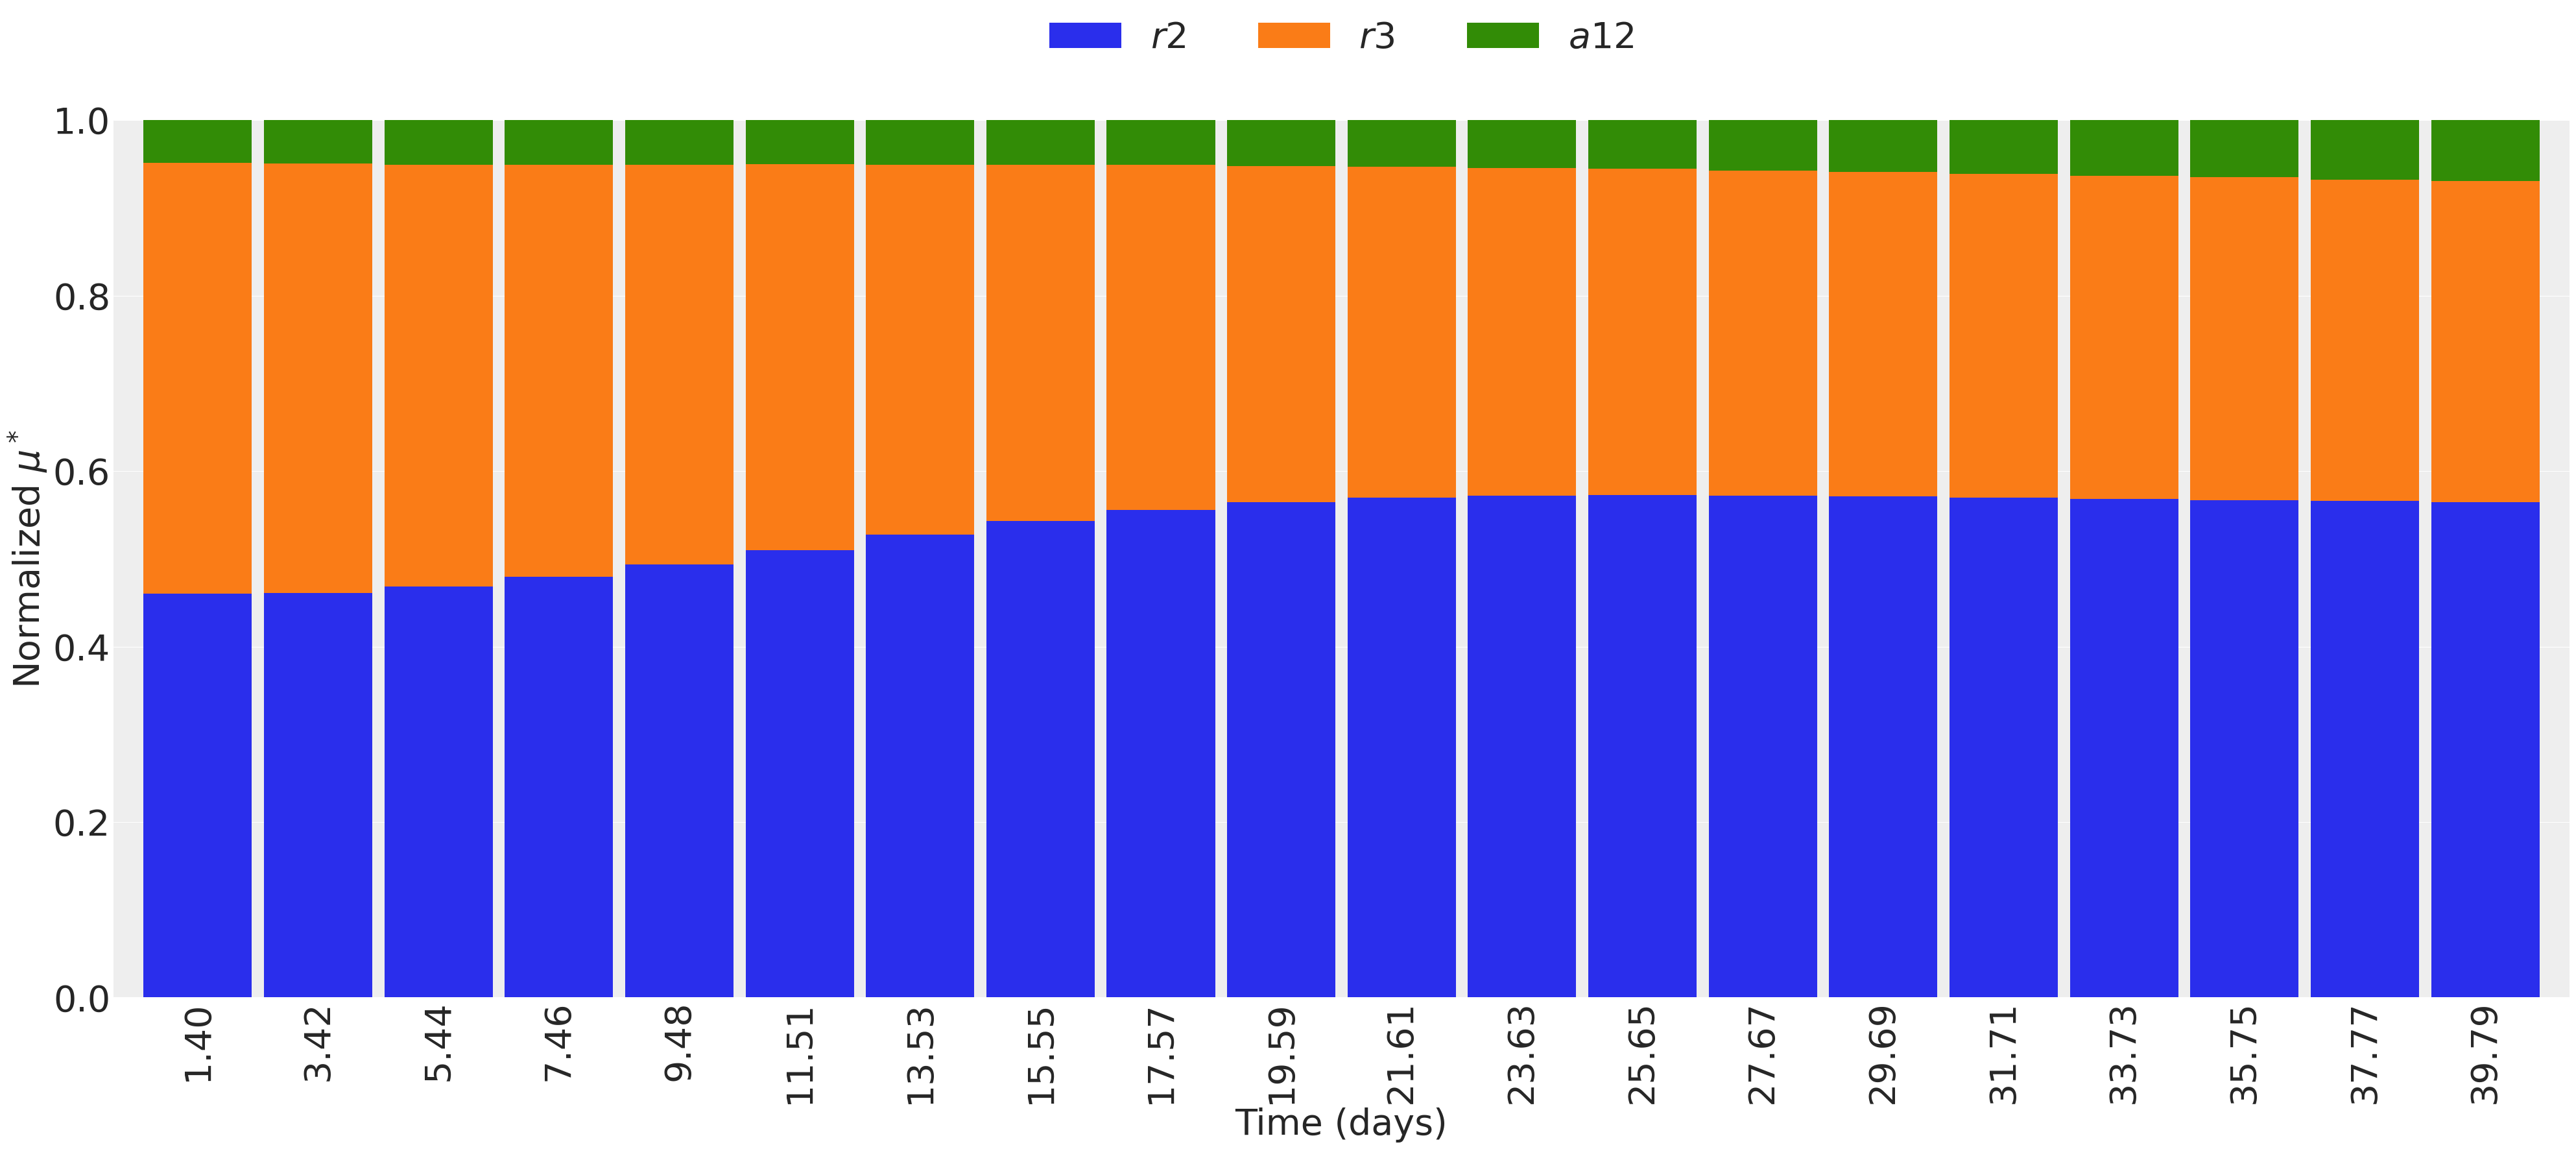

In [104]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 5
valid_time_lists_to_plot_mu = valid_time_lists[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='time_list', rot=90, width=0.9, figsize=(40, 18), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_time_lists_to_plot_mu[x]:.2f}")
plt.xlabel("Time (days)", fontsize = 40), plt.ylabel(r"Normalized $\mu^*$", fontsize = 40), plt.xticks(fontsize=40), plt.yticks(fontsize=40)

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True, fontsize=40)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_M09.png", dpi=300)
plt.show()

<ipython-input-105-d681049be977>:12: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


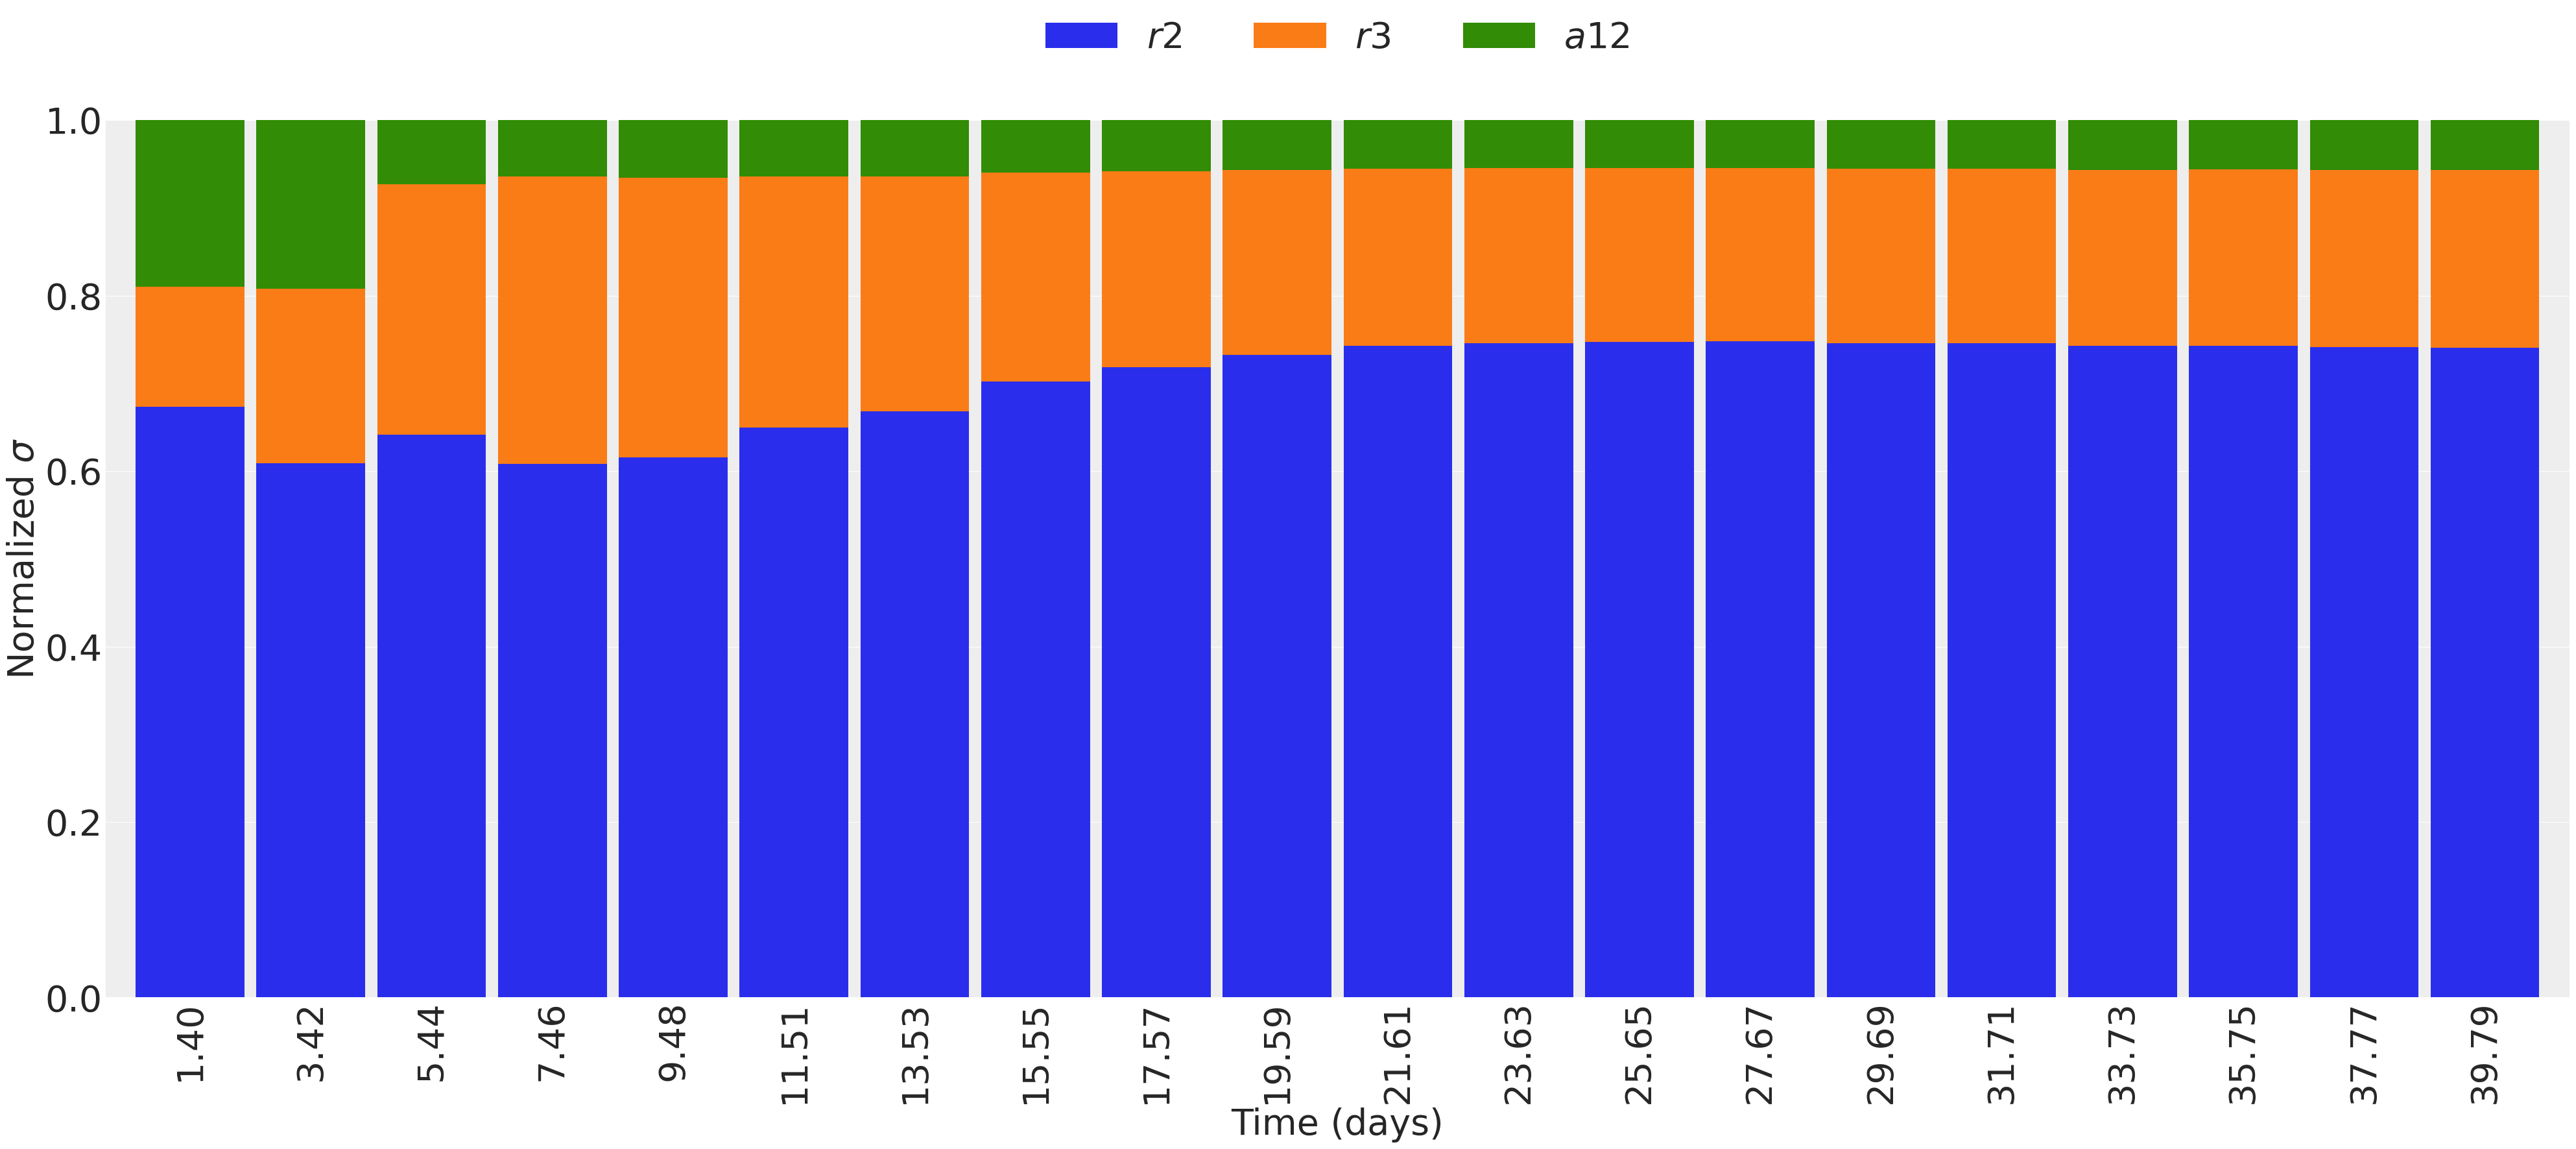

In [105]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 5
valid_time_lists_to_plot_sigma = valid_time_lists[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='time_list', rot=90, width=0.9, figsize=(40, 18), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_time_lists_to_plot_sigma[x]:.2f}")
plt.xlabel("Time (days)", fontsize = 40), plt.ylabel(r"Normalized $\sigma$", fontsize = 40), plt.xticks(fontsize=40), plt.yticks(fontsize=40)

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True, fontsize=40)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma_M09.png", dpi=300)
plt.show()

### time-derivative of pest (prey) population

In [106]:
def calculate_pest_time_list_derivative_series(
    time_list_array, 
    u_array, 
    v_array, 
    ode_model,
    model_pars
):
    pest_time_list_derivative_values = list()
    for t_idx, time_list in enumerate(time_list_array):
        u = u_array[t_idx]
        v = v_array[t_idx]
        stacked_population = [u, v]
        pest_time_list_derivative_value, _ = ode_model(time_list, stacked_population, *model_pars)
        pest_time_list_derivative_values.append(pest_time_list_derivative_value)
        
    pest_time_list_derivative_array = np.array(pest_time_list_derivative_values)
    return pest_time_list_derivative_array

In [107]:
pest_time_list_derivative_array = calculate_pest_time_list_derivative_series(
    t_computed_M09,
    u_M09,
    v_M09,
    M09_model,
    mean_values_params
)

pest_time_list_derivative_array

/home/tungdil/.local/lib/python3.8/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'X' of function 'M09_model'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-91-203e5adaba21>", line 10:
@jit(nopython=True)
def M09_model(
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


array([ -13.83175281,  -15.4065361 ,  -16.96840032,  -19.16883626,
        -20.97765578,  -22.99931838,  -25.27456304,  -27.80219793,
        -30.56993404,  -33.5642332 ,  -36.81913026,  -40.38180668,
        -44.2268295 ,  -48.32598073,  -52.65590777,  -57.25677177,
        -62.10375747,  -67.14742842,  -72.33541571,  -77.62149266,
        -82.96235215,  -88.29434157,  -93.55162091,  -98.66710497,
       -103.57006263, -108.14935458, -112.34165328, -116.10495819,
       -119.39919724, -122.18659048, -124.42061537, -126.06127641,
       -127.11520544, -127.5922117 , -127.50559264, -126.88688125,
       -125.77600404, -124.21169067, -122.2024236 , -119.90969316,
       -117.30889419, -114.4471463 , -111.37243401, -108.13210181,
       -104.77414361, -101.34576672,  -97.8927868 ,  -94.44770486,
        -91.01946505,  -87.6299348 ,  -84.29885593,  -81.04341227,
        -77.87524268,  -74.79776254,  -71.81733765,  -68.93884862,
        -66.16568395,  -63.49934039,  -60.93900359,  -58.48390

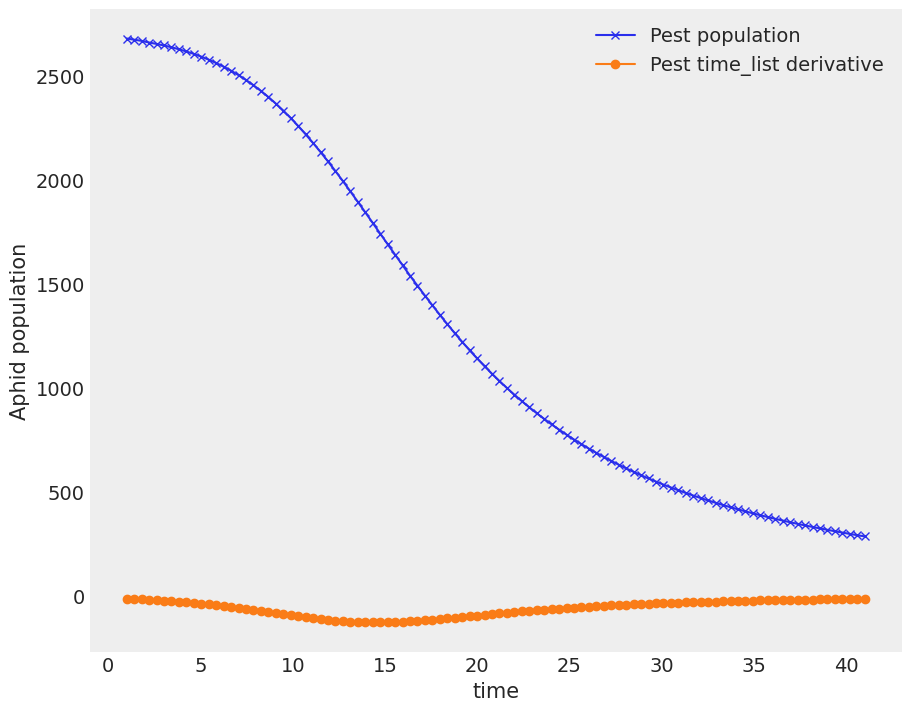

In [108]:
plt.figure(figsize=(9, 7))

plt.plot(t_computed_M09, u_M09, '-x', label='Pest population')
plt.plot(t_computed_M09, pest_time_list_derivative_array, '-o', label='Pest time_list derivative')

plt.xlabel('time')
plt.ylabel('Aphid population')

plt.grid()
plt.legend(shadow=True)

#plt.savefig("img/pest_derivative_M09.png", dpi=300)
plt.show()

In [109]:
mean_values_params = [
    r2,
    r3,
    a12,
]
factors_names = [
    r"$r2$",
    r"$r3$",
    r"$a12$",
]
params_perturbations = 0.01
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [110]:
t0 = time_list.min()
tf = time_list.max()
days_to_forecast = 0
time_list_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_list_points = time_list_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_list_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_M09 = M09_ode_solver(
        y0, 
        (t0, tf + days_to_forecast), 
        time_list_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_M09.y
    
    pest_time_list_derivative_array = calculate_pest_time_list_derivative_series(
        time_list_range,
        u_realization,
        v_realization,
        M09_model,
        parameters_realization
    )
    
    qoi_sensitivity_outputs[realization_index, :] = pest_time_list_derivative_array

100%|██████████| 16/16 [00:00<00:00, 703.77it/s]


In [111]:
df_Si = pd.DataFrame(columns=['time_list', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['time_list', *problem_info['names']])
df_Si['time_list'] = time_list_range
df_sigmai['time_list'] = time_list_range
for time_list_point in tqdm(range(num_of_time_list_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_list_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_list_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_list_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='time_list', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='time_list', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_time_lists = df_Si.time_list.values
df_Si

  0%|          | 0/100 [00:00<?, ?it/s]/home/tungdil/.local/lib/python3.8/site-packages/numpy/ma/core.py:864: RuntimeWarning: underflow encountered in multiply
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
100%|██████████| 100/100 [00:00<00:00, 550.49it/s]


time_list      $r2$      $r3$      $a12$
0    1.404040   0.45532  0.493277  0.0514032
1    1.808081  0.459066  0.491735  0.0491989
2    2.212121  0.462499  0.487311  0.0501902
3    2.616162  0.459918  0.489267  0.0508152
4    3.020202  0.462045  0.486991  0.0509641
..        ...       ...       ...        ...
94  39.383838  0.575393  0.372311  0.0522962
95  39.787879   0.57524  0.372295  0.0524649
96  40.191919   0.57508   0.37225  0.0526694
97  40.595960  0.574906  0.372213  0.0528811
98  41.000000  0.574727  0.372203  0.0530699

[99 rows x 4 columns]

In [112]:
df_sigmai

time_list      $r2$       $r3$      $a12$
0    1.404040  0.646415   0.253289   0.100295
1    1.808081  0.318412   0.647538  0.0340498
2    2.212121  0.807211  0.0962179  0.0965708
3    2.616162  0.588155   0.262907   0.148937
4    3.020202  0.572337   0.325177   0.102485
..        ...       ...        ...        ...
94  39.383838  0.748639   0.197008  0.0543537
95  39.787879  0.748093   0.197441  0.0544657
96  40.191919  0.747474   0.197844  0.0546817
97  40.595960  0.746923   0.198164  0.0549131
98  41.000000  0.746634    0.19835  0.0550165

[99 rows x 4 columns]

<ipython-input-113-060147ab7379>:12: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


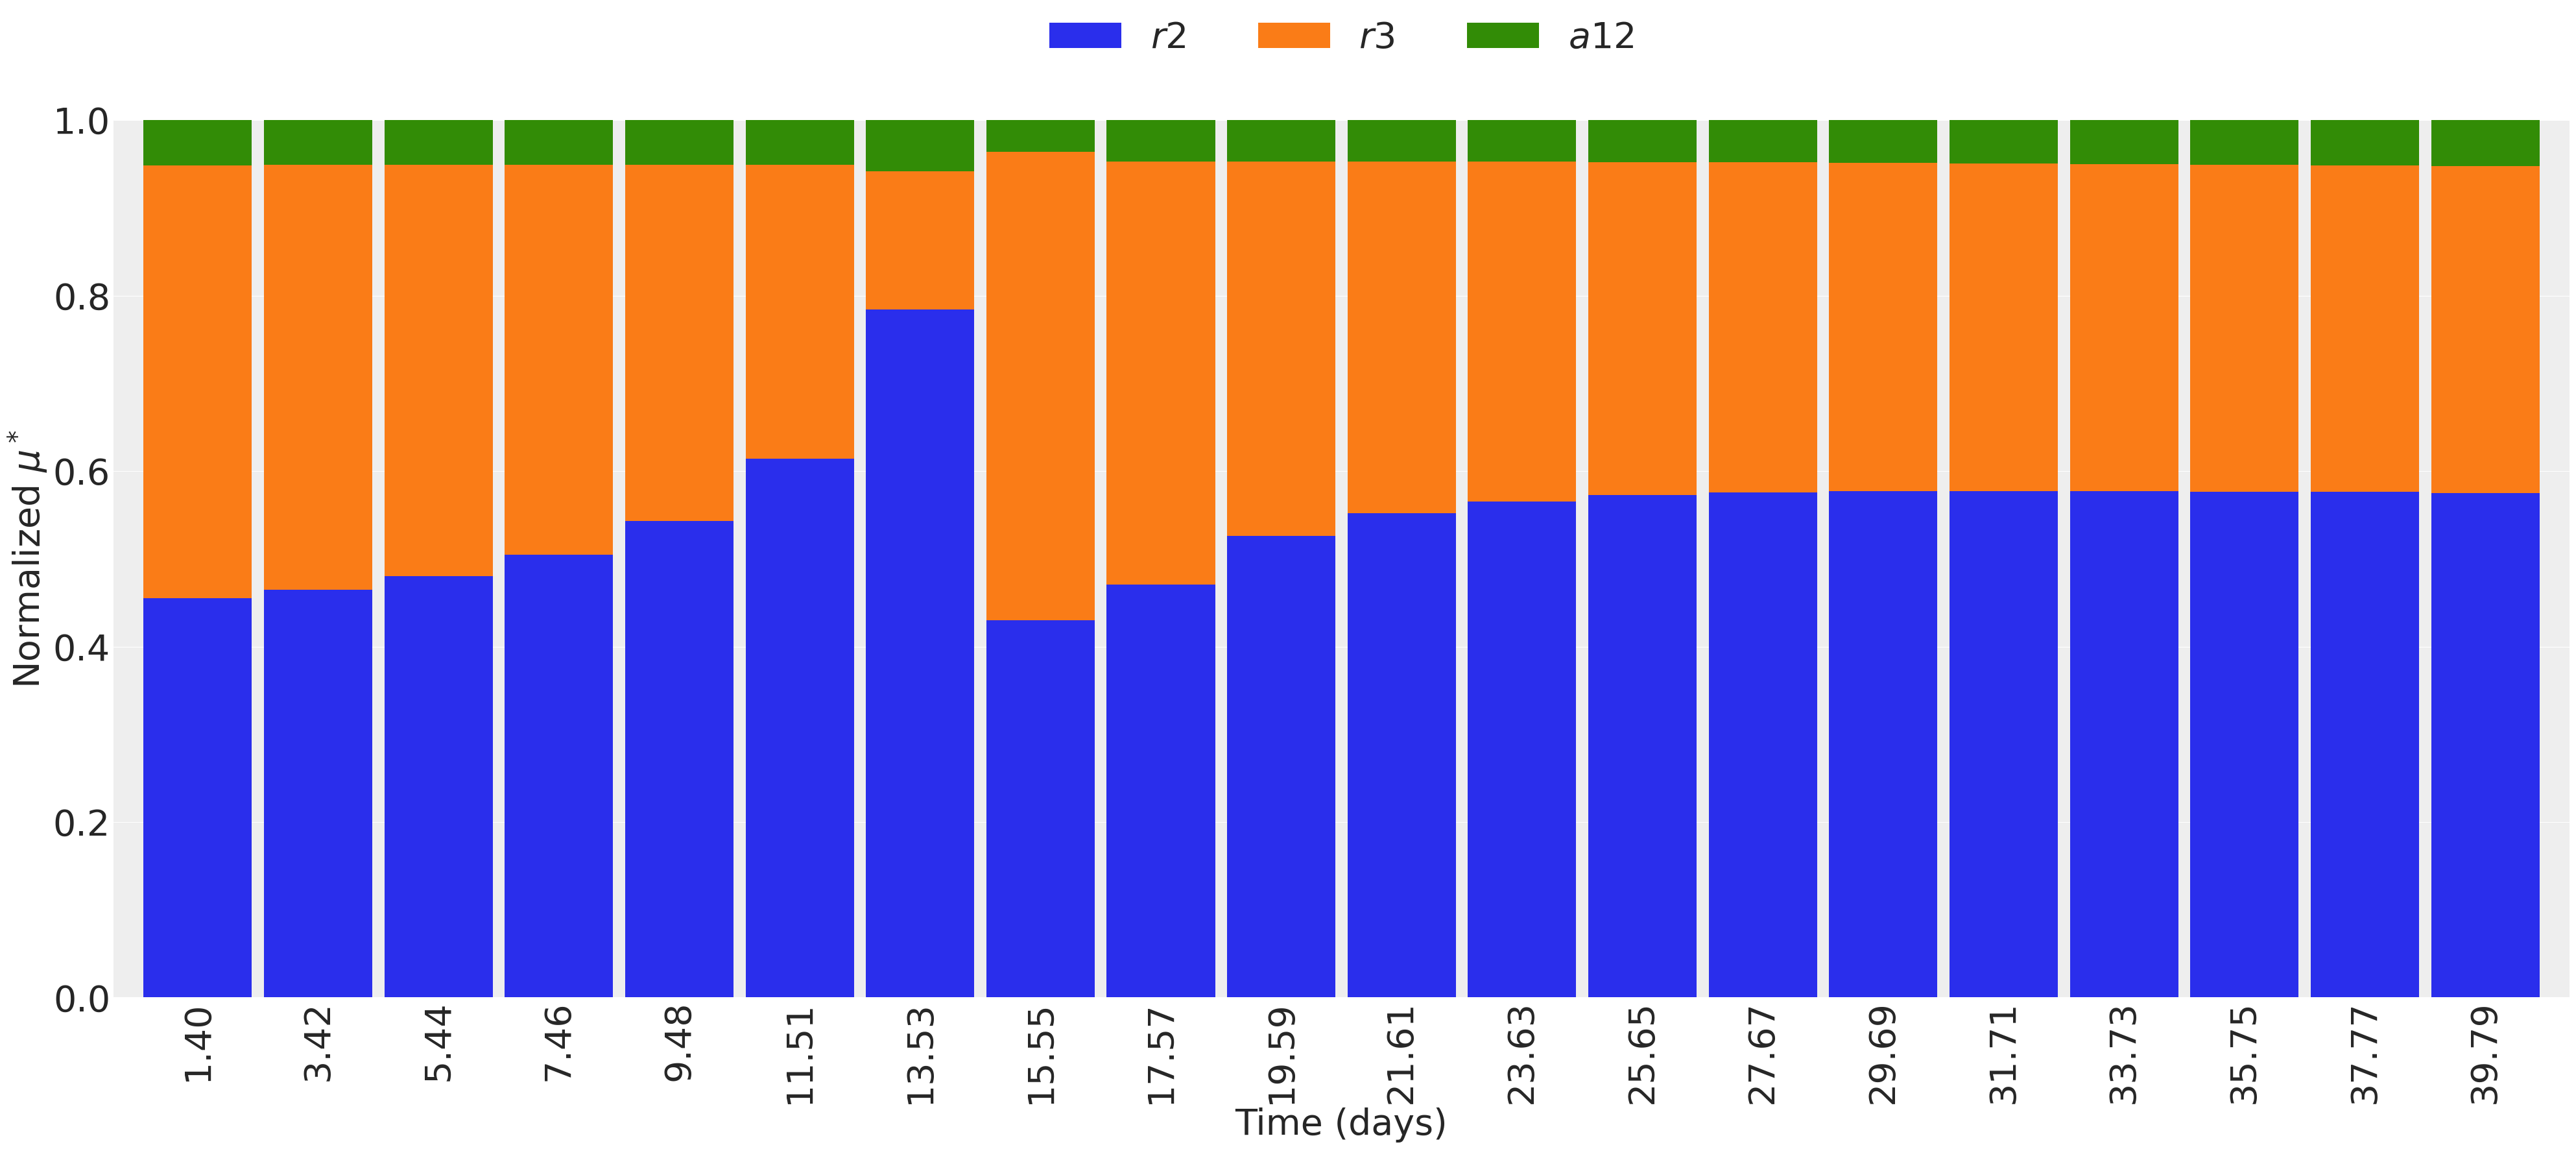

In [113]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 5
valid_time_lists_to_plot_mu = valid_time_lists[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='time_list', rot=90, width=0.9, figsize=(40, 18), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_time_lists_to_plot_mu[x]:.2f}")
plt.xlabel("Time (days)", fontsize = 40), plt.ylabel(r"Normalized $\mu^*$", fontsize = 40), plt.xticks(fontsize=40), plt.yticks(fontsize=40)

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True, fontsize=40)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_derivative_M09.png", dpi=300)
plt.show()

<ipython-input-114-21af1978898a>:12: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


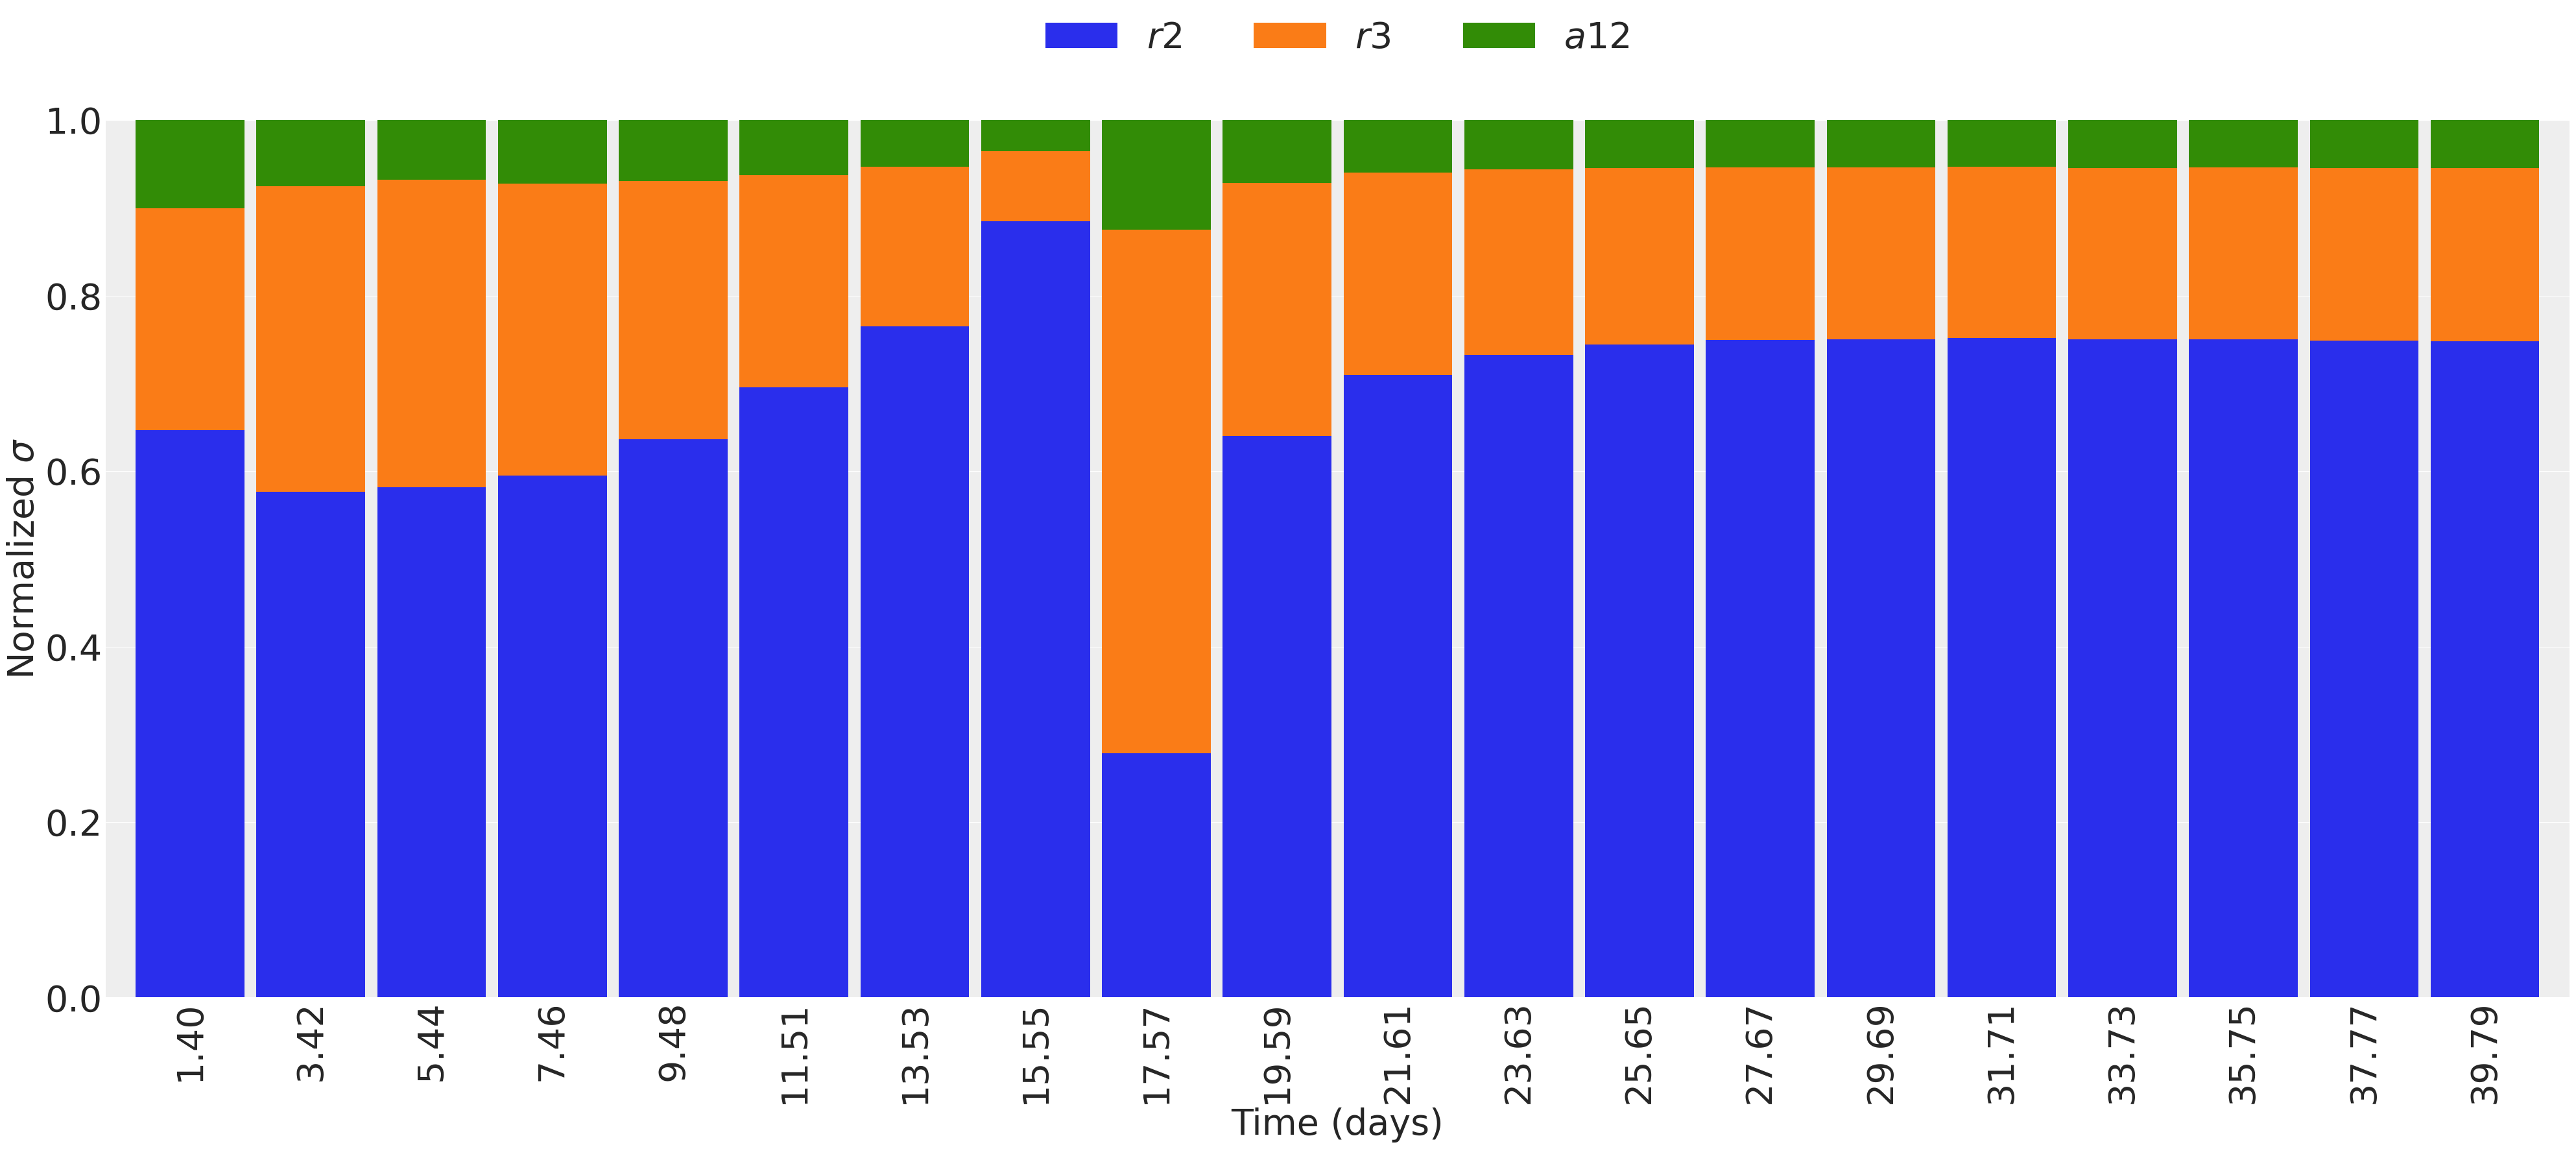

In [114]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 5
valid_time_lists_to_plot_sigma = valid_time_lists[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='time_list', rot=90, width=0.9, figsize=(40, 18), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_time_lists_to_plot_sigma[x]:.2f}")
plt.xlabel("Time (days)", fontsize = 40), plt.ylabel(r"Normalized $\sigma$", fontsize = 40), plt.xticks(fontsize=40), plt.yticks(fontsize=40)

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True, fontsize=40)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma_derivative_M09.png", dpi=300)
plt.show()

## Bayesian calibration

In [115]:
@theano.compile.ops.as_op(
    itypes=[
        t.dvector, 
        t.dscalar,  # r2
        t.dscalar,  # r3
        t.dscalar,  # a12
        t.dscalar,  # u0
        t.dscalar,  # v0
    ], 
    otypes=[t.dmatrix]
)
def M09_ode_wrapper(time_list_exp, r2,r3,a12, u0, v0):
    time_list_span = (time_list_exp.min(), time_list_exp.max())

    args = [r2,r3,a12]
    initial_conditions = np.array([u0, v0])
    y_model = solve_ivp(
        M09_model, 
        time_list_span, 
        initial_conditions, 
        t_eval=time_list_exp, 
        method='LSODA',
        args=args
    )
    simulated_time_list = y_model.t
    simulated_ode_solution = y_model.y
    simulated_qoi1, simulated_qoi2 = simulated_ode_solution

    concatenate_simulated_qoi = np.vstack([simulated_qoi1, simulated_qoi2]).T

    return concatenate_simulated_qoi

In [116]:
observed_aphids = aphid_density.astype(np.float64)
observed_ladybeetles = ladybeetle_density.astype(np.float64)
observations_to_fit = np.vstack([observed_aphids, observed_ladybeetles]).T  # note the transpose here
time_observations = time_list.astype(np.float64)

print("\n*** Performing Bayesian calibration ***")

print("-- Running Monte Carlo simulations:")
start_time = time.time()
percent_calibration = 0.1
with pm.Model() as fine_model_M09:
    # Prior distributions for the model's parameters
    r2_ = pm.Uniform(
        "r2",
        lower=0.000115,#(1.0 - percent_calibration) * r2,#
        upper=0.000125,#(1.0 + percent_calibration) * r2,#
    )
    r3_ = pm.Uniform(
        "r3",
        lower=4.65e-8,#(1.0 - percent_calibration) * r3,
        upper=5.06e-8,#(1.0 + percent_calibration) * r3,#
    )
    a12_ = pm.Data("a12", a12)
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=0, upper=260, shape=2)  # note 'shape' here

    # Wrapper for time_list. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "M09_model",
        M09_ode_wrapper(
            time_calibration,
            r2_,
            r3_,
            a12_,
            u0_,
            v0_
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit
    )
    
coarse_steps_1 = 4
observed_aphids_coarse_1 = observed_aphids[::coarse_steps_1]
observed_ladybeetles_coarse_1 = observed_ladybeetles[::coarse_steps_1]
observations_to_fit_coarse_1 = np.vstack(
    [observed_aphids_coarse_1, observed_ladybeetles_coarse_1]
).T
time_observations_coarse_1 = time_observations[::coarse_steps_1]

with pm.Model() as coarse_model_1:
    # Prior distributions for the model's parameters
    r2_ = pm.Uniform(
        "r2",
        lower=0.000115,#(1.0 - percent_calibration) * r2,#
        upper=0.000125,#(1.0 + percent_calibration) * r2,#
    )
    r3_ = pm.Uniform(
        "r3",
        lower=4.65e-8,#(1.0 - percent_calibration) * r3,
        upper=5.06e-8,#(1.0 + percent_calibration) * r3,#
    )
    a12_ = pm.Data("a12", a12)
    
    # Prioris for Initial Conditions
    u0, v0 = y0
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=0, upper=260, shape=2)  # note 'shape' here

    # Wrapper for time_list. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations_coarse_1)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "M09_model",
        M09_ode_wrapper(
            time_calibration,
            r2_,
            r3_,
            a12_,
            u0_,
            v0_
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit_coarse_1
    )


with fine_model_M09:
    step = pm.MLDA(coarse_models=[coarse_model_1], subsampling_rates=[5])
#     step = pm.DEMetropolisZ()
    trace_calibration_M09 = pm.sample(draws=6000, chains=6, cores=6, tune=2000, step=step, random_seed=seed)

duration = time.time() - start_time

print(f"-- Monte Carlo simulations done in {duration / 60:.3f} minutes")


*** Performing Bayesian calibration ***
-- Running Monte Carlo simulations:


/home/tungdil/.local/lib/python3.8/site-packages/pymc3/step_methods/mlda.py:385: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  warnings.warn(
/home/tungdil/.local/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Multiprocess sampling (6 chains in 6 jobs)
MLDA: [std_deviation, r3, r2]


/home/tungdil/.local/lib/python3.8/site-packages/pymc3/step_methods/mlda.py:770: RuntimeWarning: overflow encountered in exp
  stats = {"tune": self.tune, "accept": np.exp(accept), "accepted": accepted}
/home/tungdil/.local/lib/python3.8/site-packages/pymc3/step_methods/metropolis.py:849: RuntimeWarning: underflow encountered in exp
  "accept": np.exp(accept),
/home/tungdil/.local/lib/python3.8/site-packages/pymc3/step_methods/metropolis.py:849: RuntimeWarning: underflow encountered in exp
  "accept": np.exp(accept),
/home/tungdil/.local/lib/python3.8/site-packages/pymc3/step_methods/metropolis.py:849: RuntimeWarning: underflow encountered in exp
  "accept": np.exp(accept),
/home/tungdil/.local/lib/python3.8/site-packages/pymc3/step_methods/mlda.py:770: RuntimeWarning: overflow encountered in exp
  stats = {"tune": self.tune, "accept": np.exp(accept), "accepted": accepted}
/home/tungdil/.local/lib/python3.8/site-packages/pymc3/step_methods/metropolis.py:849: RuntimeWarning: underflow e

-- Monte Carlo simulations done in 6.884 minutes


In [117]:
calibration_variable_names = [
    "std_deviation",
    "r2",
    "r3",
]

  0%|          | 0/3 [00:00<?, ?it/s]/home/tungdil/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/tungdil/.local/lib/python3.8/site-packages/arviz/stats/density_utils.py:241: RuntimeWarning: underflow encountered in exp
  f = np.sum(np.power(k_sq, l) * a_sq * np.exp(-k_sq * np.pi ** 2 * t))
/home/tungdil/.local/lib/python3.8/site-packages/arviz/stats/density_utils.py:249: RuntimeWarning: underflow encountered in exp
  f = np.sum(k_sq ** j * a_sq * np.exp(-k_sq * np.pi ** 2.0 * t_j))
/home/tungdil/.local/lib/python3.8/site-packages/arviz/stats/density_utils.py:249: RuntimeWarning: underflow encountered in multiply
  f = np.sum(k_sq ** j * a_sq * np.exp(-k_sq * np.pi ** 2.0 * t_j))
/home/tungdil/.local/lib/pytho

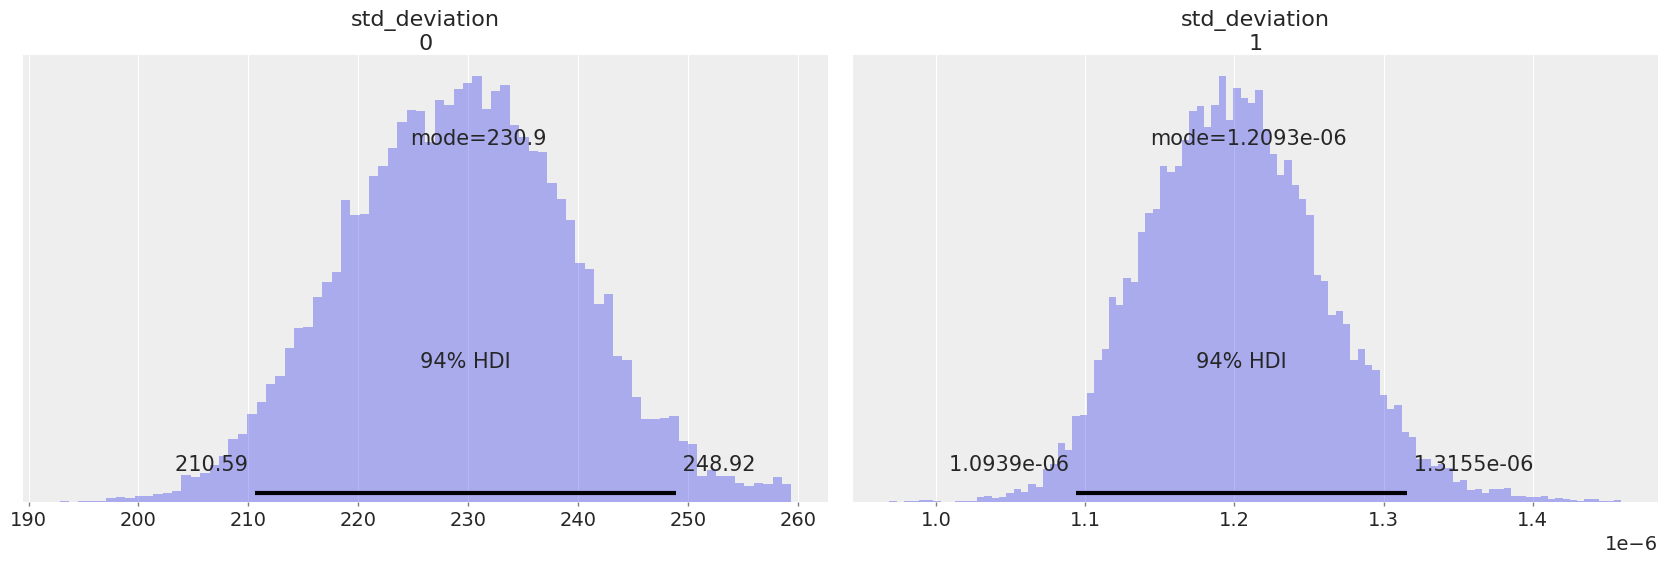

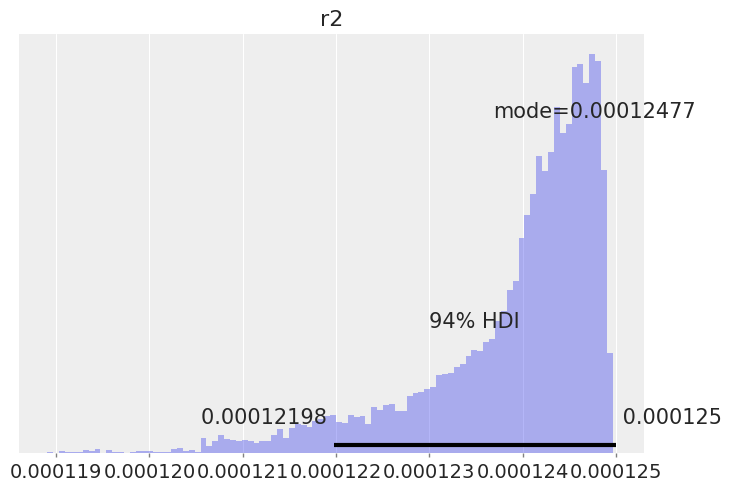

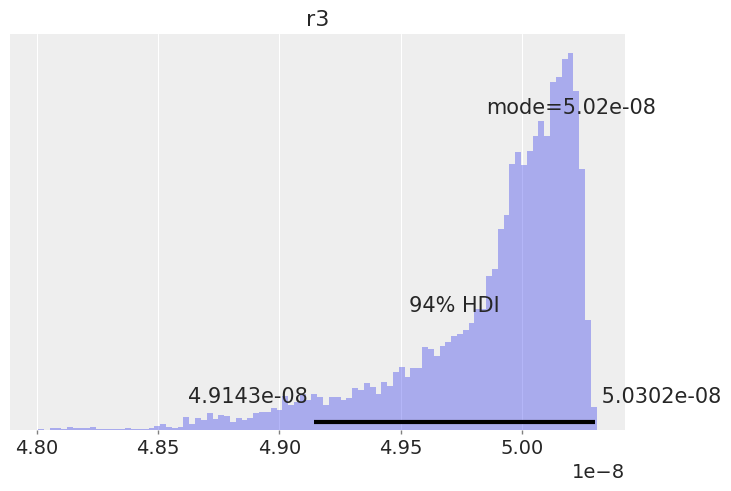

In [118]:
plot_step = 1
progress_bar = tqdm(calibration_variable_names)
for variable in progress_bar:
    pm.plot_posterior(
        trace_calibration_M09[::plot_step], 
        var_names=(f"{variable}"), 
        kind="hist", 
        round_to=5,
        point_estimate="mode"
    )
    plt.savefig(f"img/posterior_cal_{variable}_M09.png")

/home/tungdil/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/tungdil/.local/lib/python3.8/site-packages/arviz/stats/density_utils.py:241: RuntimeWarning: underflow encountered in exp
  f = np.sum(np.power(k_sq, l) * a_sq * np.exp(-k_sq * np.pi ** 2 * t))
/home/tungdil/.local/lib/python3.8/site-packages/arviz/stats/density_utils.py:249: RuntimeWarning: underflow encountered in exp
  f = np.sum(k_sq ** j * a_sq * np.exp(-k_sq * np.pi ** 2.0 * t_j))
/home/tungdil/.local/lib/python3.8/site-packages/arviz/stats/density_utils.py:249: RuntimeWarning: underflow encountered in multiply
  f = np.sum(k_sq ** j * a_sq * np.exp(-k_sq * np.pi ** 2.0 * t_j))
/home/tungdil/.local/lib/python3.8/site-packages/arviz/stats/densit

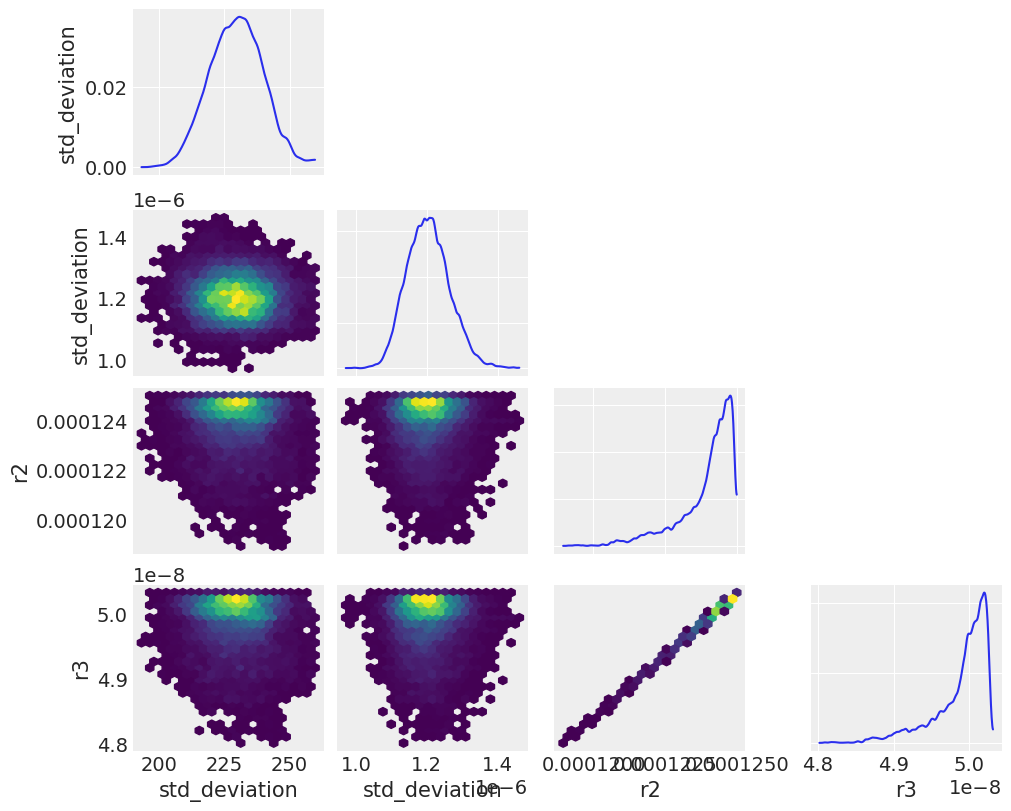

In [119]:
az.plot_pair(
    trace_calibration_M09,
    var_names=calibration_variable_names,
    kind="hexbin",
    fill_last=False,
    marginals=True,
    figsize=(10, 8),
)
plt.savefig("img/marginals_cal_M09.png")

In [120]:
df_stats_summary = az.summary(
    data=trace_calibration_M09,
    var_names=calibration_variable_names,
    kind='stats',
    round_to=15,  # rounding level display
)

df_stats_summary

/home/tungdil/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean            sd        hdi_3%       hdi_97%
std_deviation[0]  2.296590e+02  1.023870e+01  2.105852e+02  2.489213e+02
std_deviation[1]  1.204043e-06  6.041805e-08  1.093937e-06  1.315498e-06
r2                1.239365e-04  9.640017e-07  1.219755e-04  1.249976e-04
r3                4.989375e-08  3.655460e-10  4.914312e-08  5.030187e-08

In [121]:
from scipy.stats import gaussian_kde  # to calculate MPV from KDE

def _scalar_rv_mvp_estimation(rv_realization_values: np.ndarray) -> np.ndarray:
    num_of_realizations = len(rv_realization_values)
    kernel = gaussian_kde(rv_realization_values)
    equally_spaced_samples = np.linspace(
        rv_realization_values.min(),
        rv_realization_values.max(),
        num_of_realizations
    )
    kde = kernel(equally_spaced_samples)
    kde_max_index = np.argmax(kde)
    rv_mpv_value = equally_spaced_samples[kde_max_index]
    return rv_mpv_value


def calculate_rv_posterior_mpv(pm_trace, variable_names: list) -> dict:
    rv_mpv_values_dict = dict()
    progress_bar = tqdm(variable_names)
    for variable in progress_bar:
        progress_bar.set_description(f"Calculating MPV from KDE for {variable}")
        rv_realization_values = pm_trace[f"{variable}"]

        try:
            num_of_dimensions = rv_realization_values.shape[1]
        except IndexError:
            num_of_dimensions = 0

        if num_of_dimensions == 0:
            rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values)
            rv_mpv_values_dict[f"{variable}"] = rv_mpv_value
        else:
            for dimension in range(num_of_dimensions):
                variable_name_decomposed = f"{variable}[{dimension}]"
                rv_realization_values_decomposed = np.array(rv_realization_values[:, dimension])
                rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values_decomposed)
                rv_mpv_values_dict[f"{variable_name_decomposed}"] = rv_mpv_value

    return rv_mpv_values_dict


def add_mpv_to_summary(arviz_summary: pd.DataFrame, rv_modes_dict: dict) -> pd.DataFrame:
    new_arviz_summary = arviz_summary.copy()
    variable_names = list(rv_modes_dict.keys())
    rv_mode_values = list(rv_modes_dict.values())
    new_arviz_summary["mpv"] = pd.Series(data=rv_mode_values, index=variable_names)
    return new_arviz_summary

In [122]:
calibration_variable_mpv = calculate_rv_posterior_mpv(
    pm_trace=trace_calibration_M09, variable_names=calibration_variable_names
)
df_stats_summary = add_mpv_to_summary(df_stats_summary, calibration_variable_mpv)
df_stats_summary.to_csv("csv/stats_summary_calibration_M09.csv")  # save in csv format

df_stats_summary

Calculating MPV from KDE for std_deviation:   0%|          | 0/3 [00:00<?, ?it/s]/home/tungdil/.local/lib/python3.8/site-packages/scipy/stats/kde.py:255: RuntimeWarning: underflow encountered in exp
  result += self.weights[i]*exp(-energy)
/home/tungdil/.local/lib/python3.8/site-packages/scipy/stats/kde.py:255: RuntimeWarning: underflow encountered in multiply
  result += self.weights[i]*exp(-energy)
Calculating MPV from KDE for r3: 100%|██████████| 3/3 [00:40<00:00, 13.49s/it]           


mean            sd        hdi_3%       hdi_97%  \
std_deviation[0]  2.296590e+02  1.023870e+01  2.105852e+02  2.489213e+02   
std_deviation[1]  1.204043e-06  6.041805e-08  1.093937e-06  1.315498e-06   
r2                1.239365e-04  9.640017e-07  1.219755e-04  1.249976e-04   
r3                4.989375e-08  3.655460e-10  4.914312e-08  5.030187e-08   

                           mpv  
std_deviation[0]  2.310398e+02  
std_deviation[1]  1.208554e-06  
r2                1.246743e-04  
r3                5.017520e-08

In [123]:
percentile_cut = 2.5

y_min = np.percentile(trace_calibration_M09["M09_model"], percentile_cut, axis=0)
y_max = np.percentile(trace_calibration_M09["M09_model"], 100 - percentile_cut, axis=0)
y_fit = np.percentile(trace_calibration_M09["M09_model"], 50, axis=0)

<ipython-input-124-4e5309c84f7b>:46: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


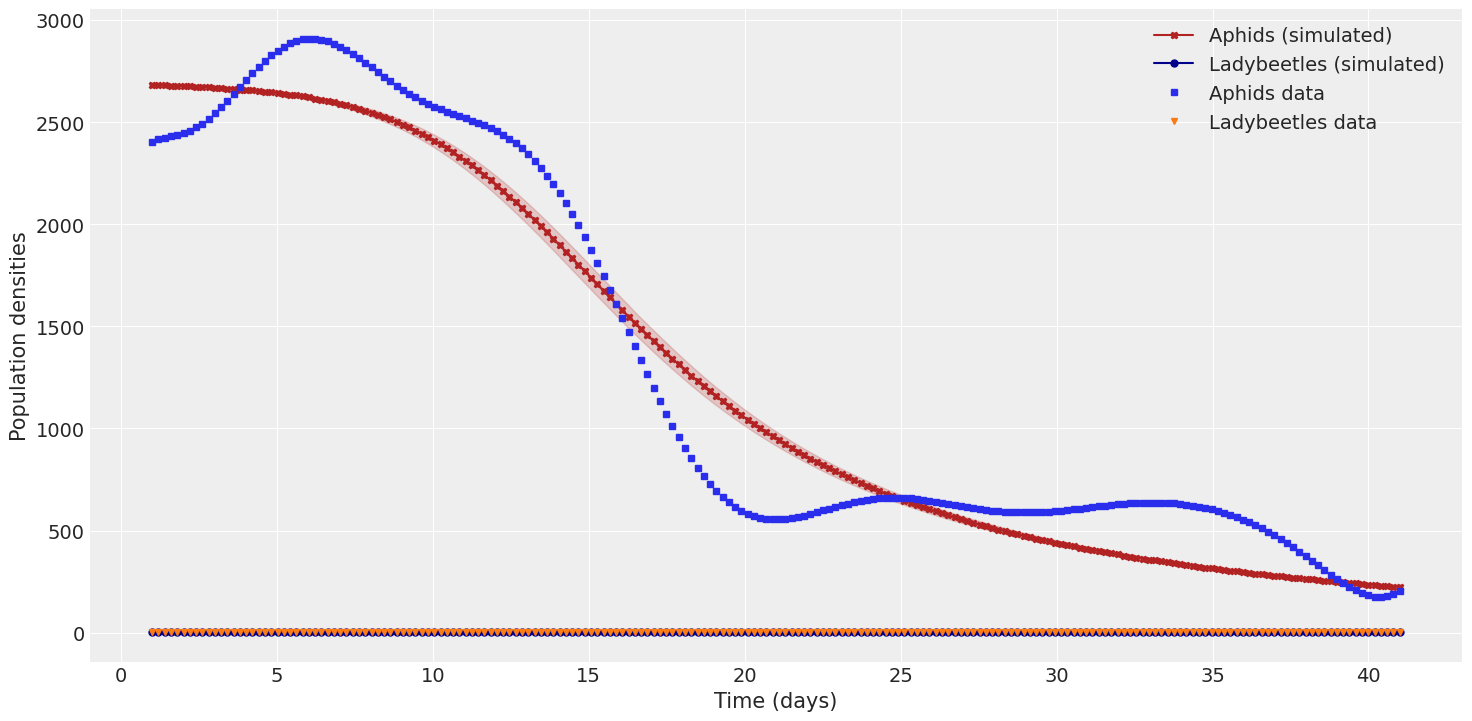

In [124]:
plt.figure(figsize=(15, 7.5))

plt.plot(
    time_observations,
    y_fit[:, 0],
    "firebrick",
    label="Aphids (simulated)",
    marker="X",
    linestyle="-",
    markersize=5,
)
plt.fill_between(time_observations, y_min[:, 0], y_max[:, 0], color="firebrick", alpha=0.2)

plt.plot(
    time_observations,
    y_fit[:, 1],
    "darkblue",
    label="Ladybeetles (simulated)",
    marker="o",
    linestyle="-",
    markersize=5,
)
plt.fill_between(time_observations, y_min[:, 1], y_max[:, 1], color="darkblue", alpha=0.2)

plt.plot(
    time_observations, 
    aphid_density, 
    label="Aphids data", 
    marker="s", 
    linestyle="", 
    markersize=5
)
plt.plot(
    time_observations, 
    ladybeetle_density, 
    label="Ladybeetles data", 
    marker="v", 
    linestyle="", 
    markersize=5
)

plt.legend(shadow=True)
plt.xlabel('Time (days)', fontsize=15)
plt.ylabel('Population densities', fontsize=15)

plt.tight_layout()
#plt.savefig("img/calibration_M09.png", dpi=300)
plt.show()

<ipython-input-136-cfca4f3e4fee>:21: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


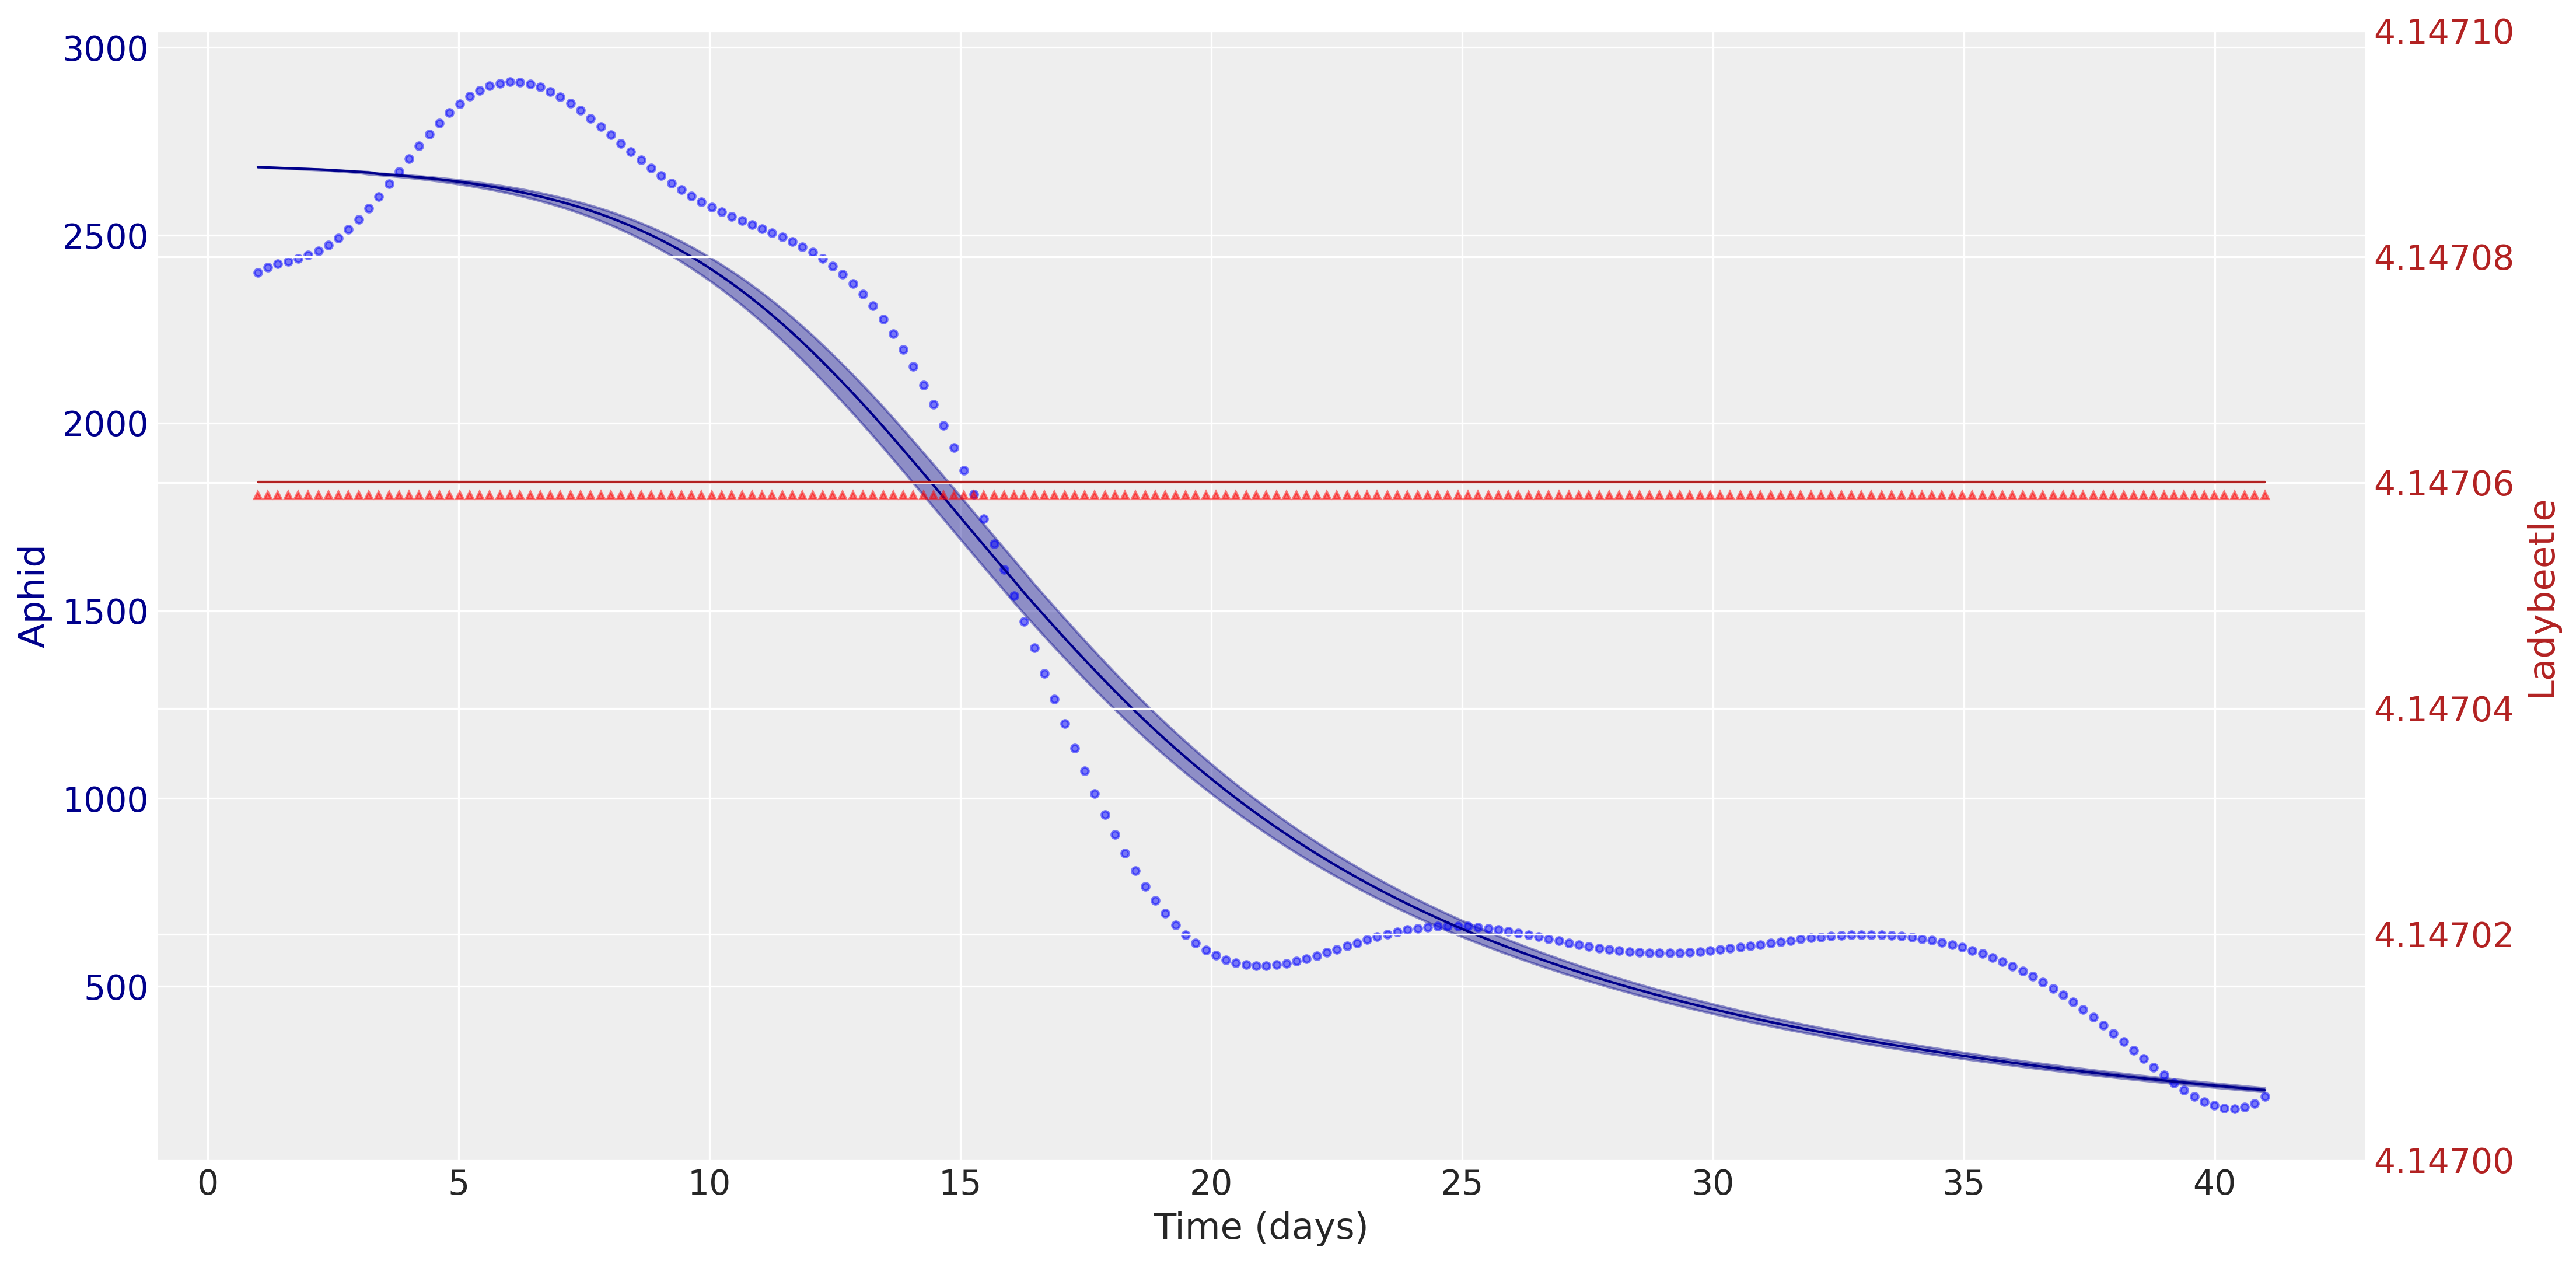

In [136]:
fig, ax1 = plt.subplots(1, 1, figsize = (15, 7.5), dpi = 300)
ax2 = ax1.twinx()
ax1.plot(time_observations, aphid_density, "bo", alpha = 0.5, markersize = 3)
ax2.plot(time_observations, ladybeetle_density, "r^", alpha = 0.5, markersize = 3)
ax1.plot(time_observations, y_fit[:, 0], "darkblue", alpha = 1.0, linewidth = 1)
ax2.plot(time_observations, y_fit[:, 1], "firebrick", alpha = 1.0, linewidth = 1)

ax1.fill_between(time_observations, y_min[:,0], y_max[:,0], color = "darkblue", alpha = 0.4)
ax2.fill_between(time_observations, y_min[:,1], y_max[:,1], color = "firebrick", alpha = 0.4)
ax1.set_xlabel(r"Time (days)")
ax1.set_ylabel(r"Aphid", color = "darkblue")
ax2.set_ylabel(r"Ladybeetle", color = "firebrick")
ax1.tick_params(axis = "y", labelcolor = "darkblue")
ax2.tick_params(axis = "y", labelcolor = "firebrick")
ax1.ticklabel_format(useOffset=False)
ax2.ticklabel_format(useOffset=False)

ax2.set_ylim([4.1470, 4.1471])

plt.tight_layout()
plt.savefig("img/calibration_M09.png", dpi=300)
plt.show()

In [126]:
print("-- Exporting calibrated parameter to CSV")

start_time = time.time()

dict_realizations = dict()  # save the realizations in a Python dictionary
progress_bar = tqdm(calibration_variable_names[1:])
for variable in progress_bar:
    progress_bar.set_description(f"Gathering {variable} realizations")
    parameter_realization = trace_calibration_M09.get_values(f"{variable}")
    dict_realizations[f"{variable}"] = parameter_realization

df_realizations = pd.DataFrame(dict_realizations)
df_realizations.to_csv("csv/calibration_realizations_M09.csv")

duration = time.time() - start_time

print(f"-- Exported done in {duration:.3f} seconds")

Gathering r3 realizations: 100%|██████████| 2/2 [00:00<00:00, 1457.62it/s]

-- Exporting calibrated parameter to CSV
-- Exported done in 0.089 seconds


In [127]:
df_realizations

r2            r3
0      0.000124  4.998205e-08
1      0.000124  4.998108e-08
2      0.000124  4.998784e-08
3      0.000124  4.999246e-08
4      0.000124  4.999508e-08
...         ...           ...
35995  0.000125  5.025636e-08
35996  0.000125  5.025636e-08
35997  0.000125  5.025636e-08
35998  0.000125  5.023447e-08
35999  0.000125  5.023447e-08

[36000 rows x 2 columns]